In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Convolution2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import keras.backend as K
from optimizer import optimAdam
# import inception_score

import _pickle as cPickle
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from PIL import Image

output_dir = '../log'

/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class GAN():
    
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.d_losses = []
        optimizer = self.select_optimizer()
        loss = self.select_loss()

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=loss, 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=loss, optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=loss, optimizer=optimizer)

    def select_optimizer(self):
        print("Adam")
        return Adam(0.0002, 0.5)
    
    def select_loss(self):
        print("Binary Crossentropy")
        return 'binary_crossentropy'
        
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, file_dir, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            d_loss = self.train_discriminator(X_train, half_batch)
            g_loss = self.train_generator(batch_size)
            self.d_losses.append(d_loss[0])

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch,file_dir)
                self.generate_images(self.generator, output_dir, epoch)
                self.generator.save_weights(os.path.join(output_dir, 'epoch_{}_g.h5'.format(epoch)))
                self.discriminator.save_weights(os.path.join(output_dir, 'epoch_{}_d.h5'.format(epoch)))

    def train_discriminator(self, X_train, half_batch):
        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict(noise)

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        return d_loss

    def train_generator(self,batch_size):
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * batch_size)

        # Train the generator
        g_loss = self.combined.train_on_batch(noise, valid_y)
        
        return g_loss
                

    def save_imgs(self, epoch, file_dir):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(file_dir % epoch)
        plt.close()
        
    def generate_images(self, generator_model, output_dir, epoch):
        """Feeds random seeds into the generator and tiles and saves the output to a PNG file."""
        def tile_images(image_stack):
            """Given a stacked tensor of images, reshapes them into a horizontal tiling for display."""
            assert len(image_stack.shape) == 3
            image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
            tiled_images = np.concatenate(image_list, axis=1)
            return tiled_images
        
        test_image_stack = generator_model.predict(np.random.rand(100, 100))
        test_image_stack = (test_image_stack * 127.5) + 127.5
        test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
        tiled_output = tile_images(test_image_stack)
        tiled_output = Image.fromarray(tiled_output)  # L specifies greyscale
        outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
        tiled_output.save(outfile)
        outfile = os.path.join(output_dir, 'epoch_{}.pkl'.format(epoch))
        with open(outfile, 'wb') as f:
            cPickle.dump(test_image_stack, f)

In [3]:
gan = GAN()
gan.train(epochs=30000, file_dir="../gan_images/mnist_%d.png", batch_size=32, save_interval=200)

Adam
Binary Crossentropy
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.650217, acc.: 53.12%] [G loss: 0.508877]
1 [D loss: 0.450039, acc.: 65.62%] [G loss: 0.629105]
2 [D loss: 0.431647, acc.: 62.50%] [G loss: 0.714066]
3 [D loss: 0.339825, acc.: 78.12%] [G loss: 0.887390]
4 [D loss: 0.270697, acc.: 90.62%] [G loss: 0.996047]
5 [D loss: 0.208964, acc.: 100.00%] [G loss: 1.082292]
6 [D loss: 0.182815, acc.: 100.00%] [G loss: 1.167247]
7 [D loss: 0.177952, acc.: 100.00%] [G loss: 1.335110]
8 [D loss: 0.187408, acc.: 100.00%] [G loss: 1.387822]
9 [D loss: 0.175987, acc.: 100.00%] [G loss: 1.606050]
10 [D loss: 0.149822, acc.: 100.00%] [G loss: 1.648562]
11 [D loss: 0.119133, acc.: 100.00%] [G loss: 1.792936]
12 [D loss: 0.101234, acc.: 100.00%] [G loss: 1.785055]
13 [D loss: 0.113732, acc.: 96.88%] [G loss: 1.919604]
14 [D loss: 0.085804, acc.: 100.00%] [G loss: 1.983775]
15 [D loss: 0.093863, acc.: 100.00%] [G loss: 2.080470]
16 [D loss: 0.092955, acc.: 100.00%] [G loss: 2.107670]
17 [D loss: 0.085330, acc.: 100.00%] [G loss: 2.182214]
18 [D lo

148 [D loss: 0.252173, acc.: 90.62%] [G loss: 3.210299]
149 [D loss: 0.125876, acc.: 93.75%] [G loss: 4.162521]
150 [D loss: 0.117439, acc.: 96.88%] [G loss: 4.103273]
151 [D loss: 0.292806, acc.: 84.38%] [G loss: 2.626998]
152 [D loss: 0.115957, acc.: 93.75%] [G loss: 3.300550]
153 [D loss: 0.105875, acc.: 96.88%] [G loss: 4.325766]
154 [D loss: 0.398813, acc.: 84.38%] [G loss: 2.219205]
155 [D loss: 0.316010, acc.: 87.50%] [G loss: 2.472027]
156 [D loss: 0.071184, acc.: 96.88%] [G loss: 3.529414]
157 [D loss: 0.219521, acc.: 90.62%] [G loss: 4.531929]
158 [D loss: 0.096937, acc.: 96.88%] [G loss: 3.651528]
159 [D loss: 0.139186, acc.: 93.75%] [G loss: 3.601790]
160 [D loss: 0.221650, acc.: 84.38%] [G loss: 3.580775]
161 [D loss: 0.310023, acc.: 84.38%] [G loss: 3.997097]
162 [D loss: 0.249094, acc.: 90.62%] [G loss: 2.727594]
163 [D loss: 0.152614, acc.: 93.75%] [G loss: 3.040773]
164 [D loss: 0.025666, acc.: 100.00%] [G loss: 3.837777]
165 [D loss: 0.356126, acc.: 87.50%] [G loss: 3

295 [D loss: 0.745876, acc.: 37.50%] [G loss: 0.788698]
296 [D loss: 0.690290, acc.: 46.88%] [G loss: 0.762393]
297 [D loss: 0.658027, acc.: 53.12%] [G loss: 0.769334]
298 [D loss: 0.779969, acc.: 31.25%] [G loss: 0.706480]
299 [D loss: 0.631897, acc.: 50.00%] [G loss: 0.789660]
300 [D loss: 0.673812, acc.: 59.38%] [G loss: 0.833615]
301 [D loss: 0.764064, acc.: 37.50%] [G loss: 0.736865]
302 [D loss: 0.731789, acc.: 40.62%] [G loss: 0.676841]
303 [D loss: 0.614649, acc.: 65.62%] [G loss: 0.739401]
304 [D loss: 0.688178, acc.: 53.12%] [G loss: 0.764154]
305 [D loss: 0.671483, acc.: 56.25%] [G loss: 0.735294]
306 [D loss: 0.716755, acc.: 40.62%] [G loss: 0.713247]
307 [D loss: 0.700147, acc.: 50.00%] [G loss: 0.681632]
308 [D loss: 0.605124, acc.: 68.75%] [G loss: 0.767998]
309 [D loss: 0.741977, acc.: 37.50%] [G loss: 0.713061]
310 [D loss: 0.701853, acc.: 46.88%] [G loss: 0.725233]
311 [D loss: 0.745684, acc.: 40.62%] [G loss: 0.708998]
312 [D loss: 0.673016, acc.: 56.25%] [G loss: 0.

443 [D loss: 0.649039, acc.: 53.12%] [G loss: 0.689565]
444 [D loss: 0.690432, acc.: 43.75%] [G loss: 0.669004]
445 [D loss: 0.669602, acc.: 43.75%] [G loss: 0.680303]
446 [D loss: 0.673112, acc.: 50.00%] [G loss: 0.682036]
447 [D loss: 0.656868, acc.: 53.12%] [G loss: 0.670769]
448 [D loss: 0.704225, acc.: 46.88%] [G loss: 0.660860]
449 [D loss: 0.686320, acc.: 43.75%] [G loss: 0.668039]
450 [D loss: 0.681201, acc.: 50.00%] [G loss: 0.660909]
451 [D loss: 0.690747, acc.: 46.88%] [G loss: 0.651690]
452 [D loss: 0.659334, acc.: 53.12%] [G loss: 0.654954]
453 [D loss: 0.658406, acc.: 53.12%] [G loss: 0.657776]
454 [D loss: 0.667713, acc.: 53.12%] [G loss: 0.655928]
455 [D loss: 0.678426, acc.: 53.12%] [G loss: 0.664143]
456 [D loss: 0.679768, acc.: 46.88%] [G loss: 0.663322]
457 [D loss: 0.663301, acc.: 43.75%] [G loss: 0.651586]
458 [D loss: 0.672134, acc.: 50.00%] [G loss: 0.659811]
459 [D loss: 0.663392, acc.: 50.00%] [G loss: 0.661371]
460 [D loss: 0.692926, acc.: 50.00%] [G loss: 0.

592 [D loss: 0.638237, acc.: 59.38%] [G loss: 0.719481]
593 [D loss: 0.652686, acc.: 62.50%] [G loss: 0.729056]
594 [D loss: 0.636422, acc.: 59.38%] [G loss: 0.735412]
595 [D loss: 0.665582, acc.: 50.00%] [G loss: 0.713197]
596 [D loss: 0.672257, acc.: 46.88%] [G loss: 0.709107]
597 [D loss: 0.694709, acc.: 50.00%] [G loss: 0.704067]
598 [D loss: 0.634640, acc.: 59.38%] [G loss: 0.719910]
599 [D loss: 0.618974, acc.: 59.38%] [G loss: 0.686729]
600 [D loss: 0.647571, acc.: 59.38%] [G loss: 0.690380]
601 [D loss: 0.651988, acc.: 53.12%] [G loss: 0.692825]
602 [D loss: 0.608151, acc.: 65.62%] [G loss: 0.706737]
603 [D loss: 0.648157, acc.: 56.25%] [G loss: 0.676660]
604 [D loss: 0.674999, acc.: 59.38%] [G loss: 0.681747]
605 [D loss: 0.664860, acc.: 59.38%] [G loss: 0.702304]
606 [D loss: 0.634860, acc.: 62.50%] [G loss: 0.713988]
607 [D loss: 0.684618, acc.: 50.00%] [G loss: 0.709934]
608 [D loss: 0.668304, acc.: 50.00%] [G loss: 0.712013]
609 [D loss: 0.648298, acc.: 56.25%] [G loss: 0.

742 [D loss: 0.651854, acc.: 53.12%] [G loss: 0.731682]
743 [D loss: 0.613067, acc.: 56.25%] [G loss: 0.766903]
744 [D loss: 0.595663, acc.: 68.75%] [G loss: 0.764923]
745 [D loss: 0.651023, acc.: 56.25%] [G loss: 0.731816]
746 [D loss: 0.644459, acc.: 71.88%] [G loss: 0.722418]
747 [D loss: 0.647798, acc.: 56.25%] [G loss: 0.757314]
748 [D loss: 0.657423, acc.: 59.38%] [G loss: 0.761372]
749 [D loss: 0.634590, acc.: 75.00%] [G loss: 0.768576]
750 [D loss: 0.684876, acc.: 53.12%] [G loss: 0.733056]
751 [D loss: 0.641750, acc.: 62.50%] [G loss: 0.760773]
752 [D loss: 0.600949, acc.: 68.75%] [G loss: 0.762252]
753 [D loss: 0.687986, acc.: 53.12%] [G loss: 0.806364]
754 [D loss: 0.637765, acc.: 68.75%] [G loss: 0.814302]
755 [D loss: 0.656476, acc.: 56.25%] [G loss: 0.764358]
756 [D loss: 0.606631, acc.: 65.62%] [G loss: 0.765034]
757 [D loss: 0.596683, acc.: 78.12%] [G loss: 0.761695]
758 [D loss: 0.665387, acc.: 56.25%] [G loss: 0.732152]
759 [D loss: 0.625005, acc.: 68.75%] [G loss: 0.

892 [D loss: 0.593733, acc.: 71.88%] [G loss: 0.741428]
893 [D loss: 0.624158, acc.: 68.75%] [G loss: 0.773855]
894 [D loss: 0.626778, acc.: 65.62%] [G loss: 0.766987]
895 [D loss: 0.696705, acc.: 50.00%] [G loss: 0.800322]
896 [D loss: 0.612611, acc.: 71.88%] [G loss: 0.823101]
897 [D loss: 0.680743, acc.: 50.00%] [G loss: 0.777211]
898 [D loss: 0.636136, acc.: 65.62%] [G loss: 0.764620]
899 [D loss: 0.659457, acc.: 50.00%] [G loss: 0.763985]
900 [D loss: 0.657077, acc.: 59.38%] [G loss: 0.763185]
901 [D loss: 0.606479, acc.: 75.00%] [G loss: 0.803067]
902 [D loss: 0.650192, acc.: 71.88%] [G loss: 0.808956]
903 [D loss: 0.656107, acc.: 71.88%] [G loss: 0.800166]
904 [D loss: 0.652652, acc.: 62.50%] [G loss: 0.753232]
905 [D loss: 0.652843, acc.: 62.50%] [G loss: 0.705229]
906 [D loss: 0.637474, acc.: 65.62%] [G loss: 0.726556]
907 [D loss: 0.691872, acc.: 53.12%] [G loss: 0.741261]
908 [D loss: 0.641223, acc.: 62.50%] [G loss: 0.745697]
909 [D loss: 0.619008, acc.: 71.88%] [G loss: 0.

1039 [D loss: 0.594672, acc.: 71.88%] [G loss: 0.839066]
1040 [D loss: 0.606398, acc.: 75.00%] [G loss: 0.826622]
1041 [D loss: 0.581266, acc.: 75.00%] [G loss: 0.780395]
1042 [D loss: 0.584358, acc.: 68.75%] [G loss: 0.826251]
1043 [D loss: 0.616287, acc.: 78.12%] [G loss: 0.824934]
1044 [D loss: 0.583533, acc.: 84.38%] [G loss: 0.828405]
1045 [D loss: 0.585398, acc.: 78.12%] [G loss: 0.838085]
1046 [D loss: 0.651145, acc.: 53.12%] [G loss: 0.861471]
1047 [D loss: 0.644761, acc.: 78.12%] [G loss: 0.834043]
1048 [D loss: 0.624220, acc.: 68.75%] [G loss: 0.840346]
1049 [D loss: 0.668600, acc.: 53.12%] [G loss: 0.830096]
1050 [D loss: 0.617605, acc.: 68.75%] [G loss: 0.809364]
1051 [D loss: 0.590991, acc.: 75.00%] [G loss: 0.809412]
1052 [D loss: 0.607611, acc.: 75.00%] [G loss: 0.789009]
1053 [D loss: 0.578933, acc.: 81.25%] [G loss: 0.809637]
1054 [D loss: 0.566770, acc.: 81.25%] [G loss: 0.790500]
1055 [D loss: 0.534689, acc.: 81.25%] [G loss: 0.828098]
1056 [D loss: 0.618897, acc.: 6

1184 [D loss: 0.570670, acc.: 78.12%] [G loss: 0.850317]
1185 [D loss: 0.624796, acc.: 65.62%] [G loss: 0.833900]
1186 [D loss: 0.579121, acc.: 78.12%] [G loss: 0.850615]
1187 [D loss: 0.589539, acc.: 75.00%] [G loss: 0.813222]
1188 [D loss: 0.594449, acc.: 75.00%] [G loss: 0.865864]
1189 [D loss: 0.667838, acc.: 53.12%] [G loss: 0.846593]
1190 [D loss: 0.564907, acc.: 65.62%] [G loss: 0.864649]
1191 [D loss: 0.648965, acc.: 62.50%] [G loss: 0.865212]
1192 [D loss: 0.613942, acc.: 62.50%] [G loss: 0.879350]
1193 [D loss: 0.592330, acc.: 75.00%] [G loss: 0.813428]
1194 [D loss: 0.593633, acc.: 75.00%] [G loss: 0.832373]
1195 [D loss: 0.596877, acc.: 68.75%] [G loss: 0.828890]
1196 [D loss: 0.602148, acc.: 71.88%] [G loss: 0.889423]
1197 [D loss: 0.591543, acc.: 71.88%] [G loss: 0.859501]
1198 [D loss: 0.618455, acc.: 65.62%] [G loss: 0.895309]
1199 [D loss: 0.568253, acc.: 78.12%] [G loss: 0.872897]
1200 [D loss: 0.579204, acc.: 75.00%] [G loss: 0.835419]
1201 [D loss: 0.624032, acc.: 6

1331 [D loss: 0.628747, acc.: 62.50%] [G loss: 0.829558]
1332 [D loss: 0.651018, acc.: 59.38%] [G loss: 0.808166]
1333 [D loss: 0.458296, acc.: 84.38%] [G loss: 0.859391]
1334 [D loss: 0.512235, acc.: 87.50%] [G loss: 0.890972]
1335 [D loss: 0.567191, acc.: 65.62%] [G loss: 0.897901]
1336 [D loss: 0.575520, acc.: 78.12%] [G loss: 0.811012]
1337 [D loss: 0.726534, acc.: 46.88%] [G loss: 0.794478]
1338 [D loss: 0.621081, acc.: 59.38%] [G loss: 0.843292]
1339 [D loss: 0.575860, acc.: 78.12%] [G loss: 0.947514]
1340 [D loss: 0.588417, acc.: 68.75%] [G loss: 0.907948]
1341 [D loss: 0.574007, acc.: 71.88%] [G loss: 0.899729]
1342 [D loss: 0.622443, acc.: 65.62%] [G loss: 0.921678]
1343 [D loss: 0.619290, acc.: 71.88%] [G loss: 0.842836]
1344 [D loss: 0.656314, acc.: 50.00%] [G loss: 0.791028]
1345 [D loss: 0.614776, acc.: 62.50%] [G loss: 0.789473]
1346 [D loss: 0.575635, acc.: 71.88%] [G loss: 0.828557]
1347 [D loss: 0.505312, acc.: 87.50%] [G loss: 0.846220]
1348 [D loss: 0.590286, acc.: 7

1475 [D loss: 0.630813, acc.: 65.62%] [G loss: 0.942352]
1476 [D loss: 0.659598, acc.: 59.38%] [G loss: 1.006492]
1477 [D loss: 0.546889, acc.: 75.00%] [G loss: 0.914910]
1478 [D loss: 0.644235, acc.: 62.50%] [G loss: 0.787537]
1479 [D loss: 0.553487, acc.: 75.00%] [G loss: 0.865219]
1480 [D loss: 0.574066, acc.: 65.62%] [G loss: 0.877451]
1481 [D loss: 0.576293, acc.: 68.75%] [G loss: 0.929170]
1482 [D loss: 0.554249, acc.: 71.88%] [G loss: 0.965205]
1483 [D loss: 0.705379, acc.: 59.38%] [G loss: 1.007958]
1484 [D loss: 0.614861, acc.: 62.50%] [G loss: 0.940982]
1485 [D loss: 0.577461, acc.: 71.88%] [G loss: 0.861241]
1486 [D loss: 0.577709, acc.: 81.25%] [G loss: 0.915087]
1487 [D loss: 0.682084, acc.: 46.88%] [G loss: 0.855885]
1488 [D loss: 0.594206, acc.: 65.62%] [G loss: 0.906018]
1489 [D loss: 0.597275, acc.: 62.50%] [G loss: 0.941288]
1490 [D loss: 0.722634, acc.: 43.75%] [G loss: 0.859912]
1491 [D loss: 0.589886, acc.: 71.88%] [G loss: 0.921871]
1492 [D loss: 0.637624, acc.: 6

1621 [D loss: 0.632478, acc.: 56.25%] [G loss: 0.877355]
1622 [D loss: 0.593641, acc.: 71.88%] [G loss: 0.866694]
1623 [D loss: 0.602098, acc.: 65.62%] [G loss: 0.956689]
1624 [D loss: 0.554731, acc.: 78.12%] [G loss: 0.978622]
1625 [D loss: 0.556082, acc.: 81.25%] [G loss: 0.922767]
1626 [D loss: 0.592974, acc.: 71.88%] [G loss: 0.925146]
1627 [D loss: 0.574308, acc.: 71.88%] [G loss: 0.894694]
1628 [D loss: 0.584607, acc.: 75.00%] [G loss: 0.873007]
1629 [D loss: 0.590518, acc.: 71.88%] [G loss: 0.909140]
1630 [D loss: 0.573879, acc.: 62.50%] [G loss: 0.880528]
1631 [D loss: 0.645354, acc.: 62.50%] [G loss: 0.965647]
1632 [D loss: 0.616563, acc.: 62.50%] [G loss: 0.956530]
1633 [D loss: 0.618218, acc.: 68.75%] [G loss: 0.937508]
1634 [D loss: 0.550150, acc.: 68.75%] [G loss: 0.959709]
1635 [D loss: 0.648085, acc.: 59.38%] [G loss: 0.949113]
1636 [D loss: 0.631574, acc.: 62.50%] [G loss: 0.873271]
1637 [D loss: 0.595927, acc.: 65.62%] [G loss: 0.836658]
1638 [D loss: 0.629245, acc.: 6

1768 [D loss: 0.659939, acc.: 56.25%] [G loss: 0.896276]
1769 [D loss: 0.596854, acc.: 75.00%] [G loss: 0.886506]
1770 [D loss: 0.616005, acc.: 65.62%] [G loss: 0.904496]
1771 [D loss: 0.593366, acc.: 68.75%] [G loss: 0.830747]
1772 [D loss: 0.616176, acc.: 68.75%] [G loss: 0.887495]
1773 [D loss: 0.694396, acc.: 59.38%] [G loss: 0.964765]
1774 [D loss: 0.627751, acc.: 62.50%] [G loss: 0.978926]
1775 [D loss: 0.700149, acc.: 50.00%] [G loss: 0.882522]
1776 [D loss: 0.594367, acc.: 65.62%] [G loss: 0.888654]
1777 [D loss: 0.519315, acc.: 75.00%] [G loss: 0.864146]
1778 [D loss: 0.595706, acc.: 71.88%] [G loss: 0.897180]
1779 [D loss: 0.566812, acc.: 68.75%] [G loss: 0.937281]
1780 [D loss: 0.661282, acc.: 68.75%] [G loss: 0.960268]
1781 [D loss: 0.569566, acc.: 71.88%] [G loss: 0.957290]
1782 [D loss: 0.642619, acc.: 68.75%] [G loss: 0.904244]
1783 [D loss: 0.643899, acc.: 62.50%] [G loss: 0.856976]
1784 [D loss: 0.583008, acc.: 62.50%] [G loss: 0.745081]
1785 [D loss: 0.601938, acc.: 6

1915 [D loss: 0.567945, acc.: 78.12%] [G loss: 0.896202]
1916 [D loss: 0.599223, acc.: 65.62%] [G loss: 0.840737]
1917 [D loss: 0.549257, acc.: 78.12%] [G loss: 0.877311]
1918 [D loss: 0.618914, acc.: 71.88%] [G loss: 0.887098]
1919 [D loss: 0.638217, acc.: 68.75%] [G loss: 0.890360]
1920 [D loss: 0.562270, acc.: 71.88%] [G loss: 0.919354]
1921 [D loss: 0.599470, acc.: 68.75%] [G loss: 0.865102]
1922 [D loss: 0.627855, acc.: 68.75%] [G loss: 0.910213]
1923 [D loss: 0.678894, acc.: 56.25%] [G loss: 0.865099]
1924 [D loss: 0.725597, acc.: 46.88%] [G loss: 0.818166]
1925 [D loss: 0.712446, acc.: 43.75%] [G loss: 0.802196]
1926 [D loss: 0.662352, acc.: 56.25%] [G loss: 0.859482]
1927 [D loss: 0.625723, acc.: 68.75%] [G loss: 0.958507]
1928 [D loss: 0.649855, acc.: 62.50%] [G loss: 0.889839]
1929 [D loss: 0.619888, acc.: 59.38%] [G loss: 0.831573]
1930 [D loss: 0.661788, acc.: 50.00%] [G loss: 0.936223]
1931 [D loss: 0.559773, acc.: 75.00%] [G loss: 0.972528]
1932 [D loss: 0.551430, acc.: 7

2059 [D loss: 0.625538, acc.: 46.88%] [G loss: 0.960815]
2060 [D loss: 0.645948, acc.: 65.62%] [G loss: 1.060846]
2061 [D loss: 0.628637, acc.: 68.75%] [G loss: 0.991163]
2062 [D loss: 0.638313, acc.: 59.38%] [G loss: 0.871939]
2063 [D loss: 0.540763, acc.: 81.25%] [G loss: 0.819895]
2064 [D loss: 0.696153, acc.: 50.00%] [G loss: 0.813913]
2065 [D loss: 0.632474, acc.: 65.62%] [G loss: 0.838654]
2066 [D loss: 0.581480, acc.: 71.88%] [G loss: 0.982293]
2067 [D loss: 0.562972, acc.: 71.88%] [G loss: 0.935396]
2068 [D loss: 0.614413, acc.: 62.50%] [G loss: 0.963382]
2069 [D loss: 0.646736, acc.: 62.50%] [G loss: 0.896325]
2070 [D loss: 0.756385, acc.: 46.88%] [G loss: 0.907852]
2071 [D loss: 0.578520, acc.: 65.62%] [G loss: 0.991595]
2072 [D loss: 0.629681, acc.: 71.88%] [G loss: 1.000012]
2073 [D loss: 0.622171, acc.: 68.75%] [G loss: 0.941033]
2074 [D loss: 0.629332, acc.: 59.38%] [G loss: 0.923336]
2075 [D loss: 0.608759, acc.: 65.62%] [G loss: 0.897401]
2076 [D loss: 0.568226, acc.: 7

2205 [D loss: 0.690803, acc.: 53.12%] [G loss: 0.936400]
2206 [D loss: 0.660541, acc.: 62.50%] [G loss: 0.950486]
2207 [D loss: 0.602956, acc.: 62.50%] [G loss: 0.996741]
2208 [D loss: 0.620599, acc.: 46.88%] [G loss: 0.921612]
2209 [D loss: 0.624339, acc.: 62.50%] [G loss: 0.973864]
2210 [D loss: 0.610604, acc.: 65.62%] [G loss: 0.970821]
2211 [D loss: 0.655816, acc.: 59.38%] [G loss: 0.895085]
2212 [D loss: 0.601111, acc.: 68.75%] [G loss: 0.903916]
2213 [D loss: 0.587863, acc.: 81.25%] [G loss: 0.913924]
2214 [D loss: 0.597574, acc.: 68.75%] [G loss: 0.891155]
2215 [D loss: 0.590378, acc.: 71.88%] [G loss: 0.846977]
2216 [D loss: 0.616178, acc.: 75.00%] [G loss: 0.837980]
2217 [D loss: 0.596058, acc.: 65.62%] [G loss: 0.800526]
2218 [D loss: 0.528240, acc.: 87.50%] [G loss: 0.850595]
2219 [D loss: 0.640730, acc.: 56.25%] [G loss: 0.874266]
2220 [D loss: 0.660726, acc.: 50.00%] [G loss: 0.845929]
2221 [D loss: 0.598455, acc.: 71.88%] [G loss: 0.817205]
2222 [D loss: 0.606349, acc.: 6

2351 [D loss: 0.612844, acc.: 71.88%] [G loss: 0.851017]
2352 [D loss: 0.594947, acc.: 59.38%] [G loss: 0.890458]
2353 [D loss: 0.605053, acc.: 62.50%] [G loss: 0.978040]
2354 [D loss: 0.575766, acc.: 65.62%] [G loss: 0.966738]
2355 [D loss: 0.711582, acc.: 53.12%] [G loss: 0.877924]
2356 [D loss: 0.706849, acc.: 56.25%] [G loss: 0.919513]
2357 [D loss: 0.601761, acc.: 65.62%] [G loss: 0.939608]
2358 [D loss: 0.643231, acc.: 71.88%] [G loss: 0.865614]
2359 [D loss: 0.577680, acc.: 68.75%] [G loss: 0.879533]
2360 [D loss: 0.619169, acc.: 62.50%] [G loss: 0.852849]
2361 [D loss: 0.583214, acc.: 65.62%] [G loss: 0.882418]
2362 [D loss: 0.637688, acc.: 62.50%] [G loss: 0.947041]
2363 [D loss: 0.572318, acc.: 75.00%] [G loss: 0.961226]
2364 [D loss: 0.554076, acc.: 75.00%] [G loss: 0.939765]
2365 [D loss: 0.684012, acc.: 56.25%] [G loss: 0.919703]
2366 [D loss: 0.544386, acc.: 78.12%] [G loss: 0.856805]
2367 [D loss: 0.641609, acc.: 62.50%] [G loss: 0.840604]
2368 [D loss: 0.600232, acc.: 6

2495 [D loss: 0.617874, acc.: 62.50%] [G loss: 0.878981]
2496 [D loss: 0.577886, acc.: 68.75%] [G loss: 1.011349]
2497 [D loss: 0.639296, acc.: 65.62%] [G loss: 0.917120]
2498 [D loss: 0.604126, acc.: 75.00%] [G loss: 0.896546]
2499 [D loss: 0.684829, acc.: 53.12%] [G loss: 0.921380]
2500 [D loss: 0.586116, acc.: 75.00%] [G loss: 0.889287]
2501 [D loss: 0.588029, acc.: 68.75%] [G loss: 0.965742]
2502 [D loss: 0.697883, acc.: 65.62%] [G loss: 0.916289]
2503 [D loss: 0.660283, acc.: 59.38%] [G loss: 0.905438]
2504 [D loss: 0.729691, acc.: 59.38%] [G loss: 0.907355]
2505 [D loss: 0.664349, acc.: 56.25%] [G loss: 0.907918]
2506 [D loss: 0.560001, acc.: 68.75%] [G loss: 1.051527]
2507 [D loss: 0.530647, acc.: 75.00%] [G loss: 0.991995]
2508 [D loss: 0.629169, acc.: 68.75%] [G loss: 0.942540]
2509 [D loss: 0.496451, acc.: 87.50%] [G loss: 0.866679]
2510 [D loss: 0.782786, acc.: 56.25%] [G loss: 0.904655]
2511 [D loss: 0.637219, acc.: 56.25%] [G loss: 0.809961]
2512 [D loss: 0.619039, acc.: 7

2640 [D loss: 0.534947, acc.: 75.00%] [G loss: 0.822591]
2641 [D loss: 0.672062, acc.: 62.50%] [G loss: 0.872689]
2642 [D loss: 0.590780, acc.: 68.75%] [G loss: 0.944745]
2643 [D loss: 0.654163, acc.: 59.38%] [G loss: 0.921337]
2644 [D loss: 0.620194, acc.: 62.50%] [G loss: 0.925102]
2645 [D loss: 0.636243, acc.: 65.62%] [G loss: 0.897415]
2646 [D loss: 0.646022, acc.: 59.38%] [G loss: 0.880461]
2647 [D loss: 0.619166, acc.: 59.38%] [G loss: 0.905738]
2648 [D loss: 0.705965, acc.: 50.00%] [G loss: 0.837849]
2649 [D loss: 0.659689, acc.: 65.62%] [G loss: 0.795141]
2650 [D loss: 0.598120, acc.: 68.75%] [G loss: 0.878637]
2651 [D loss: 0.619400, acc.: 68.75%] [G loss: 0.879545]
2652 [D loss: 0.703482, acc.: 53.12%] [G loss: 0.937084]
2653 [D loss: 0.584718, acc.: 75.00%] [G loss: 0.959448]
2654 [D loss: 0.587479, acc.: 62.50%] [G loss: 0.907587]
2655 [D loss: 0.612442, acc.: 75.00%] [G loss: 0.882846]
2656 [D loss: 0.615480, acc.: 68.75%] [G loss: 0.820470]
2657 [D loss: 0.637438, acc.: 6

2784 [D loss: 0.571456, acc.: 78.12%] [G loss: 0.827257]
2785 [D loss: 0.627080, acc.: 59.38%] [G loss: 0.831370]
2786 [D loss: 0.598485, acc.: 78.12%] [G loss: 0.884620]
2787 [D loss: 0.577754, acc.: 71.88%] [G loss: 0.886920]
2788 [D loss: 0.616918, acc.: 65.62%] [G loss: 0.931437]
2789 [D loss: 0.604147, acc.: 78.12%] [G loss: 0.901188]
2790 [D loss: 0.561944, acc.: 68.75%] [G loss: 0.972210]
2791 [D loss: 0.762023, acc.: 40.62%] [G loss: 0.919925]
2792 [D loss: 0.642122, acc.: 53.12%] [G loss: 0.903289]
2793 [D loss: 0.623449, acc.: 65.62%] [G loss: 0.869361]
2794 [D loss: 0.645574, acc.: 50.00%] [G loss: 0.927941]
2795 [D loss: 0.625878, acc.: 65.62%] [G loss: 0.918129]
2796 [D loss: 0.631498, acc.: 68.75%] [G loss: 1.060811]
2797 [D loss: 0.510312, acc.: 84.38%] [G loss: 0.897896]
2798 [D loss: 0.676165, acc.: 56.25%] [G loss: 0.984546]
2799 [D loss: 0.541425, acc.: 81.25%] [G loss: 0.870859]
2800 [D loss: 0.481261, acc.: 78.12%] [G loss: 0.920516]
2801 [D loss: 0.739546, acc.: 5

2929 [D loss: 0.601005, acc.: 65.62%] [G loss: 0.919993]
2930 [D loss: 0.624175, acc.: 68.75%] [G loss: 0.931033]
2931 [D loss: 0.643954, acc.: 59.38%] [G loss: 0.907616]
2932 [D loss: 0.677290, acc.: 56.25%] [G loss: 0.875299]
2933 [D loss: 0.632254, acc.: 71.88%] [G loss: 0.789965]
2934 [D loss: 0.682137, acc.: 53.12%] [G loss: 0.899697]
2935 [D loss: 0.688279, acc.: 56.25%] [G loss: 0.840266]
2936 [D loss: 0.677330, acc.: 53.12%] [G loss: 0.892636]
2937 [D loss: 0.597973, acc.: 81.25%] [G loss: 0.928872]
2938 [D loss: 0.600203, acc.: 68.75%] [G loss: 0.893010]
2939 [D loss: 0.649643, acc.: 56.25%] [G loss: 0.851310]
2940 [D loss: 0.637391, acc.: 62.50%] [G loss: 0.999901]
2941 [D loss: 0.704239, acc.: 53.12%] [G loss: 0.907811]
2942 [D loss: 0.691997, acc.: 65.62%] [G loss: 0.806857]
2943 [D loss: 0.692588, acc.: 65.62%] [G loss: 0.838126]
2944 [D loss: 0.628635, acc.: 62.50%] [G loss: 0.902625]
2945 [D loss: 0.597002, acc.: 75.00%] [G loss: 0.921543]
2946 [D loss: 0.710017, acc.: 5

3074 [D loss: 0.624696, acc.: 59.38%] [G loss: 0.853922]
3075 [D loss: 0.603433, acc.: 68.75%] [G loss: 0.884244]
3076 [D loss: 0.678874, acc.: 59.38%] [G loss: 0.926813]
3077 [D loss: 0.542637, acc.: 75.00%] [G loss: 0.928729]
3078 [D loss: 0.634247, acc.: 68.75%] [G loss: 0.862411]
3079 [D loss: 0.641417, acc.: 62.50%] [G loss: 0.825261]
3080 [D loss: 0.614459, acc.: 65.62%] [G loss: 0.850235]
3081 [D loss: 0.599672, acc.: 65.62%] [G loss: 0.838095]
3082 [D loss: 0.725274, acc.: 43.75%] [G loss: 0.837184]
3083 [D loss: 0.680952, acc.: 62.50%] [G loss: 0.828860]
3084 [D loss: 0.633011, acc.: 62.50%] [G loss: 0.862084]
3085 [D loss: 0.632802, acc.: 65.62%] [G loss: 0.943492]
3086 [D loss: 0.656651, acc.: 62.50%] [G loss: 0.908426]
3087 [D loss: 0.580147, acc.: 71.88%] [G loss: 0.971588]
3088 [D loss: 0.593609, acc.: 62.50%] [G loss: 0.886061]
3089 [D loss: 0.703384, acc.: 68.75%] [G loss: 0.884005]
3090 [D loss: 0.690907, acc.: 59.38%] [G loss: 0.870110]
3091 [D loss: 0.640615, acc.: 6

3221 [D loss: 0.641625, acc.: 71.88%] [G loss: 0.948426]
3222 [D loss: 0.669981, acc.: 56.25%] [G loss: 0.897723]
3223 [D loss: 0.673190, acc.: 56.25%] [G loss: 0.918263]
3224 [D loss: 0.675548, acc.: 59.38%] [G loss: 0.923126]
3225 [D loss: 0.701968, acc.: 56.25%] [G loss: 0.846445]
3226 [D loss: 0.539238, acc.: 81.25%] [G loss: 0.845144]
3227 [D loss: 0.590459, acc.: 68.75%] [G loss: 0.921222]
3228 [D loss: 0.684076, acc.: 62.50%] [G loss: 0.882840]
3229 [D loss: 0.582700, acc.: 65.62%] [G loss: 0.983596]
3230 [D loss: 0.657911, acc.: 53.12%] [G loss: 0.952748]
3231 [D loss: 0.605958, acc.: 62.50%] [G loss: 0.853404]
3232 [D loss: 0.636299, acc.: 65.62%] [G loss: 0.918822]
3233 [D loss: 0.666031, acc.: 56.25%] [G loss: 0.953893]
3234 [D loss: 0.693552, acc.: 65.62%] [G loss: 0.880157]
3235 [D loss: 0.612276, acc.: 68.75%] [G loss: 0.921821]
3236 [D loss: 0.606030, acc.: 62.50%] [G loss: 0.890407]
3237 [D loss: 0.605667, acc.: 68.75%] [G loss: 0.887119]
3238 [D loss: 0.701152, acc.: 5

3368 [D loss: 0.639422, acc.: 65.62%] [G loss: 0.849899]
3369 [D loss: 0.607619, acc.: 71.88%] [G loss: 0.836244]
3370 [D loss: 0.647789, acc.: 62.50%] [G loss: 0.848306]
3371 [D loss: 0.692740, acc.: 56.25%] [G loss: 0.891789]
3372 [D loss: 0.610521, acc.: 71.88%] [G loss: 0.840016]
3373 [D loss: 0.654221, acc.: 59.38%] [G loss: 0.864871]
3374 [D loss: 0.639818, acc.: 59.38%] [G loss: 0.906970]
3375 [D loss: 0.674767, acc.: 56.25%] [G loss: 0.889365]
3376 [D loss: 0.629135, acc.: 62.50%] [G loss: 0.873748]
3377 [D loss: 0.670169, acc.: 62.50%] [G loss: 0.917487]
3378 [D loss: 0.635475, acc.: 59.38%] [G loss: 0.859232]
3379 [D loss: 0.618135, acc.: 71.88%] [G loss: 0.941787]
3380 [D loss: 0.620654, acc.: 75.00%] [G loss: 0.898283]
3381 [D loss: 0.645322, acc.: 75.00%] [G loss: 0.878596]
3382 [D loss: 0.683523, acc.: 59.38%] [G loss: 0.943950]
3383 [D loss: 0.557293, acc.: 68.75%] [G loss: 0.812209]
3384 [D loss: 0.679980, acc.: 62.50%] [G loss: 0.820827]
3385 [D loss: 0.731846, acc.: 5

3512 [D loss: 0.600453, acc.: 71.88%] [G loss: 0.864601]
3513 [D loss: 0.579312, acc.: 62.50%] [G loss: 0.912889]
3514 [D loss: 0.637767, acc.: 62.50%] [G loss: 0.917023]
3515 [D loss: 0.594072, acc.: 68.75%] [G loss: 0.868663]
3516 [D loss: 0.705470, acc.: 62.50%] [G loss: 0.862589]
3517 [D loss: 0.620067, acc.: 75.00%] [G loss: 0.929775]
3518 [D loss: 0.635059, acc.: 53.12%] [G loss: 0.952921]
3519 [D loss: 0.735084, acc.: 43.75%] [G loss: 0.809693]
3520 [D loss: 0.620595, acc.: 75.00%] [G loss: 0.838466]
3521 [D loss: 0.671623, acc.: 50.00%] [G loss: 0.930706]
3522 [D loss: 0.579620, acc.: 68.75%] [G loss: 0.810545]
3523 [D loss: 0.606080, acc.: 68.75%] [G loss: 0.799497]
3524 [D loss: 0.672234, acc.: 62.50%] [G loss: 0.885041]
3525 [D loss: 0.660560, acc.: 62.50%] [G loss: 0.996000]
3526 [D loss: 0.600151, acc.: 68.75%] [G loss: 0.935504]
3527 [D loss: 0.704234, acc.: 50.00%] [G loss: 0.950213]
3528 [D loss: 0.635958, acc.: 56.25%] [G loss: 1.003712]
3529 [D loss: 0.682452, acc.: 5

3657 [D loss: 0.721949, acc.: 53.12%] [G loss: 0.896870]
3658 [D loss: 0.701668, acc.: 59.38%] [G loss: 0.895300]
3659 [D loss: 0.615572, acc.: 59.38%] [G loss: 0.882719]
3660 [D loss: 0.601530, acc.: 56.25%] [G loss: 0.824158]
3661 [D loss: 0.657258, acc.: 68.75%] [G loss: 0.881920]
3662 [D loss: 0.602646, acc.: 68.75%] [G loss: 0.891615]
3663 [D loss: 0.560535, acc.: 81.25%] [G loss: 0.967525]
3664 [D loss: 0.585803, acc.: 68.75%] [G loss: 0.903896]
3665 [D loss: 0.624295, acc.: 62.50%] [G loss: 0.887243]
3666 [D loss: 0.627058, acc.: 65.62%] [G loss: 1.006143]
3667 [D loss: 0.690668, acc.: 53.12%] [G loss: 1.036786]
3668 [D loss: 0.584086, acc.: 62.50%] [G loss: 0.988632]
3669 [D loss: 0.752798, acc.: 50.00%] [G loss: 0.880918]
3670 [D loss: 0.602372, acc.: 71.88%] [G loss: 0.866108]
3671 [D loss: 0.622146, acc.: 62.50%] [G loss: 0.871153]
3672 [D loss: 0.620977, acc.: 68.75%] [G loss: 0.997267]
3673 [D loss: 0.582107, acc.: 78.12%] [G loss: 0.939210]
3674 [D loss: 0.731128, acc.: 4

3801 [D loss: 0.662328, acc.: 56.25%] [G loss: 0.913403]
3802 [D loss: 0.726890, acc.: 40.62%] [G loss: 0.933237]
3803 [D loss: 0.654222, acc.: 62.50%] [G loss: 0.896921]
3804 [D loss: 0.690634, acc.: 53.12%] [G loss: 0.894136]
3805 [D loss: 0.659398, acc.: 71.88%] [G loss: 0.817540]
3806 [D loss: 0.667361, acc.: 53.12%] [G loss: 0.845637]
3807 [D loss: 0.605787, acc.: 71.88%] [G loss: 0.891953]
3808 [D loss: 0.592309, acc.: 62.50%] [G loss: 0.915566]
3809 [D loss: 0.704233, acc.: 50.00%] [G loss: 0.901486]
3810 [D loss: 0.663630, acc.: 68.75%] [G loss: 0.906399]
3811 [D loss: 0.689748, acc.: 53.12%] [G loss: 0.965341]
3812 [D loss: 0.583540, acc.: 75.00%] [G loss: 0.929654]
3813 [D loss: 0.639663, acc.: 65.62%] [G loss: 0.961136]
3814 [D loss: 0.684252, acc.: 46.88%] [G loss: 0.966302]
3815 [D loss: 0.555198, acc.: 68.75%] [G loss: 1.012759]
3816 [D loss: 0.677300, acc.: 65.62%] [G loss: 0.880260]
3817 [D loss: 0.634866, acc.: 68.75%] [G loss: 0.954607]
3818 [D loss: 0.680568, acc.: 6

3946 [D loss: 0.662457, acc.: 59.38%] [G loss: 0.857172]
3947 [D loss: 0.621603, acc.: 59.38%] [G loss: 0.873239]
3948 [D loss: 0.633283, acc.: 53.12%] [G loss: 0.981550]
3949 [D loss: 0.658511, acc.: 53.12%] [G loss: 1.055120]
3950 [D loss: 0.574201, acc.: 68.75%] [G loss: 1.036962]
3951 [D loss: 0.582157, acc.: 68.75%] [G loss: 0.999447]
3952 [D loss: 0.583238, acc.: 68.75%] [G loss: 0.961304]
3953 [D loss: 0.654188, acc.: 68.75%] [G loss: 0.981289]
3954 [D loss: 0.701697, acc.: 53.12%] [G loss: 0.925087]
3955 [D loss: 0.740764, acc.: 50.00%] [G loss: 0.994463]
3956 [D loss: 0.631870, acc.: 68.75%] [G loss: 0.950495]
3957 [D loss: 0.582693, acc.: 84.38%] [G loss: 0.950969]
3958 [D loss: 0.551639, acc.: 78.12%] [G loss: 0.995709]
3959 [D loss: 0.561903, acc.: 65.62%] [G loss: 0.968548]
3960 [D loss: 0.618511, acc.: 68.75%] [G loss: 0.935052]
3961 [D loss: 0.665402, acc.: 62.50%] [G loss: 0.842430]
3962 [D loss: 0.716804, acc.: 59.38%] [G loss: 0.836287]
3963 [D loss: 0.658470, acc.: 5

4090 [D loss: 0.651389, acc.: 65.62%] [G loss: 0.914275]
4091 [D loss: 0.593859, acc.: 68.75%] [G loss: 0.840903]
4092 [D loss: 0.735479, acc.: 50.00%] [G loss: 0.939211]
4093 [D loss: 0.642700, acc.: 68.75%] [G loss: 0.880446]
4094 [D loss: 0.831220, acc.: 43.75%] [G loss: 0.976533]
4095 [D loss: 0.593267, acc.: 75.00%] [G loss: 1.090248]
4096 [D loss: 0.729896, acc.: 56.25%] [G loss: 0.895708]
4097 [D loss: 0.598252, acc.: 78.12%] [G loss: 0.934395]
4098 [D loss: 0.633018, acc.: 59.38%] [G loss: 0.896733]
4099 [D loss: 0.581189, acc.: 68.75%] [G loss: 0.865974]
4100 [D loss: 0.607620, acc.: 71.88%] [G loss: 0.923080]
4101 [D loss: 0.563405, acc.: 75.00%] [G loss: 0.985623]
4102 [D loss: 0.611968, acc.: 71.88%] [G loss: 0.984887]
4103 [D loss: 0.618845, acc.: 68.75%] [G loss: 0.865552]
4104 [D loss: 0.558599, acc.: 75.00%] [G loss: 0.846440]
4105 [D loss: 0.625082, acc.: 75.00%] [G loss: 0.876213]
4106 [D loss: 0.552645, acc.: 78.12%] [G loss: 0.951734]
4107 [D loss: 0.636256, acc.: 6

4236 [D loss: 0.616263, acc.: 68.75%] [G loss: 0.868564]
4237 [D loss: 0.727901, acc.: 53.12%] [G loss: 0.894961]
4238 [D loss: 0.636344, acc.: 56.25%] [G loss: 0.868433]
4239 [D loss: 0.613351, acc.: 68.75%] [G loss: 0.835059]
4240 [D loss: 0.717835, acc.: 46.88%] [G loss: 0.837062]
4241 [D loss: 0.613970, acc.: 68.75%] [G loss: 1.042803]
4242 [D loss: 0.592858, acc.: 68.75%] [G loss: 0.992682]
4243 [D loss: 0.697961, acc.: 59.38%] [G loss: 0.892897]
4244 [D loss: 0.617241, acc.: 71.88%] [G loss: 0.960456]
4245 [D loss: 0.549393, acc.: 78.12%] [G loss: 1.088879]
4246 [D loss: 0.569309, acc.: 65.62%] [G loss: 0.958824]
4247 [D loss: 0.732131, acc.: 53.12%] [G loss: 0.924615]
4248 [D loss: 0.559827, acc.: 65.62%] [G loss: 0.904962]
4249 [D loss: 0.631751, acc.: 59.38%] [G loss: 0.940958]
4250 [D loss: 0.645113, acc.: 56.25%] [G loss: 0.872396]
4251 [D loss: 0.613436, acc.: 65.62%] [G loss: 0.944299]
4252 [D loss: 0.622058, acc.: 65.62%] [G loss: 0.996921]
4253 [D loss: 0.661845, acc.: 5

4383 [D loss: 0.623056, acc.: 56.25%] [G loss: 0.948848]
4384 [D loss: 0.699291, acc.: 59.38%] [G loss: 0.892360]
4385 [D loss: 0.568839, acc.: 75.00%] [G loss: 0.992650]
4386 [D loss: 0.611278, acc.: 65.62%] [G loss: 0.854227]
4387 [D loss: 0.646571, acc.: 53.12%] [G loss: 0.962420]
4388 [D loss: 0.592043, acc.: 71.88%] [G loss: 0.974925]
4389 [D loss: 0.559072, acc.: 78.12%] [G loss: 0.933816]
4390 [D loss: 0.663509, acc.: 56.25%] [G loss: 0.914898]
4391 [D loss: 0.677224, acc.: 56.25%] [G loss: 0.915046]
4392 [D loss: 0.617990, acc.: 68.75%] [G loss: 0.877753]
4393 [D loss: 0.652830, acc.: 65.62%] [G loss: 0.852113]
4394 [D loss: 0.603216, acc.: 71.88%] [G loss: 0.892068]
4395 [D loss: 0.601423, acc.: 78.12%] [G loss: 0.900230]
4396 [D loss: 0.707001, acc.: 53.12%] [G loss: 0.913239]
4397 [D loss: 0.633540, acc.: 71.88%] [G loss: 0.880926]
4398 [D loss: 0.731041, acc.: 50.00%] [G loss: 0.859784]
4399 [D loss: 0.711944, acc.: 59.38%] [G loss: 0.906690]
4400 [D loss: 0.727351, acc.: 4

4527 [D loss: 0.665524, acc.: 56.25%] [G loss: 0.948838]
4528 [D loss: 0.678567, acc.: 56.25%] [G loss: 0.937262]
4529 [D loss: 0.597385, acc.: 62.50%] [G loss: 0.946364]
4530 [D loss: 0.629601, acc.: 71.88%] [G loss: 1.024158]
4531 [D loss: 0.664982, acc.: 59.38%] [G loss: 0.927032]
4532 [D loss: 0.618437, acc.: 65.62%] [G loss: 0.889610]
4533 [D loss: 0.613782, acc.: 59.38%] [G loss: 0.886567]
4534 [D loss: 0.662750, acc.: 56.25%] [G loss: 0.840102]
4535 [D loss: 0.700010, acc.: 46.88%] [G loss: 0.795833]
4536 [D loss: 0.602455, acc.: 68.75%] [G loss: 0.858095]
4537 [D loss: 0.615127, acc.: 68.75%] [G loss: 0.884095]
4538 [D loss: 0.662035, acc.: 62.50%] [G loss: 0.905982]
4539 [D loss: 0.710235, acc.: 46.88%] [G loss: 0.901392]
4540 [D loss: 0.701636, acc.: 46.88%] [G loss: 1.010448]
4541 [D loss: 0.615003, acc.: 62.50%] [G loss: 1.003148]
4542 [D loss: 0.781526, acc.: 43.75%] [G loss: 0.918463]
4543 [D loss: 0.743084, acc.: 46.88%] [G loss: 0.846855]
4544 [D loss: 0.663210, acc.: 5

4672 [D loss: 0.660672, acc.: 59.38%] [G loss: 0.861226]
4673 [D loss: 0.625217, acc.: 65.62%] [G loss: 0.895535]
4674 [D loss: 0.603882, acc.: 56.25%] [G loss: 0.891187]
4675 [D loss: 0.701388, acc.: 40.62%] [G loss: 0.962542]
4676 [D loss: 0.712916, acc.: 56.25%] [G loss: 0.881350]
4677 [D loss: 0.639710, acc.: 65.62%] [G loss: 0.936083]
4678 [D loss: 0.692351, acc.: 53.12%] [G loss: 0.902331]
4679 [D loss: 0.629995, acc.: 65.62%] [G loss: 0.848382]
4680 [D loss: 0.589235, acc.: 68.75%] [G loss: 0.933970]
4681 [D loss: 0.673631, acc.: 53.12%] [G loss: 0.979262]
4682 [D loss: 0.636104, acc.: 65.62%] [G loss: 0.931201]
4683 [D loss: 0.685350, acc.: 56.25%] [G loss: 0.884854]
4684 [D loss: 0.703855, acc.: 50.00%] [G loss: 0.874915]
4685 [D loss: 0.640709, acc.: 56.25%] [G loss: 0.866716]
4686 [D loss: 0.672513, acc.: 53.12%] [G loss: 0.916815]
4687 [D loss: 0.627264, acc.: 65.62%] [G loss: 0.868074]
4688 [D loss: 0.667734, acc.: 65.62%] [G loss: 0.919835]
4689 [D loss: 0.689320, acc.: 5

4817 [D loss: 0.690059, acc.: 50.00%] [G loss: 0.940708]
4818 [D loss: 0.628748, acc.: 62.50%] [G loss: 0.912653]
4819 [D loss: 0.661862, acc.: 65.62%] [G loss: 0.865059]
4820 [D loss: 0.575034, acc.: 78.12%] [G loss: 0.821654]
4821 [D loss: 0.553993, acc.: 78.12%] [G loss: 0.850834]
4822 [D loss: 0.620109, acc.: 68.75%] [G loss: 0.854671]
4823 [D loss: 0.756844, acc.: 53.12%] [G loss: 0.806896]
4824 [D loss: 0.736161, acc.: 46.88%] [G loss: 0.854124]
4825 [D loss: 0.659965, acc.: 59.38%] [G loss: 0.752189]
4826 [D loss: 0.653802, acc.: 62.50%] [G loss: 0.803985]
4827 [D loss: 0.639687, acc.: 65.62%] [G loss: 0.930436]
4828 [D loss: 0.645320, acc.: 56.25%] [G loss: 0.936005]
4829 [D loss: 0.635188, acc.: 53.12%] [G loss: 0.900776]
4830 [D loss: 0.558997, acc.: 68.75%] [G loss: 0.929199]
4831 [D loss: 0.646151, acc.: 62.50%] [G loss: 0.914871]
4832 [D loss: 0.575936, acc.: 71.88%] [G loss: 0.911769]
4833 [D loss: 0.584016, acc.: 65.62%] [G loss: 0.817733]
4834 [D loss: 0.578389, acc.: 6

4962 [D loss: 0.695515, acc.: 53.12%] [G loss: 0.923082]
4963 [D loss: 0.626107, acc.: 65.62%] [G loss: 0.975375]
4964 [D loss: 0.677017, acc.: 53.12%] [G loss: 0.942093]
4965 [D loss: 0.617081, acc.: 78.12%] [G loss: 0.876012]
4966 [D loss: 0.792032, acc.: 40.62%] [G loss: 0.868771]
4967 [D loss: 0.704453, acc.: 53.12%] [G loss: 0.883827]
4968 [D loss: 0.644684, acc.: 65.62%] [G loss: 0.915435]
4969 [D loss: 0.673705, acc.: 50.00%] [G loss: 0.831118]
4970 [D loss: 0.640648, acc.: 68.75%] [G loss: 0.956894]
4971 [D loss: 0.667803, acc.: 59.38%] [G loss: 0.922625]
4972 [D loss: 0.630977, acc.: 65.62%] [G loss: 0.888943]
4973 [D loss: 0.741946, acc.: 43.75%] [G loss: 0.862149]
4974 [D loss: 0.624065, acc.: 59.38%] [G loss: 0.861521]
4975 [D loss: 0.642370, acc.: 59.38%] [G loss: 0.817818]
4976 [D loss: 0.595866, acc.: 81.25%] [G loss: 0.843814]
4977 [D loss: 0.613477, acc.: 71.88%] [G loss: 0.860416]
4978 [D loss: 0.596912, acc.: 65.62%] [G loss: 0.969783]
4979 [D loss: 0.654261, acc.: 5

5107 [D loss: 0.543768, acc.: 78.12%] [G loss: 0.911413]
5108 [D loss: 0.651107, acc.: 59.38%] [G loss: 0.877324]
5109 [D loss: 0.751604, acc.: 46.88%] [G loss: 0.929064]
5110 [D loss: 0.665506, acc.: 59.38%] [G loss: 0.983856]
5111 [D loss: 0.649686, acc.: 62.50%] [G loss: 0.906640]
5112 [D loss: 0.639093, acc.: 68.75%] [G loss: 1.008296]
5113 [D loss: 0.690203, acc.: 59.38%] [G loss: 0.948666]
5114 [D loss: 0.605664, acc.: 71.88%] [G loss: 0.910204]
5115 [D loss: 0.647184, acc.: 56.25%] [G loss: 0.896752]
5116 [D loss: 0.633263, acc.: 68.75%] [G loss: 0.951416]
5117 [D loss: 0.581930, acc.: 71.88%] [G loss: 0.927705]
5118 [D loss: 0.752592, acc.: 50.00%] [G loss: 0.920143]
5119 [D loss: 0.720979, acc.: 43.75%] [G loss: 0.870156]
5120 [D loss: 0.722047, acc.: 53.12%] [G loss: 0.902151]
5121 [D loss: 0.619801, acc.: 56.25%] [G loss: 0.850939]
5122 [D loss: 0.658888, acc.: 59.38%] [G loss: 0.855882]
5123 [D loss: 0.664830, acc.: 65.62%] [G loss: 0.841518]
5124 [D loss: 0.621842, acc.: 6

5253 [D loss: 0.717113, acc.: 56.25%] [G loss: 0.799750]
5254 [D loss: 0.637107, acc.: 62.50%] [G loss: 0.875205]
5255 [D loss: 0.734683, acc.: 56.25%] [G loss: 0.898218]
5256 [D loss: 0.620486, acc.: 62.50%] [G loss: 0.933275]
5257 [D loss: 0.642952, acc.: 62.50%] [G loss: 0.861517]
5258 [D loss: 0.711862, acc.: 56.25%] [G loss: 0.799631]
5259 [D loss: 0.702098, acc.: 68.75%] [G loss: 0.824177]
5260 [D loss: 0.680317, acc.: 59.38%] [G loss: 0.847333]
5261 [D loss: 0.535962, acc.: 78.12%] [G loss: 0.873827]
5262 [D loss: 0.599314, acc.: 71.88%] [G loss: 0.965099]
5263 [D loss: 0.633281, acc.: 68.75%] [G loss: 0.998598]
5264 [D loss: 0.752476, acc.: 50.00%] [G loss: 0.926633]
5265 [D loss: 0.528481, acc.: 81.25%] [G loss: 0.883727]
5266 [D loss: 0.598314, acc.: 68.75%] [G loss: 0.986890]
5267 [D loss: 0.613326, acc.: 65.62%] [G loss: 0.983088]
5268 [D loss: 0.623795, acc.: 65.62%] [G loss: 0.865294]
5269 [D loss: 0.768001, acc.: 40.62%] [G loss: 0.953032]
5270 [D loss: 0.607838, acc.: 7

5400 [D loss: 0.623087, acc.: 68.75%] [G loss: 0.905962]
5401 [D loss: 0.600252, acc.: 78.12%] [G loss: 0.868785]
5402 [D loss: 0.615905, acc.: 62.50%] [G loss: 0.865786]
5403 [D loss: 0.673546, acc.: 50.00%] [G loss: 0.863510]
5404 [D loss: 0.716663, acc.: 56.25%] [G loss: 0.824168]
5405 [D loss: 0.585735, acc.: 59.38%] [G loss: 0.833430]
5406 [D loss: 0.655033, acc.: 62.50%] [G loss: 0.864286]
5407 [D loss: 0.679910, acc.: 65.62%] [G loss: 0.746527]
5408 [D loss: 0.660755, acc.: 59.38%] [G loss: 0.911358]
5409 [D loss: 0.615659, acc.: 71.88%] [G loss: 0.883539]
5410 [D loss: 0.687140, acc.: 46.88%] [G loss: 1.000399]
5411 [D loss: 0.555641, acc.: 65.62%] [G loss: 0.950144]
5412 [D loss: 0.681262, acc.: 65.62%] [G loss: 0.925657]
5413 [D loss: 0.693698, acc.: 46.88%] [G loss: 0.899945]
5414 [D loss: 0.603260, acc.: 65.62%] [G loss: 1.004297]
5415 [D loss: 0.657723, acc.: 68.75%] [G loss: 0.932337]
5416 [D loss: 0.523114, acc.: 81.25%] [G loss: 0.935546]
5417 [D loss: 0.755788, acc.: 5

5544 [D loss: 0.622744, acc.: 59.38%] [G loss: 0.924679]
5545 [D loss: 0.578325, acc.: 75.00%] [G loss: 0.860730]
5546 [D loss: 0.667238, acc.: 59.38%] [G loss: 0.975248]
5547 [D loss: 0.671259, acc.: 56.25%] [G loss: 0.834075]
5548 [D loss: 0.686706, acc.: 65.62%] [G loss: 0.901946]
5549 [D loss: 0.682713, acc.: 59.38%] [G loss: 0.856540]
5550 [D loss: 0.788931, acc.: 31.25%] [G loss: 0.827204]
5551 [D loss: 0.628279, acc.: 62.50%] [G loss: 0.854371]
5552 [D loss: 0.655180, acc.: 53.12%] [G loss: 0.851254]
5553 [D loss: 0.691273, acc.: 68.75%] [G loss: 0.854509]
5554 [D loss: 0.681044, acc.: 59.38%] [G loss: 0.930036]
5555 [D loss: 0.606862, acc.: 68.75%] [G loss: 0.981065]
5556 [D loss: 0.682586, acc.: 53.12%] [G loss: 0.923270]
5557 [D loss: 0.629603, acc.: 68.75%] [G loss: 0.986954]
5558 [D loss: 0.611578, acc.: 62.50%] [G loss: 0.886886]
5559 [D loss: 0.628169, acc.: 71.88%] [G loss: 0.940987]
5560 [D loss: 0.671319, acc.: 46.88%] [G loss: 0.907770]
5561 [D loss: 0.506547, acc.: 7

5691 [D loss: 0.677142, acc.: 53.12%] [G loss: 0.796495]
5692 [D loss: 0.668213, acc.: 53.12%] [G loss: 0.863266]
5693 [D loss: 0.685743, acc.: 56.25%] [G loss: 0.908475]
5694 [D loss: 0.699836, acc.: 53.12%] [G loss: 0.838487]
5695 [D loss: 0.646777, acc.: 65.62%] [G loss: 0.840994]
5696 [D loss: 0.671212, acc.: 65.62%] [G loss: 0.963175]
5697 [D loss: 0.573969, acc.: 84.38%] [G loss: 1.048924]
5698 [D loss: 0.647965, acc.: 68.75%] [G loss: 1.029675]
5699 [D loss: 0.723673, acc.: 53.12%] [G loss: 0.996028]
5700 [D loss: 0.643261, acc.: 62.50%] [G loss: 0.973183]
5701 [D loss: 0.704399, acc.: 43.75%] [G loss: 0.988882]
5702 [D loss: 0.630629, acc.: 62.50%] [G loss: 0.925603]
5703 [D loss: 0.709510, acc.: 40.62%] [G loss: 0.889181]
5704 [D loss: 0.556238, acc.: 75.00%] [G loss: 0.922465]
5705 [D loss: 0.655303, acc.: 59.38%] [G loss: 0.987693]
5706 [D loss: 0.604983, acc.: 59.38%] [G loss: 0.916955]
5707 [D loss: 0.732228, acc.: 53.12%] [G loss: 0.842696]
5708 [D loss: 0.601205, acc.: 7

5836 [D loss: 0.732255, acc.: 59.38%] [G loss: 0.863097]
5837 [D loss: 0.638502, acc.: 68.75%] [G loss: 0.943687]
5838 [D loss: 0.631020, acc.: 59.38%] [G loss: 0.886636]
5839 [D loss: 0.663704, acc.: 53.12%] [G loss: 0.878561]
5840 [D loss: 0.551877, acc.: 78.12%] [G loss: 0.811460]
5841 [D loss: 0.676209, acc.: 56.25%] [G loss: 0.806691]
5842 [D loss: 0.642722, acc.: 56.25%] [G loss: 0.843151]
5843 [D loss: 0.626212, acc.: 68.75%] [G loss: 0.934637]
5844 [D loss: 0.634918, acc.: 65.62%] [G loss: 0.903563]
5845 [D loss: 0.576691, acc.: 78.12%] [G loss: 0.864579]
5846 [D loss: 0.672027, acc.: 50.00%] [G loss: 0.837755]
5847 [D loss: 0.748111, acc.: 59.38%] [G loss: 0.939256]
5848 [D loss: 0.768295, acc.: 50.00%] [G loss: 0.968493]
5849 [D loss: 0.676167, acc.: 59.38%] [G loss: 0.944371]
5850 [D loss: 0.691216, acc.: 56.25%] [G loss: 0.890175]
5851 [D loss: 0.731268, acc.: 53.12%] [G loss: 0.996719]
5852 [D loss: 0.632121, acc.: 68.75%] [G loss: 0.914731]
5853 [D loss: 0.564531, acc.: 7

5982 [D loss: 0.648025, acc.: 59.38%] [G loss: 0.924737]
5983 [D loss: 0.635413, acc.: 75.00%] [G loss: 0.857514]
5984 [D loss: 0.661557, acc.: 65.62%] [G loss: 0.858536]
5985 [D loss: 0.693826, acc.: 53.12%] [G loss: 0.840113]
5986 [D loss: 0.686978, acc.: 62.50%] [G loss: 0.839709]
5987 [D loss: 0.706641, acc.: 59.38%] [G loss: 0.837985]
5988 [D loss: 0.614908, acc.: 71.88%] [G loss: 0.863513]
5989 [D loss: 0.657476, acc.: 53.12%] [G loss: 0.877466]
5990 [D loss: 0.605135, acc.: 65.62%] [G loss: 0.881571]
5991 [D loss: 0.636212, acc.: 62.50%] [G loss: 0.877196]
5992 [D loss: 0.655602, acc.: 65.62%] [G loss: 0.884698]
5993 [D loss: 0.677023, acc.: 56.25%] [G loss: 0.871762]
5994 [D loss: 0.636357, acc.: 71.88%] [G loss: 0.907587]
5995 [D loss: 0.721510, acc.: 46.88%] [G loss: 0.845090]
5996 [D loss: 0.801944, acc.: 46.88%] [G loss: 0.829528]
5997 [D loss: 0.713647, acc.: 53.12%] [G loss: 0.942969]
5998 [D loss: 0.634383, acc.: 71.88%] [G loss: 0.971103]
5999 [D loss: 0.632499, acc.: 6

6127 [D loss: 0.610087, acc.: 75.00%] [G loss: 0.925303]
6128 [D loss: 0.599720, acc.: 71.88%] [G loss: 0.813439]
6129 [D loss: 0.684835, acc.: 65.62%] [G loss: 0.846156]
6130 [D loss: 0.619894, acc.: 68.75%] [G loss: 0.910914]
6131 [D loss: 0.609412, acc.: 68.75%] [G loss: 0.999471]
6132 [D loss: 0.676697, acc.: 56.25%] [G loss: 0.914699]
6133 [D loss: 0.625297, acc.: 68.75%] [G loss: 0.949275]
6134 [D loss: 0.779020, acc.: 53.12%] [G loss: 0.934849]
6135 [D loss: 0.774566, acc.: 43.75%] [G loss: 0.969258]
6136 [D loss: 0.642414, acc.: 62.50%] [G loss: 0.979290]
6137 [D loss: 0.651009, acc.: 59.38%] [G loss: 0.968543]
6138 [D loss: 0.674665, acc.: 59.38%] [G loss: 0.923357]
6139 [D loss: 0.644226, acc.: 62.50%] [G loss: 0.921220]
6140 [D loss: 0.633522, acc.: 56.25%] [G loss: 0.865464]
6141 [D loss: 0.764966, acc.: 56.25%] [G loss: 0.839947]
6142 [D loss: 0.695932, acc.: 59.38%] [G loss: 0.834365]
6143 [D loss: 0.645259, acc.: 62.50%] [G loss: 0.890108]
6144 [D loss: 0.743481, acc.: 4

6273 [D loss: 0.637528, acc.: 59.38%] [G loss: 0.838604]
6274 [D loss: 0.678929, acc.: 62.50%] [G loss: 0.907149]
6275 [D loss: 0.596273, acc.: 75.00%] [G loss: 0.938974]
6276 [D loss: 0.651062, acc.: 68.75%] [G loss: 0.948632]
6277 [D loss: 0.656061, acc.: 56.25%] [G loss: 0.876535]
6278 [D loss: 0.582188, acc.: 75.00%] [G loss: 0.845678]
6279 [D loss: 0.664712, acc.: 56.25%] [G loss: 0.856236]
6280 [D loss: 0.646670, acc.: 59.38%] [G loss: 0.808404]
6281 [D loss: 0.686508, acc.: 68.75%] [G loss: 0.871285]
6282 [D loss: 0.669025, acc.: 56.25%] [G loss: 0.952810]
6283 [D loss: 0.727388, acc.: 62.50%] [G loss: 0.955033]
6284 [D loss: 0.648165, acc.: 62.50%] [G loss: 0.880560]
6285 [D loss: 0.724403, acc.: 50.00%] [G loss: 0.889274]
6286 [D loss: 0.607906, acc.: 62.50%] [G loss: 0.889754]
6287 [D loss: 0.720831, acc.: 65.62%] [G loss: 0.850114]
6288 [D loss: 0.704362, acc.: 59.38%] [G loss: 0.836086]
6289 [D loss: 0.650814, acc.: 65.62%] [G loss: 0.881226]
6290 [D loss: 0.691944, acc.: 5

6417 [D loss: 0.666324, acc.: 62.50%] [G loss: 0.829071]
6418 [D loss: 0.647183, acc.: 62.50%] [G loss: 0.808994]
6419 [D loss: 0.656898, acc.: 62.50%] [G loss: 0.886020]
6420 [D loss: 0.712332, acc.: 50.00%] [G loss: 0.879047]
6421 [D loss: 0.777344, acc.: 56.25%] [G loss: 0.870269]
6422 [D loss: 0.589577, acc.: 68.75%] [G loss: 0.892550]
6423 [D loss: 0.625401, acc.: 59.38%] [G loss: 0.844325]
6424 [D loss: 0.707589, acc.: 53.12%] [G loss: 0.870693]
6425 [D loss: 0.650555, acc.: 62.50%] [G loss: 0.950266]
6426 [D loss: 0.675849, acc.: 59.38%] [G loss: 0.987875]
6427 [D loss: 0.684884, acc.: 46.88%] [G loss: 0.955225]
6428 [D loss: 0.683733, acc.: 56.25%] [G loss: 0.880218]
6429 [D loss: 0.623879, acc.: 68.75%] [G loss: 0.808677]
6430 [D loss: 0.589693, acc.: 71.88%] [G loss: 0.859172]
6431 [D loss: 0.719596, acc.: 50.00%] [G loss: 0.738757]
6432 [D loss: 0.684570, acc.: 50.00%] [G loss: 0.830350]
6433 [D loss: 0.664489, acc.: 65.62%] [G loss: 0.763599]
6434 [D loss: 0.673289, acc.: 6

6562 [D loss: 0.642112, acc.: 75.00%] [G loss: 0.930037]
6563 [D loss: 0.702367, acc.: 40.62%] [G loss: 0.912075]
6564 [D loss: 0.699231, acc.: 53.12%] [G loss: 0.814723]
6565 [D loss: 0.754591, acc.: 43.75%] [G loss: 0.843806]
6566 [D loss: 0.734503, acc.: 50.00%] [G loss: 0.879905]
6567 [D loss: 0.696036, acc.: 46.88%] [G loss: 0.889551]
6568 [D loss: 0.638276, acc.: 62.50%] [G loss: 0.923777]
6569 [D loss: 0.671711, acc.: 53.12%] [G loss: 0.885465]
6570 [D loss: 0.618373, acc.: 65.62%] [G loss: 0.911278]
6571 [D loss: 0.694484, acc.: 59.38%] [G loss: 0.957412]
6572 [D loss: 0.752638, acc.: 53.12%] [G loss: 0.810333]
6573 [D loss: 0.585485, acc.: 68.75%] [G loss: 0.880602]
6574 [D loss: 0.681167, acc.: 53.12%] [G loss: 0.789803]
6575 [D loss: 0.606944, acc.: 62.50%] [G loss: 0.769099]
6576 [D loss: 0.730534, acc.: 56.25%] [G loss: 0.915110]
6577 [D loss: 0.650393, acc.: 59.38%] [G loss: 0.852700]
6578 [D loss: 0.633970, acc.: 65.62%] [G loss: 0.906951]
6579 [D loss: 0.586712, acc.: 7

6708 [D loss: 0.701073, acc.: 53.12%] [G loss: 0.845550]
6709 [D loss: 0.605416, acc.: 68.75%] [G loss: 0.955664]
6710 [D loss: 0.703541, acc.: 53.12%] [G loss: 0.842759]
6711 [D loss: 0.713060, acc.: 56.25%] [G loss: 0.771160]
6712 [D loss: 0.660783, acc.: 53.12%] [G loss: 0.825835]
6713 [D loss: 0.670245, acc.: 56.25%] [G loss: 0.906820]
6714 [D loss: 0.673064, acc.: 53.12%] [G loss: 0.911542]
6715 [D loss: 0.662724, acc.: 59.38%] [G loss: 0.895376]
6716 [D loss: 0.728760, acc.: 46.88%] [G loss: 0.889370]
6717 [D loss: 0.676042, acc.: 59.38%] [G loss: 0.870341]
6718 [D loss: 0.699424, acc.: 50.00%] [G loss: 0.885300]
6719 [D loss: 0.653878, acc.: 62.50%] [G loss: 0.827219]
6720 [D loss: 0.644590, acc.: 65.62%] [G loss: 0.829881]
6721 [D loss: 0.722546, acc.: 46.88%] [G loss: 0.842200]
6722 [D loss: 0.698155, acc.: 53.12%] [G loss: 0.769255]
6723 [D loss: 0.648646, acc.: 68.75%] [G loss: 0.820921]
6724 [D loss: 0.671919, acc.: 59.38%] [G loss: 0.816797]
6725 [D loss: 0.667029, acc.: 5

6852 [D loss: 0.694864, acc.: 62.50%] [G loss: 0.860062]
6853 [D loss: 0.645524, acc.: 75.00%] [G loss: 0.913333]
6854 [D loss: 0.681616, acc.: 59.38%] [G loss: 0.935564]
6855 [D loss: 0.721946, acc.: 50.00%] [G loss: 0.877759]
6856 [D loss: 0.659542, acc.: 62.50%] [G loss: 0.864462]
6857 [D loss: 0.597263, acc.: 65.62%] [G loss: 0.893117]
6858 [D loss: 0.674100, acc.: 46.88%] [G loss: 0.926271]
6859 [D loss: 0.703253, acc.: 56.25%] [G loss: 0.879146]
6860 [D loss: 0.681587, acc.: 62.50%] [G loss: 0.881811]
6861 [D loss: 0.729094, acc.: 56.25%] [G loss: 0.825926]
6862 [D loss: 0.655997, acc.: 56.25%] [G loss: 0.853899]
6863 [D loss: 0.693843, acc.: 62.50%] [G loss: 0.818265]
6864 [D loss: 0.713403, acc.: 56.25%] [G loss: 0.816295]
6865 [D loss: 0.780470, acc.: 50.00%] [G loss: 0.841960]
6866 [D loss: 0.658281, acc.: 71.88%] [G loss: 0.830864]
6867 [D loss: 0.652596, acc.: 59.38%] [G loss: 0.852540]
6868 [D loss: 0.628118, acc.: 71.88%] [G loss: 0.911967]
6869 [D loss: 0.686883, acc.: 5

6997 [D loss: 0.643934, acc.: 56.25%] [G loss: 0.900481]
6998 [D loss: 0.713538, acc.: 56.25%] [G loss: 0.929763]
6999 [D loss: 0.636325, acc.: 56.25%] [G loss: 0.906422]
7000 [D loss: 0.744442, acc.: 53.12%] [G loss: 0.858179]
7001 [D loss: 0.736709, acc.: 50.00%] [G loss: 0.929014]
7002 [D loss: 0.639401, acc.: 68.75%] [G loss: 1.011175]
7003 [D loss: 0.682763, acc.: 50.00%] [G loss: 0.982207]
7004 [D loss: 0.677716, acc.: 53.12%] [G loss: 0.799205]
7005 [D loss: 0.580647, acc.: 75.00%] [G loss: 0.862643]
7006 [D loss: 0.632760, acc.: 56.25%] [G loss: 0.843470]
7007 [D loss: 0.683958, acc.: 53.12%] [G loss: 0.927992]
7008 [D loss: 0.575700, acc.: 75.00%] [G loss: 0.952023]
7009 [D loss: 0.641437, acc.: 65.62%] [G loss: 0.877816]
7010 [D loss: 0.692696, acc.: 53.12%] [G loss: 0.920408]
7011 [D loss: 0.721394, acc.: 50.00%] [G loss: 0.917122]
7012 [D loss: 0.615004, acc.: 71.88%] [G loss: 0.884862]
7013 [D loss: 0.701743, acc.: 50.00%] [G loss: 0.906307]
7014 [D loss: 0.569078, acc.: 6

7143 [D loss: 0.642064, acc.: 65.62%] [G loss: 0.837516]
7144 [D loss: 0.797180, acc.: 46.88%] [G loss: 0.890075]
7145 [D loss: 0.643749, acc.: 56.25%] [G loss: 0.899179]
7146 [D loss: 0.626040, acc.: 62.50%] [G loss: 0.853136]
7147 [D loss: 0.736813, acc.: 50.00%] [G loss: 0.881003]
7148 [D loss: 0.643580, acc.: 59.38%] [G loss: 0.938404]
7149 [D loss: 0.641271, acc.: 62.50%] [G loss: 0.901581]
7150 [D loss: 0.628190, acc.: 65.62%] [G loss: 0.963442]
7151 [D loss: 0.686569, acc.: 59.38%] [G loss: 0.910359]
7152 [D loss: 0.620424, acc.: 68.75%] [G loss: 0.922621]
7153 [D loss: 0.737125, acc.: 53.12%] [G loss: 0.985078]
7154 [D loss: 0.673874, acc.: 53.12%] [G loss: 0.911148]
7155 [D loss: 0.637560, acc.: 53.12%] [G loss: 0.883404]
7156 [D loss: 0.689538, acc.: 56.25%] [G loss: 0.922175]
7157 [D loss: 0.709008, acc.: 46.88%] [G loss: 0.874505]
7158 [D loss: 0.730384, acc.: 46.88%] [G loss: 0.854028]
7159 [D loss: 0.665993, acc.: 62.50%] [G loss: 0.846467]
7160 [D loss: 0.722251, acc.: 4

7288 [D loss: 0.659294, acc.: 68.75%] [G loss: 0.861567]
7289 [D loss: 0.672885, acc.: 56.25%] [G loss: 0.882194]
7290 [D loss: 0.658938, acc.: 53.12%] [G loss: 0.889360]
7291 [D loss: 0.616273, acc.: 65.62%] [G loss: 0.920432]
7292 [D loss: 0.696972, acc.: 56.25%] [G loss: 0.871299]
7293 [D loss: 0.710719, acc.: 56.25%] [G loss: 0.951879]
7294 [D loss: 0.618636, acc.: 65.62%] [G loss: 0.879923]
7295 [D loss: 0.676283, acc.: 56.25%] [G loss: 0.759892]
7296 [D loss: 0.702486, acc.: 59.38%] [G loss: 0.837303]
7297 [D loss: 0.657357, acc.: 59.38%] [G loss: 0.882088]
7298 [D loss: 0.676328, acc.: 50.00%] [G loss: 0.853247]
7299 [D loss: 0.701758, acc.: 53.12%] [G loss: 0.865697]
7300 [D loss: 0.735043, acc.: 56.25%] [G loss: 0.863454]
7301 [D loss: 0.660302, acc.: 56.25%] [G loss: 0.781978]
7302 [D loss: 0.759297, acc.: 40.62%] [G loss: 0.793626]
7303 [D loss: 0.699041, acc.: 50.00%] [G loss: 0.781180]
7304 [D loss: 0.643132, acc.: 62.50%] [G loss: 0.924792]
7305 [D loss: 0.681252, acc.: 6

7575 [D loss: 0.701069, acc.: 59.38%] [G loss: 0.857931]
7576 [D loss: 0.704915, acc.: 56.25%] [G loss: 0.857131]
7577 [D loss: 0.632568, acc.: 53.12%] [G loss: 0.861501]
7578 [D loss: 0.629449, acc.: 62.50%] [G loss: 0.868943]
7579 [D loss: 0.655768, acc.: 62.50%] [G loss: 0.950460]
7580 [D loss: 0.669298, acc.: 59.38%] [G loss: 0.867650]
7581 [D loss: 0.679368, acc.: 59.38%] [G loss: 0.848151]
7582 [D loss: 0.742930, acc.: 46.88%] [G loss: 0.888481]
7583 [D loss: 0.770507, acc.: 46.88%] [G loss: 0.829446]
7584 [D loss: 0.696786, acc.: 53.12%] [G loss: 0.826200]
7585 [D loss: 0.734125, acc.: 59.38%] [G loss: 0.869432]
7586 [D loss: 0.667132, acc.: 56.25%] [G loss: 0.833701]
7587 [D loss: 0.650442, acc.: 59.38%] [G loss: 0.889453]
7588 [D loss: 0.693280, acc.: 56.25%] [G loss: 0.890411]
7589 [D loss: 0.634982, acc.: 65.62%] [G loss: 0.864193]
7590 [D loss: 0.613998, acc.: 75.00%] [G loss: 0.821300]
7591 [D loss: 0.631662, acc.: 56.25%] [G loss: 0.828442]
7592 [D loss: 0.697130, acc.: 5

7719 [D loss: 0.687352, acc.: 78.12%] [G loss: 0.846920]
7720 [D loss: 0.669429, acc.: 59.38%] [G loss: 0.854887]
7721 [D loss: 0.629419, acc.: 68.75%] [G loss: 0.848389]
7722 [D loss: 0.712075, acc.: 43.75%] [G loss: 0.871099]
7723 [D loss: 0.736677, acc.: 46.88%] [G loss: 0.785424]
7724 [D loss: 0.660353, acc.: 59.38%] [G loss: 0.855867]
7725 [D loss: 0.690427, acc.: 53.12%] [G loss: 0.808195]
7726 [D loss: 0.715575, acc.: 43.75%] [G loss: 0.844567]
7727 [D loss: 0.701399, acc.: 53.12%] [G loss: 0.842156]
7728 [D loss: 0.700025, acc.: 53.12%] [G loss: 0.831434]
7729 [D loss: 0.674903, acc.: 56.25%] [G loss: 0.801188]
7730 [D loss: 0.671223, acc.: 56.25%] [G loss: 0.841633]
7731 [D loss: 0.763474, acc.: 50.00%] [G loss: 0.865054]
7732 [D loss: 0.676768, acc.: 59.38%] [G loss: 0.893713]
7733 [D loss: 0.647416, acc.: 53.12%] [G loss: 0.776870]
7734 [D loss: 0.691086, acc.: 46.88%] [G loss: 0.871742]
7735 [D loss: 0.680884, acc.: 53.12%] [G loss: 0.871555]
7736 [D loss: 0.693171, acc.: 5

7864 [D loss: 0.645009, acc.: 62.50%] [G loss: 0.941286]
7865 [D loss: 0.606848, acc.: 71.88%] [G loss: 0.868924]
7866 [D loss: 0.742171, acc.: 43.75%] [G loss: 0.886389]
7867 [D loss: 0.624282, acc.: 65.62%] [G loss: 0.845239]
7868 [D loss: 0.766149, acc.: 43.75%] [G loss: 0.836191]
7869 [D loss: 0.762214, acc.: 53.12%] [G loss: 0.923195]
7870 [D loss: 0.785629, acc.: 34.38%] [G loss: 0.880982]
7871 [D loss: 0.785628, acc.: 40.62%] [G loss: 0.874355]
7872 [D loss: 0.658011, acc.: 59.38%] [G loss: 0.915703]
7873 [D loss: 0.719129, acc.: 50.00%] [G loss: 0.917245]
7874 [D loss: 0.691697, acc.: 56.25%] [G loss: 0.968501]
7875 [D loss: 0.594828, acc.: 68.75%] [G loss: 0.927412]
7876 [D loss: 0.696185, acc.: 53.12%] [G loss: 0.824355]
7877 [D loss: 0.775884, acc.: 53.12%] [G loss: 0.872214]
7878 [D loss: 0.722723, acc.: 50.00%] [G loss: 0.767524]
7879 [D loss: 0.692603, acc.: 62.50%] [G loss: 0.876463]
7880 [D loss: 0.681088, acc.: 62.50%] [G loss: 0.793663]
7881 [D loss: 0.771607, acc.: 5

8009 [D loss: 0.648269, acc.: 65.62%] [G loss: 0.900500]
8010 [D loss: 0.739262, acc.: 37.50%] [G loss: 0.860497]
8011 [D loss: 0.691821, acc.: 62.50%] [G loss: 0.895001]
8012 [D loss: 0.737659, acc.: 34.38%] [G loss: 0.866115]
8013 [D loss: 0.718451, acc.: 43.75%] [G loss: 0.953801]
8014 [D loss: 0.660223, acc.: 62.50%] [G loss: 0.874799]
8015 [D loss: 0.595677, acc.: 68.75%] [G loss: 0.874687]
8016 [D loss: 0.710304, acc.: 46.88%] [G loss: 0.819034]
8017 [D loss: 0.673092, acc.: 53.12%] [G loss: 0.849340]
8018 [D loss: 0.649903, acc.: 56.25%] [G loss: 0.813738]
8019 [D loss: 0.626968, acc.: 65.62%] [G loss: 0.924329]
8020 [D loss: 0.787435, acc.: 50.00%] [G loss: 0.868972]
8021 [D loss: 0.755734, acc.: 43.75%] [G loss: 0.847561]
8022 [D loss: 0.776106, acc.: 46.88%] [G loss: 0.783363]
8023 [D loss: 0.668278, acc.: 56.25%] [G loss: 0.796724]
8024 [D loss: 0.595164, acc.: 71.88%] [G loss: 0.775896]
8025 [D loss: 0.654304, acc.: 62.50%] [G loss: 0.834561]
8026 [D loss: 0.679198, acc.: 6

8153 [D loss: 0.720635, acc.: 50.00%] [G loss: 0.862669]
8154 [D loss: 0.638713, acc.: 62.50%] [G loss: 0.854010]
8155 [D loss: 0.612386, acc.: 56.25%] [G loss: 0.781644]
8156 [D loss: 0.722353, acc.: 46.88%] [G loss: 0.842066]
8157 [D loss: 0.711312, acc.: 50.00%] [G loss: 0.927997]
8158 [D loss: 0.713917, acc.: 53.12%] [G loss: 0.832660]
8159 [D loss: 0.716813, acc.: 46.88%] [G loss: 0.838994]
8160 [D loss: 0.730048, acc.: 50.00%] [G loss: 0.880470]
8161 [D loss: 0.680371, acc.: 53.12%] [G loss: 0.908912]
8162 [D loss: 0.644558, acc.: 62.50%] [G loss: 0.835243]
8163 [D loss: 0.683149, acc.: 62.50%] [G loss: 0.850295]
8164 [D loss: 0.683414, acc.: 50.00%] [G loss: 0.774596]
8165 [D loss: 0.615450, acc.: 65.62%] [G loss: 0.881325]
8166 [D loss: 0.664354, acc.: 62.50%] [G loss: 0.872619]
8167 [D loss: 0.642213, acc.: 62.50%] [G loss: 0.929907]
8168 [D loss: 0.711645, acc.: 50.00%] [G loss: 0.910504]
8169 [D loss: 0.639077, acc.: 62.50%] [G loss: 0.784706]
8170 [D loss: 0.706425, acc.: 5

8298 [D loss: 0.800382, acc.: 40.62%] [G loss: 0.801704]
8299 [D loss: 0.660711, acc.: 62.50%] [G loss: 0.858514]
8300 [D loss: 0.739480, acc.: 50.00%] [G loss: 0.851788]
8301 [D loss: 0.720728, acc.: 46.88%] [G loss: 0.972904]
8302 [D loss: 0.693628, acc.: 56.25%] [G loss: 0.875032]
8303 [D loss: 0.697090, acc.: 56.25%] [G loss: 0.883557]
8304 [D loss: 0.626305, acc.: 62.50%] [G loss: 0.813361]
8305 [D loss: 0.693084, acc.: 65.62%] [G loss: 0.831820]
8306 [D loss: 0.788337, acc.: 37.50%] [G loss: 0.839086]
8307 [D loss: 0.575664, acc.: 68.75%] [G loss: 0.740013]
8308 [D loss: 0.651739, acc.: 59.38%] [G loss: 0.847906]
8309 [D loss: 0.756102, acc.: 53.12%] [G loss: 0.830736]
8310 [D loss: 0.795357, acc.: 50.00%] [G loss: 0.772973]
8311 [D loss: 0.672688, acc.: 62.50%] [G loss: 0.745227]
8312 [D loss: 0.687326, acc.: 62.50%] [G loss: 0.786556]
8313 [D loss: 0.667223, acc.: 53.12%] [G loss: 0.823965]
8314 [D loss: 0.676452, acc.: 59.38%] [G loss: 0.847543]
8315 [D loss: 0.697760, acc.: 5

8445 [D loss: 0.682154, acc.: 59.38%] [G loss: 0.786293]
8446 [D loss: 0.676891, acc.: 56.25%] [G loss: 0.762360]
8447 [D loss: 0.614665, acc.: 65.62%] [G loss: 0.851174]
8448 [D loss: 0.733571, acc.: 53.12%] [G loss: 0.837080]
8449 [D loss: 0.620562, acc.: 65.62%] [G loss: 0.951647]
8450 [D loss: 0.648037, acc.: 68.75%] [G loss: 0.779644]
8451 [D loss: 0.677914, acc.: 46.88%] [G loss: 0.863220]
8452 [D loss: 0.637712, acc.: 62.50%] [G loss: 0.850932]
8453 [D loss: 0.613200, acc.: 68.75%] [G loss: 0.928705]
8454 [D loss: 0.758541, acc.: 40.62%] [G loss: 0.804286]
8455 [D loss: 0.699353, acc.: 59.38%] [G loss: 0.761759]
8456 [D loss: 0.722027, acc.: 53.12%] [G loss: 0.716234]
8457 [D loss: 0.706351, acc.: 50.00%] [G loss: 0.805135]
8458 [D loss: 0.699634, acc.: 56.25%] [G loss: 0.855666]
8459 [D loss: 0.664948, acc.: 56.25%] [G loss: 0.855362]
8460 [D loss: 0.614684, acc.: 65.62%] [G loss: 0.807304]
8461 [D loss: 0.647706, acc.: 65.62%] [G loss: 0.876303]
8462 [D loss: 0.734693, acc.: 5

8590 [D loss: 0.783935, acc.: 43.75%] [G loss: 0.791039]
8591 [D loss: 0.670093, acc.: 56.25%] [G loss: 0.780455]
8592 [D loss: 0.725677, acc.: 50.00%] [G loss: 0.802235]
8593 [D loss: 0.648252, acc.: 62.50%] [G loss: 0.886020]
8594 [D loss: 0.700816, acc.: 56.25%] [G loss: 0.821237]
8595 [D loss: 0.630305, acc.: 71.88%] [G loss: 0.835622]
8596 [D loss: 0.708468, acc.: 50.00%] [G loss: 0.829713]
8597 [D loss: 0.712016, acc.: 53.12%] [G loss: 0.812602]
8598 [D loss: 0.669148, acc.: 59.38%] [G loss: 0.754829]
8599 [D loss: 0.635255, acc.: 68.75%] [G loss: 0.868613]
8600 [D loss: 0.678569, acc.: 50.00%] [G loss: 0.821952]
8601 [D loss: 0.672031, acc.: 53.12%] [G loss: 0.833757]
8602 [D loss: 0.776147, acc.: 34.38%] [G loss: 0.929699]
8603 [D loss: 0.716628, acc.: 56.25%] [G loss: 0.906311]
8604 [D loss: 0.628610, acc.: 59.38%] [G loss: 0.796814]
8605 [D loss: 0.707655, acc.: 50.00%] [G loss: 0.892166]
8606 [D loss: 0.624083, acc.: 68.75%] [G loss: 0.887388]
8607 [D loss: 0.676882, acc.: 6

8736 [D loss: 0.605498, acc.: 75.00%] [G loss: 0.933509]
8737 [D loss: 0.729907, acc.: 59.38%] [G loss: 0.789014]
8738 [D loss: 0.650468, acc.: 59.38%] [G loss: 0.931490]
8739 [D loss: 0.719831, acc.: 53.12%] [G loss: 0.893390]
8740 [D loss: 0.646058, acc.: 59.38%] [G loss: 0.977711]
8741 [D loss: 0.706874, acc.: 53.12%] [G loss: 0.916183]
8742 [D loss: 0.724792, acc.: 46.88%] [G loss: 0.864025]
8743 [D loss: 0.736741, acc.: 53.12%] [G loss: 0.798142]
8744 [D loss: 0.680134, acc.: 53.12%] [G loss: 0.778738]
8745 [D loss: 0.681150, acc.: 53.12%] [G loss: 0.878649]
8746 [D loss: 0.703255, acc.: 50.00%] [G loss: 0.783748]
8747 [D loss: 0.732554, acc.: 53.12%] [G loss: 0.776666]
8748 [D loss: 0.685366, acc.: 53.12%] [G loss: 0.793715]
8749 [D loss: 0.624163, acc.: 75.00%] [G loss: 0.961217]
8750 [D loss: 0.696844, acc.: 53.12%] [G loss: 0.933935]
8751 [D loss: 0.591465, acc.: 68.75%] [G loss: 0.880917]
8752 [D loss: 0.669175, acc.: 56.25%] [G loss: 0.864572]
8753 [D loss: 0.678155, acc.: 5

8883 [D loss: 0.651871, acc.: 59.38%] [G loss: 0.866847]
8884 [D loss: 0.668272, acc.: 62.50%] [G loss: 0.810875]
8885 [D loss: 0.657835, acc.: 59.38%] [G loss: 0.803374]
8886 [D loss: 0.745772, acc.: 40.62%] [G loss: 0.922881]
8887 [D loss: 0.649400, acc.: 65.62%] [G loss: 0.924527]
8888 [D loss: 0.676930, acc.: 46.88%] [G loss: 0.973664]
8889 [D loss: 0.614009, acc.: 65.62%] [G loss: 0.834700]
8890 [D loss: 0.607586, acc.: 71.88%] [G loss: 0.931332]
8891 [D loss: 0.660659, acc.: 65.62%] [G loss: 0.885269]
8892 [D loss: 0.683424, acc.: 71.88%] [G loss: 0.813639]
8893 [D loss: 0.727419, acc.: 50.00%] [G loss: 0.802463]
8894 [D loss: 0.707284, acc.: 50.00%] [G loss: 0.872735]
8895 [D loss: 0.652371, acc.: 62.50%] [G loss: 0.913205]
8896 [D loss: 0.621955, acc.: 68.75%] [G loss: 0.863998]
8897 [D loss: 0.758133, acc.: 53.12%] [G loss: 0.801752]
8898 [D loss: 0.799149, acc.: 40.62%] [G loss: 0.894649]
8899 [D loss: 0.669512, acc.: 59.38%] [G loss: 0.906728]
8900 [D loss: 0.708248, acc.: 5

9028 [D loss: 0.722169, acc.: 56.25%] [G loss: 0.870205]
9029 [D loss: 0.664714, acc.: 59.38%] [G loss: 0.874518]
9030 [D loss: 0.734823, acc.: 40.62%] [G loss: 0.843375]
9031 [D loss: 0.627958, acc.: 65.62%] [G loss: 0.878970]
9032 [D loss: 0.675993, acc.: 62.50%] [G loss: 0.942326]
9033 [D loss: 0.683809, acc.: 53.12%] [G loss: 0.870576]
9034 [D loss: 0.796786, acc.: 40.62%] [G loss: 0.793386]
9035 [D loss: 0.732885, acc.: 53.12%] [G loss: 0.746869]
9036 [D loss: 0.651683, acc.: 59.38%] [G loss: 0.817105]
9037 [D loss: 0.648904, acc.: 62.50%] [G loss: 0.902425]
9038 [D loss: 0.664833, acc.: 65.62%] [G loss: 0.868562]
9039 [D loss: 0.636560, acc.: 62.50%] [G loss: 0.842807]
9040 [D loss: 0.757504, acc.: 43.75%] [G loss: 0.824826]
9041 [D loss: 0.589007, acc.: 71.88%] [G loss: 0.897864]
9042 [D loss: 0.720039, acc.: 56.25%] [G loss: 0.905120]
9043 [D loss: 0.724918, acc.: 53.12%] [G loss: 0.984249]
9044 [D loss: 0.632213, acc.: 56.25%] [G loss: 0.893238]
9045 [D loss: 0.643324, acc.: 5

9173 [D loss: 0.768915, acc.: 43.75%] [G loss: 0.905586]
9174 [D loss: 0.674906, acc.: 62.50%] [G loss: 0.910706]
9175 [D loss: 0.673411, acc.: 59.38%] [G loss: 0.929037]
9176 [D loss: 0.654673, acc.: 53.12%] [G loss: 0.861703]
9177 [D loss: 0.663263, acc.: 59.38%] [G loss: 0.914649]
9178 [D loss: 0.705524, acc.: 56.25%] [G loss: 0.937109]
9179 [D loss: 0.616429, acc.: 71.88%] [G loss: 0.908070]
9180 [D loss: 0.756609, acc.: 50.00%] [G loss: 0.888068]
9181 [D loss: 0.599885, acc.: 68.75%] [G loss: 0.935198]
9182 [D loss: 0.669660, acc.: 62.50%] [G loss: 0.854688]
9183 [D loss: 0.580794, acc.: 68.75%] [G loss: 0.931904]
9184 [D loss: 0.639126, acc.: 59.38%] [G loss: 0.967731]
9185 [D loss: 0.577611, acc.: 78.12%] [G loss: 0.864328]
9186 [D loss: 0.728621, acc.: 59.38%] [G loss: 0.892634]
9187 [D loss: 0.654098, acc.: 65.62%] [G loss: 0.796058]
9188 [D loss: 0.606256, acc.: 68.75%] [G loss: 0.816150]
9189 [D loss: 0.678026, acc.: 59.38%] [G loss: 0.849244]
9190 [D loss: 0.699993, acc.: 4

9320 [D loss: 0.671962, acc.: 65.62%] [G loss: 0.879510]
9321 [D loss: 0.654747, acc.: 59.38%] [G loss: 0.898546]
9322 [D loss: 0.692694, acc.: 53.12%] [G loss: 0.891511]
9323 [D loss: 0.717639, acc.: 56.25%] [G loss: 0.892292]
9324 [D loss: 0.635391, acc.: 59.38%] [G loss: 0.861082]
9325 [D loss: 0.689101, acc.: 53.12%] [G loss: 0.862361]
9326 [D loss: 0.689669, acc.: 56.25%] [G loss: 0.919263]
9327 [D loss: 0.688035, acc.: 62.50%] [G loss: 0.917670]
9328 [D loss: 0.668500, acc.: 59.38%] [G loss: 0.856382]
9329 [D loss: 0.688104, acc.: 53.12%] [G loss: 0.828161]
9330 [D loss: 0.597660, acc.: 78.12%] [G loss: 0.852104]
9331 [D loss: 0.665903, acc.: 65.62%] [G loss: 0.769770]
9332 [D loss: 0.630169, acc.: 68.75%] [G loss: 0.890044]
9333 [D loss: 0.596005, acc.: 68.75%] [G loss: 0.858185]
9334 [D loss: 0.624170, acc.: 65.62%] [G loss: 0.782413]
9335 [D loss: 0.653603, acc.: 59.38%] [G loss: 0.811232]
9336 [D loss: 0.744577, acc.: 50.00%] [G loss: 0.737562]
9337 [D loss: 0.798185, acc.: 4

9465 [D loss: 0.645121, acc.: 68.75%] [G loss: 0.902424]
9466 [D loss: 0.654601, acc.: 62.50%] [G loss: 0.905489]
9467 [D loss: 0.736531, acc.: 53.12%] [G loss: 0.770265]
9468 [D loss: 0.655653, acc.: 62.50%] [G loss: 0.833197]
9469 [D loss: 0.744913, acc.: 43.75%] [G loss: 0.767191]
9470 [D loss: 0.656828, acc.: 56.25%] [G loss: 0.839123]
9471 [D loss: 0.655061, acc.: 53.12%] [G loss: 0.893576]
9472 [D loss: 0.570937, acc.: 75.00%] [G loss: 0.832403]
9473 [D loss: 0.787794, acc.: 50.00%] [G loss: 0.832776]
9474 [D loss: 0.654114, acc.: 62.50%] [G loss: 0.843951]
9475 [D loss: 0.645553, acc.: 62.50%] [G loss: 0.891145]
9476 [D loss: 0.648561, acc.: 56.25%] [G loss: 0.882656]
9477 [D loss: 0.613995, acc.: 65.62%] [G loss: 0.870054]
9478 [D loss: 0.828180, acc.: 40.62%] [G loss: 0.781294]
9479 [D loss: 0.651685, acc.: 68.75%] [G loss: 0.895509]
9480 [D loss: 0.735868, acc.: 56.25%] [G loss: 0.833897]
9481 [D loss: 0.632514, acc.: 71.88%] [G loss: 0.887281]
9482 [D loss: 0.663179, acc.: 5

9609 [D loss: 0.735560, acc.: 59.38%] [G loss: 0.825971]
9610 [D loss: 0.626447, acc.: 65.62%] [G loss: 0.786292]
9611 [D loss: 0.710822, acc.: 53.12%] [G loss: 0.832251]
9612 [D loss: 0.710733, acc.: 50.00%] [G loss: 0.878389]
9613 [D loss: 0.585390, acc.: 68.75%] [G loss: 0.884063]
9614 [D loss: 0.739776, acc.: 43.75%] [G loss: 0.886308]
9615 [D loss: 0.707875, acc.: 50.00%] [G loss: 0.841234]
9616 [D loss: 0.701757, acc.: 56.25%] [G loss: 0.919294]
9617 [D loss: 0.620779, acc.: 53.12%] [G loss: 0.894809]
9618 [D loss: 0.674888, acc.: 50.00%] [G loss: 0.840145]
9619 [D loss: 0.783497, acc.: 40.62%] [G loss: 0.809681]
9620 [D loss: 0.654169, acc.: 56.25%] [G loss: 0.852025]
9621 [D loss: 0.670366, acc.: 62.50%] [G loss: 0.843659]
9622 [D loss: 0.672242, acc.: 53.12%] [G loss: 0.811223]
9623 [D loss: 0.651330, acc.: 62.50%] [G loss: 0.828390]
9624 [D loss: 0.683864, acc.: 53.12%] [G loss: 0.858736]
9625 [D loss: 0.757500, acc.: 56.25%] [G loss: 0.892503]
9626 [D loss: 0.795347, acc.: 4

9754 [D loss: 0.673325, acc.: 65.62%] [G loss: 0.849056]
9755 [D loss: 0.704742, acc.: 50.00%] [G loss: 0.867756]
9756 [D loss: 0.637161, acc.: 62.50%] [G loss: 0.894725]
9757 [D loss: 0.711975, acc.: 53.12%] [G loss: 0.903348]
9758 [D loss: 0.735125, acc.: 43.75%] [G loss: 0.873569]
9759 [D loss: 0.754057, acc.: 40.62%] [G loss: 0.782312]
9760 [D loss: 0.630014, acc.: 71.88%] [G loss: 0.833885]
9761 [D loss: 0.762729, acc.: 46.88%] [G loss: 0.856853]
9762 [D loss: 0.592857, acc.: 75.00%] [G loss: 0.777809]
9763 [D loss: 0.699445, acc.: 53.12%] [G loss: 0.814214]
9764 [D loss: 0.685188, acc.: 46.88%] [G loss: 0.828158]
9765 [D loss: 0.689022, acc.: 59.38%] [G loss: 0.858176]
9766 [D loss: 0.690085, acc.: 53.12%] [G loss: 0.851402]
9767 [D loss: 0.710792, acc.: 59.38%] [G loss: 0.887731]
9768 [D loss: 0.724000, acc.: 43.75%] [G loss: 0.788442]
9769 [D loss: 0.723125, acc.: 46.88%] [G loss: 0.752285]
9770 [D loss: 0.686741, acc.: 46.88%] [G loss: 0.823281]
9771 [D loss: 0.670596, acc.: 6

9900 [D loss: 0.611496, acc.: 65.62%] [G loss: 0.867392]
9901 [D loss: 0.606987, acc.: 71.88%] [G loss: 0.891710]
9902 [D loss: 0.668346, acc.: 59.38%] [G loss: 0.926151]
9903 [D loss: 0.752589, acc.: 46.88%] [G loss: 0.801649]
9904 [D loss: 0.689645, acc.: 50.00%] [G loss: 0.806225]
9905 [D loss: 0.668080, acc.: 56.25%] [G loss: 0.751871]
9906 [D loss: 0.649140, acc.: 68.75%] [G loss: 0.819747]
9907 [D loss: 0.615407, acc.: 65.62%] [G loss: 0.868602]
9908 [D loss: 0.624662, acc.: 71.88%] [G loss: 0.799878]
9909 [D loss: 0.633012, acc.: 59.38%] [G loss: 0.837107]
9910 [D loss: 0.701213, acc.: 56.25%] [G loss: 0.839578]
9911 [D loss: 0.601159, acc.: 71.88%] [G loss: 0.871329]
9912 [D loss: 0.766923, acc.: 53.12%] [G loss: 0.903358]
9913 [D loss: 0.709788, acc.: 53.12%] [G loss: 0.896035]
9914 [D loss: 0.648819, acc.: 71.88%] [G loss: 0.842674]
9915 [D loss: 0.664850, acc.: 59.38%] [G loss: 0.821995]
9916 [D loss: 0.724662, acc.: 62.50%] [G loss: 0.865622]
9917 [D loss: 0.686088, acc.: 5

10045 [D loss: 0.729300, acc.: 53.12%] [G loss: 0.910146]
10046 [D loss: 0.589843, acc.: 71.88%] [G loss: 0.842913]
10047 [D loss: 0.783720, acc.: 34.38%] [G loss: 0.841216]
10048 [D loss: 0.663413, acc.: 59.38%] [G loss: 0.908012]
10049 [D loss: 0.653566, acc.: 56.25%] [G loss: 0.961569]
10050 [D loss: 0.716448, acc.: 50.00%] [G loss: 0.847493]
10051 [D loss: 0.701333, acc.: 59.38%] [G loss: 0.895845]
10052 [D loss: 0.725172, acc.: 59.38%] [G loss: 0.878636]
10053 [D loss: 0.717096, acc.: 50.00%] [G loss: 0.844650]
10054 [D loss: 0.604405, acc.: 59.38%] [G loss: 0.890210]
10055 [D loss: 0.638526, acc.: 59.38%] [G loss: 0.906112]
10056 [D loss: 0.650053, acc.: 68.75%] [G loss: 0.839290]
10057 [D loss: 0.770070, acc.: 50.00%] [G loss: 0.800072]
10058 [D loss: 0.789134, acc.: 46.88%] [G loss: 0.815277]
10059 [D loss: 0.630200, acc.: 62.50%] [G loss: 0.976772]
10060 [D loss: 0.731059, acc.: 43.75%] [G loss: 0.924262]
10061 [D loss: 0.743566, acc.: 50.00%] [G loss: 0.891647]
10062 [D loss:

10189 [D loss: 0.685480, acc.: 53.12%] [G loss: 0.778824]
10190 [D loss: 0.646764, acc.: 62.50%] [G loss: 0.784188]
10191 [D loss: 0.696255, acc.: 59.38%] [G loss: 0.841589]
10192 [D loss: 0.701338, acc.: 56.25%] [G loss: 0.840297]
10193 [D loss: 0.753329, acc.: 46.88%] [G loss: 0.816226]
10194 [D loss: 0.685680, acc.: 59.38%] [G loss: 0.902139]
10195 [D loss: 0.677465, acc.: 50.00%] [G loss: 0.941663]
10196 [D loss: 0.675121, acc.: 62.50%] [G loss: 0.822181]
10197 [D loss: 0.615027, acc.: 65.62%] [G loss: 0.817152]
10198 [D loss: 0.664522, acc.: 65.62%] [G loss: 0.761140]
10199 [D loss: 0.670271, acc.: 65.62%] [G loss: 0.809971]
10200 [D loss: 0.721821, acc.: 56.25%] [G loss: 0.895248]
10201 [D loss: 0.728532, acc.: 46.88%] [G loss: 0.860999]
10202 [D loss: 0.679950, acc.: 53.12%] [G loss: 0.903341]
10203 [D loss: 0.697106, acc.: 62.50%] [G loss: 0.888645]
10204 [D loss: 0.602770, acc.: 65.62%] [G loss: 0.848015]
10205 [D loss: 0.729688, acc.: 56.25%] [G loss: 0.888701]
10206 [D loss:

10332 [D loss: 0.593391, acc.: 75.00%] [G loss: 0.793847]
10333 [D loss: 0.743426, acc.: 50.00%] [G loss: 0.814754]
10334 [D loss: 0.661778, acc.: 62.50%] [G loss: 0.849882]
10335 [D loss: 0.718389, acc.: 53.12%] [G loss: 0.798994]
10336 [D loss: 0.656172, acc.: 53.12%] [G loss: 0.792765]
10337 [D loss: 0.667238, acc.: 56.25%] [G loss: 0.819110]
10338 [D loss: 0.674590, acc.: 56.25%] [G loss: 0.793080]
10339 [D loss: 0.642330, acc.: 62.50%] [G loss: 0.829005]
10340 [D loss: 0.602512, acc.: 65.62%] [G loss: 0.835276]
10341 [D loss: 0.734646, acc.: 50.00%] [G loss: 0.848067]
10342 [D loss: 0.730984, acc.: 50.00%] [G loss: 0.859971]
10343 [D loss: 0.705946, acc.: 43.75%] [G loss: 0.801676]
10344 [D loss: 0.673399, acc.: 59.38%] [G loss: 0.867560]
10345 [D loss: 0.647192, acc.: 62.50%] [G loss: 0.864738]
10346 [D loss: 0.674705, acc.: 65.62%] [G loss: 0.835040]
10347 [D loss: 0.617859, acc.: 75.00%] [G loss: 0.908418]
10348 [D loss: 0.680023, acc.: 56.25%] [G loss: 0.889556]
10349 [D loss:

10475 [D loss: 0.730863, acc.: 50.00%] [G loss: 0.968906]
10476 [D loss: 0.737764, acc.: 40.62%] [G loss: 0.871386]
10477 [D loss: 0.646365, acc.: 65.62%] [G loss: 0.785030]
10478 [D loss: 0.588968, acc.: 84.38%] [G loss: 0.784496]
10479 [D loss: 0.590116, acc.: 78.12%] [G loss: 0.818775]
10480 [D loss: 0.565952, acc.: 84.38%] [G loss: 0.817291]
10481 [D loss: 0.749864, acc.: 53.12%] [G loss: 0.738846]
10482 [D loss: 0.775669, acc.: 40.62%] [G loss: 0.788149]
10483 [D loss: 0.700300, acc.: 59.38%] [G loss: 0.743953]
10484 [D loss: 0.710007, acc.: 56.25%] [G loss: 0.821772]
10485 [D loss: 0.682119, acc.: 56.25%] [G loss: 0.888666]
10486 [D loss: 0.742188, acc.: 43.75%] [G loss: 0.853262]
10487 [D loss: 0.674920, acc.: 62.50%] [G loss: 0.932899]
10488 [D loss: 0.692024, acc.: 59.38%] [G loss: 0.874911]
10489 [D loss: 0.684766, acc.: 65.62%] [G loss: 0.821019]
10490 [D loss: 0.676103, acc.: 43.75%] [G loss: 0.767443]
10491 [D loss: 0.748595, acc.: 50.00%] [G loss: 0.782104]
10492 [D loss:

10620 [D loss: 0.620970, acc.: 68.75%] [G loss: 0.874141]
10621 [D loss: 0.634847, acc.: 71.88%] [G loss: 0.827021]
10622 [D loss: 0.616577, acc.: 65.62%] [G loss: 0.841326]
10623 [D loss: 0.721755, acc.: 53.12%] [G loss: 0.888189]
10624 [D loss: 0.667970, acc.: 50.00%] [G loss: 0.840568]
10625 [D loss: 0.624741, acc.: 65.62%] [G loss: 0.884460]
10626 [D loss: 0.787443, acc.: 34.38%] [G loss: 0.819777]
10627 [D loss: 0.608457, acc.: 68.75%] [G loss: 0.795757]
10628 [D loss: 0.639971, acc.: 71.88%] [G loss: 0.824857]
10629 [D loss: 0.602888, acc.: 71.88%] [G loss: 0.794045]
10630 [D loss: 0.702474, acc.: 53.12%] [G loss: 0.784896]
10631 [D loss: 0.721180, acc.: 50.00%] [G loss: 0.814499]
10632 [D loss: 0.638093, acc.: 68.75%] [G loss: 0.842953]
10633 [D loss: 0.755597, acc.: 37.50%] [G loss: 0.826511]
10634 [D loss: 0.686773, acc.: 68.75%] [G loss: 0.827266]
10635 [D loss: 0.648679, acc.: 78.12%] [G loss: 0.854441]
10636 [D loss: 0.637439, acc.: 62.50%] [G loss: 0.948988]
10637 [D loss:

10765 [D loss: 0.716258, acc.: 43.75%] [G loss: 0.863325]
10766 [D loss: 0.774671, acc.: 46.88%] [G loss: 0.874226]
10767 [D loss: 0.593894, acc.: 78.12%] [G loss: 0.794374]
10768 [D loss: 0.685088, acc.: 53.12%] [G loss: 0.783547]
10769 [D loss: 0.701573, acc.: 56.25%] [G loss: 0.748873]
10770 [D loss: 0.670311, acc.: 62.50%] [G loss: 0.756671]
10771 [D loss: 0.683365, acc.: 40.62%] [G loss: 0.837576]
10772 [D loss: 0.695278, acc.: 56.25%] [G loss: 0.865856]
10773 [D loss: 0.691969, acc.: 53.12%] [G loss: 0.820831]
10774 [D loss: 0.735843, acc.: 43.75%] [G loss: 0.848985]
10775 [D loss: 0.671377, acc.: 53.12%] [G loss: 0.880666]
10776 [D loss: 0.712129, acc.: 56.25%] [G loss: 0.922543]
10777 [D loss: 0.776598, acc.: 43.75%] [G loss: 0.904296]
10778 [D loss: 0.677124, acc.: 59.38%] [G loss: 0.938594]
10779 [D loss: 0.674870, acc.: 62.50%] [G loss: 0.912056]
10780 [D loss: 0.712871, acc.: 46.88%] [G loss: 0.801287]
10781 [D loss: 0.699669, acc.: 53.12%] [G loss: 0.765838]
10782 [D loss:

10908 [D loss: 0.637365, acc.: 62.50%] [G loss: 0.874551]
10909 [D loss: 0.582200, acc.: 65.62%] [G loss: 0.861847]
10910 [D loss: 0.638010, acc.: 53.12%] [G loss: 0.869688]
10911 [D loss: 0.752497, acc.: 53.12%] [G loss: 0.965997]
10912 [D loss: 0.534606, acc.: 71.88%] [G loss: 0.895342]
10913 [D loss: 0.646206, acc.: 68.75%] [G loss: 0.908196]
10914 [D loss: 0.703785, acc.: 62.50%] [G loss: 0.885217]
10915 [D loss: 0.727888, acc.: 53.12%] [G loss: 0.860580]
10916 [D loss: 0.685412, acc.: 62.50%] [G loss: 0.861315]
10917 [D loss: 0.668018, acc.: 59.38%] [G loss: 0.806946]
10918 [D loss: 0.673058, acc.: 59.38%] [G loss: 0.854013]
10919 [D loss: 0.664837, acc.: 62.50%] [G loss: 0.920367]
10920 [D loss: 0.685349, acc.: 53.12%] [G loss: 0.851637]
10921 [D loss: 0.699139, acc.: 53.12%] [G loss: 0.937752]
10922 [D loss: 0.620715, acc.: 71.88%] [G loss: 0.941814]
10923 [D loss: 0.691855, acc.: 53.12%] [G loss: 0.859084]
10924 [D loss: 0.697796, acc.: 37.50%] [G loss: 0.848152]
10925 [D loss:

11050 [D loss: 0.697705, acc.: 46.88%] [G loss: 0.846631]
11051 [D loss: 0.639505, acc.: 68.75%] [G loss: 0.860337]
11052 [D loss: 0.635461, acc.: 65.62%] [G loss: 0.870407]
11053 [D loss: 0.696280, acc.: 62.50%] [G loss: 0.903444]
11054 [D loss: 0.668355, acc.: 62.50%] [G loss: 0.914197]
11055 [D loss: 0.680597, acc.: 59.38%] [G loss: 0.875416]
11056 [D loss: 0.688517, acc.: 50.00%] [G loss: 0.926718]
11057 [D loss: 0.690386, acc.: 59.38%] [G loss: 0.883837]
11058 [D loss: 0.624241, acc.: 65.62%] [G loss: 0.910345]
11059 [D loss: 0.657080, acc.: 59.38%] [G loss: 0.905087]
11060 [D loss: 0.619956, acc.: 65.62%] [G loss: 0.833637]
11061 [D loss: 0.699478, acc.: 59.38%] [G loss: 0.899522]
11062 [D loss: 0.654869, acc.: 59.38%] [G loss: 0.877460]
11063 [D loss: 0.621334, acc.: 62.50%] [G loss: 0.898665]
11064 [D loss: 0.753062, acc.: 50.00%] [G loss: 0.844186]
11065 [D loss: 0.726083, acc.: 50.00%] [G loss: 0.878958]
11066 [D loss: 0.753262, acc.: 50.00%] [G loss: 0.937953]
11067 [D loss:

11192 [D loss: 0.803080, acc.: 43.75%] [G loss: 0.890218]
11193 [D loss: 0.734310, acc.: 50.00%] [G loss: 0.962810]
11194 [D loss: 0.624732, acc.: 68.75%] [G loss: 0.949414]
11195 [D loss: 0.636832, acc.: 56.25%] [G loss: 0.886322]
11196 [D loss: 0.699962, acc.: 53.12%] [G loss: 0.902313]
11197 [D loss: 0.747843, acc.: 46.88%] [G loss: 0.838784]
11198 [D loss: 0.739751, acc.: 40.62%] [G loss: 0.861649]
11199 [D loss: 0.715940, acc.: 53.12%] [G loss: 0.868279]
11200 [D loss: 0.641767, acc.: 71.88%] [G loss: 0.853300]
11201 [D loss: 0.672138, acc.: 71.88%] [G loss: 0.850908]
11202 [D loss: 0.691877, acc.: 50.00%] [G loss: 0.847598]
11203 [D loss: 0.618229, acc.: 65.62%] [G loss: 0.923420]
11204 [D loss: 0.672194, acc.: 59.38%] [G loss: 0.921196]
11205 [D loss: 0.666793, acc.: 56.25%] [G loss: 0.872720]
11206 [D loss: 0.691738, acc.: 53.12%] [G loss: 0.790473]
11207 [D loss: 0.678816, acc.: 59.38%] [G loss: 0.791615]
11208 [D loss: 0.697616, acc.: 50.00%] [G loss: 0.860169]
11209 [D loss:

11334 [D loss: 0.633314, acc.: 65.62%] [G loss: 0.947832]
11335 [D loss: 0.673641, acc.: 65.62%] [G loss: 0.940444]
11336 [D loss: 0.779356, acc.: 37.50%] [G loss: 0.871670]
11337 [D loss: 0.689100, acc.: 56.25%] [G loss: 0.865330]
11338 [D loss: 0.734984, acc.: 43.75%] [G loss: 0.830499]
11339 [D loss: 0.639383, acc.: 62.50%] [G loss: 0.827878]
11340 [D loss: 0.667356, acc.: 62.50%] [G loss: 0.804093]
11341 [D loss: 0.680542, acc.: 59.38%] [G loss: 0.849971]
11342 [D loss: 0.727060, acc.: 62.50%] [G loss: 0.880225]
11343 [D loss: 0.645738, acc.: 68.75%] [G loss: 0.878713]
11344 [D loss: 0.638733, acc.: 62.50%] [G loss: 0.832029]
11345 [D loss: 0.754964, acc.: 43.75%] [G loss: 0.856299]
11346 [D loss: 0.664184, acc.: 62.50%] [G loss: 0.820561]
11347 [D loss: 0.647457, acc.: 56.25%] [G loss: 0.784546]
11348 [D loss: 0.744248, acc.: 53.12%] [G loss: 0.814054]
11349 [D loss: 0.709734, acc.: 53.12%] [G loss: 0.776523]
11350 [D loss: 0.666976, acc.: 59.38%] [G loss: 0.866397]
11351 [D loss:

11479 [D loss: 0.675830, acc.: 62.50%] [G loss: 0.882394]
11480 [D loss: 0.675176, acc.: 59.38%] [G loss: 0.852623]
11481 [D loss: 0.665566, acc.: 53.12%] [G loss: 0.818310]
11482 [D loss: 0.647825, acc.: 59.38%] [G loss: 0.798803]
11483 [D loss: 0.707989, acc.: 59.38%] [G loss: 0.771959]
11484 [D loss: 0.592344, acc.: 62.50%] [G loss: 0.827941]
11485 [D loss: 0.703155, acc.: 59.38%] [G loss: 0.760331]
11486 [D loss: 0.660163, acc.: 68.75%] [G loss: 0.744149]
11487 [D loss: 0.687956, acc.: 68.75%] [G loss: 0.793919]
11488 [D loss: 0.685802, acc.: 56.25%] [G loss: 0.749221]
11489 [D loss: 0.701607, acc.: 59.38%] [G loss: 0.812705]
11490 [D loss: 0.719930, acc.: 46.88%] [G loss: 0.829075]
11491 [D loss: 0.689467, acc.: 53.12%] [G loss: 0.885602]
11492 [D loss: 0.718393, acc.: 56.25%] [G loss: 0.898163]
11493 [D loss: 0.614192, acc.: 71.88%] [G loss: 0.967749]
11494 [D loss: 0.650894, acc.: 59.38%] [G loss: 0.912580]
11495 [D loss: 0.677201, acc.: 62.50%] [G loss: 0.907253]
11496 [D loss:

11624 [D loss: 0.689361, acc.: 43.75%] [G loss: 0.892438]
11625 [D loss: 0.698783, acc.: 46.88%] [G loss: 0.856651]
11626 [D loss: 0.776163, acc.: 46.88%] [G loss: 0.941820]
11627 [D loss: 0.672383, acc.: 62.50%] [G loss: 0.876896]
11628 [D loss: 0.744754, acc.: 53.12%] [G loss: 0.830024]
11629 [D loss: 0.720157, acc.: 46.88%] [G loss: 0.799130]
11630 [D loss: 0.700824, acc.: 53.12%] [G loss: 0.818407]
11631 [D loss: 0.709912, acc.: 46.88%] [G loss: 0.804717]
11632 [D loss: 0.731728, acc.: 53.12%] [G loss: 0.786500]
11633 [D loss: 0.661446, acc.: 56.25%] [G loss: 0.810031]
11634 [D loss: 0.764501, acc.: 31.25%] [G loss: 0.833616]
11635 [D loss: 0.735555, acc.: 37.50%] [G loss: 0.756101]
11636 [D loss: 0.705862, acc.: 53.12%] [G loss: 0.843182]
11637 [D loss: 0.656525, acc.: 62.50%] [G loss: 0.860149]
11638 [D loss: 0.629640, acc.: 56.25%] [G loss: 0.861235]
11639 [D loss: 0.646698, acc.: 62.50%] [G loss: 0.816612]
11640 [D loss: 0.672955, acc.: 62.50%] [G loss: 0.824230]
11641 [D loss:

11767 [D loss: 0.752856, acc.: 46.88%] [G loss: 0.903913]
11768 [D loss: 0.708302, acc.: 62.50%] [G loss: 0.822348]
11769 [D loss: 0.638913, acc.: 68.75%] [G loss: 0.831385]
11770 [D loss: 0.754107, acc.: 50.00%] [G loss: 0.868190]
11771 [D loss: 0.801933, acc.: 43.75%] [G loss: 0.899630]
11772 [D loss: 0.656959, acc.: 62.50%] [G loss: 0.908548]
11773 [D loss: 0.638582, acc.: 68.75%] [G loss: 0.884586]
11774 [D loss: 0.700666, acc.: 50.00%] [G loss: 0.890683]
11775 [D loss: 0.595463, acc.: 68.75%] [G loss: 0.887220]
11776 [D loss: 0.651266, acc.: 56.25%] [G loss: 0.854203]
11777 [D loss: 0.626577, acc.: 68.75%] [G loss: 0.836493]
11778 [D loss: 0.729260, acc.: 43.75%] [G loss: 0.849468]
11779 [D loss: 0.661774, acc.: 71.88%] [G loss: 0.834309]
11780 [D loss: 0.703462, acc.: 50.00%] [G loss: 0.798969]
11781 [D loss: 0.674923, acc.: 59.38%] [G loss: 0.835042]
11782 [D loss: 0.646381, acc.: 68.75%] [G loss: 0.831512]
11783 [D loss: 0.672794, acc.: 59.38%] [G loss: 0.888714]
11784 [D loss:

11912 [D loss: 0.685537, acc.: 53.12%] [G loss: 0.910540]
11913 [D loss: 0.706436, acc.: 56.25%] [G loss: 0.927430]
11914 [D loss: 0.598444, acc.: 65.62%] [G loss: 0.909092]
11915 [D loss: 0.736890, acc.: 46.88%] [G loss: 0.886309]
11916 [D loss: 0.646407, acc.: 62.50%] [G loss: 0.792085]
11917 [D loss: 0.700570, acc.: 53.12%] [G loss: 0.844841]
11918 [D loss: 0.730493, acc.: 53.12%] [G loss: 0.769533]
11919 [D loss: 0.684378, acc.: 56.25%] [G loss: 0.915400]
11920 [D loss: 0.703998, acc.: 53.12%] [G loss: 0.867506]
11921 [D loss: 0.793050, acc.: 46.88%] [G loss: 0.913375]
11922 [D loss: 0.722415, acc.: 56.25%] [G loss: 0.881541]
11923 [D loss: 0.663136, acc.: 65.62%] [G loss: 0.803652]
11924 [D loss: 0.640592, acc.: 65.62%] [G loss: 0.875991]
11925 [D loss: 0.733211, acc.: 50.00%] [G loss: 0.851757]
11926 [D loss: 0.632817, acc.: 65.62%] [G loss: 0.844045]
11927 [D loss: 0.548004, acc.: 78.12%] [G loss: 0.891819]
11928 [D loss: 0.689064, acc.: 53.12%] [G loss: 0.847247]
11929 [D loss:

12056 [D loss: 0.691618, acc.: 56.25%] [G loss: 0.782084]
12057 [D loss: 0.718605, acc.: 56.25%] [G loss: 0.861273]
12058 [D loss: 0.659885, acc.: 65.62%] [G loss: 0.822065]
12059 [D loss: 0.594845, acc.: 78.12%] [G loss: 0.800212]
12060 [D loss: 0.672081, acc.: 62.50%] [G loss: 0.776113]
12061 [D loss: 0.742622, acc.: 50.00%] [G loss: 0.779152]
12062 [D loss: 0.715018, acc.: 50.00%] [G loss: 0.827198]
12063 [D loss: 0.663738, acc.: 53.12%] [G loss: 0.854362]
12064 [D loss: 0.723169, acc.: 50.00%] [G loss: 0.867997]
12065 [D loss: 0.694847, acc.: 43.75%] [G loss: 0.777627]
12066 [D loss: 0.754821, acc.: 53.12%] [G loss: 0.840098]
12067 [D loss: 0.765982, acc.: 40.62%] [G loss: 0.818736]
12068 [D loss: 0.630464, acc.: 62.50%] [G loss: 0.887112]
12069 [D loss: 0.619241, acc.: 71.88%] [G loss: 0.955754]
12070 [D loss: 0.719477, acc.: 40.62%] [G loss: 0.921811]
12071 [D loss: 0.672162, acc.: 65.62%] [G loss: 0.886113]
12072 [D loss: 0.573316, acc.: 84.38%] [G loss: 0.841097]
12073 [D loss:

12201 [D loss: 0.655644, acc.: 59.38%] [G loss: 0.841972]
12202 [D loss: 0.694032, acc.: 59.38%] [G loss: 0.789657]
12203 [D loss: 0.747699, acc.: 37.50%] [G loss: 0.821185]
12204 [D loss: 0.697665, acc.: 50.00%] [G loss: 0.892380]
12205 [D loss: 0.719604, acc.: 46.88%] [G loss: 0.819585]
12206 [D loss: 0.697025, acc.: 50.00%] [G loss: 0.857495]
12207 [D loss: 0.758857, acc.: 43.75%] [G loss: 0.859805]
12208 [D loss: 0.626402, acc.: 56.25%] [G loss: 0.878788]
12209 [D loss: 0.659556, acc.: 50.00%] [G loss: 0.841085]
12210 [D loss: 0.677326, acc.: 59.38%] [G loss: 0.935002]
12211 [D loss: 0.757751, acc.: 40.62%] [G loss: 0.885391]
12212 [D loss: 0.634651, acc.: 65.62%] [G loss: 0.864704]
12213 [D loss: 0.699896, acc.: 59.38%] [G loss: 0.885889]
12214 [D loss: 0.663504, acc.: 62.50%] [G loss: 0.814938]
12215 [D loss: 0.635188, acc.: 62.50%] [G loss: 0.840408]
12216 [D loss: 0.562049, acc.: 78.12%] [G loss: 0.889891]
12217 [D loss: 0.630336, acc.: 75.00%] [G loss: 0.932501]
12218 [D loss:

12345 [D loss: 0.666785, acc.: 59.38%] [G loss: 0.856995]
12346 [D loss: 0.648376, acc.: 71.88%] [G loss: 0.812287]
12347 [D loss: 0.615053, acc.: 75.00%] [G loss: 0.862407]
12348 [D loss: 0.679168, acc.: 59.38%] [G loss: 0.783029]
12349 [D loss: 0.707666, acc.: 53.12%] [G loss: 0.823559]
12350 [D loss: 0.639629, acc.: 59.38%] [G loss: 0.839966]
12351 [D loss: 0.721335, acc.: 53.12%] [G loss: 0.842954]
12352 [D loss: 0.720879, acc.: 43.75%] [G loss: 0.877701]
12353 [D loss: 0.685279, acc.: 46.88%] [G loss: 0.798262]
12354 [D loss: 0.628959, acc.: 65.62%] [G loss: 0.829976]
12355 [D loss: 0.766416, acc.: 43.75%] [G loss: 0.790428]
12356 [D loss: 0.604848, acc.: 68.75%] [G loss: 0.874861]
12357 [D loss: 0.694796, acc.: 50.00%] [G loss: 0.853609]
12358 [D loss: 0.718851, acc.: 40.62%] [G loss: 0.777488]
12359 [D loss: 0.682017, acc.: 62.50%] [G loss: 0.799399]
12360 [D loss: 0.688375, acc.: 65.62%] [G loss: 0.833493]
12361 [D loss: 0.670188, acc.: 62.50%] [G loss: 0.847486]
12362 [D loss:

12488 [D loss: 0.674403, acc.: 59.38%] [G loss: 0.876679]
12489 [D loss: 0.647209, acc.: 68.75%] [G loss: 0.927347]
12490 [D loss: 0.605241, acc.: 75.00%] [G loss: 0.840093]
12491 [D loss: 0.652204, acc.: 56.25%] [G loss: 0.803373]
12492 [D loss: 0.679691, acc.: 50.00%] [G loss: 0.800862]
12493 [D loss: 0.691187, acc.: 56.25%] [G loss: 0.832179]
12494 [D loss: 0.675694, acc.: 50.00%] [G loss: 0.847045]
12495 [D loss: 0.644873, acc.: 65.62%] [G loss: 0.835484]
12496 [D loss: 0.763114, acc.: 46.88%] [G loss: 0.810083]
12497 [D loss: 0.648509, acc.: 50.00%] [G loss: 0.807441]
12498 [D loss: 0.659372, acc.: 56.25%] [G loss: 0.752737]
12499 [D loss: 0.797479, acc.: 40.62%] [G loss: 0.873066]
12500 [D loss: 0.690337, acc.: 62.50%] [G loss: 0.883776]
12501 [D loss: 0.655586, acc.: 62.50%] [G loss: 0.782788]
12502 [D loss: 0.739992, acc.: 43.75%] [G loss: 0.831922]
12503 [D loss: 0.739815, acc.: 50.00%] [G loss: 0.857313]
12504 [D loss: 0.688491, acc.: 53.12%] [G loss: 0.811093]
12505 [D loss:

12633 [D loss: 0.669552, acc.: 62.50%] [G loss: 0.869948]
12634 [D loss: 0.672497, acc.: 53.12%] [G loss: 0.857171]
12635 [D loss: 0.720615, acc.: 43.75%] [G loss: 0.846973]
12636 [D loss: 0.641944, acc.: 62.50%] [G loss: 0.837214]
12637 [D loss: 0.612779, acc.: 75.00%] [G loss: 0.838105]
12638 [D loss: 0.630853, acc.: 62.50%] [G loss: 0.854849]
12639 [D loss: 0.713789, acc.: 50.00%] [G loss: 0.860363]
12640 [D loss: 0.686620, acc.: 53.12%] [G loss: 0.885038]
12641 [D loss: 0.701173, acc.: 46.88%] [G loss: 0.843939]
12642 [D loss: 0.699219, acc.: 50.00%] [G loss: 0.793635]
12643 [D loss: 0.668957, acc.: 62.50%] [G loss: 0.846608]
12644 [D loss: 0.574560, acc.: 68.75%] [G loss: 0.859711]
12645 [D loss: 0.699020, acc.: 59.38%] [G loss: 0.894013]
12646 [D loss: 0.589676, acc.: 75.00%] [G loss: 0.833263]
12647 [D loss: 0.639533, acc.: 68.75%] [G loss: 0.836500]
12648 [D loss: 0.652976, acc.: 62.50%] [G loss: 0.854041]
12649 [D loss: 0.651268, acc.: 62.50%] [G loss: 0.891310]
12650 [D loss:

12775 [D loss: 0.639719, acc.: 62.50%] [G loss: 0.841380]
12776 [D loss: 0.622658, acc.: 62.50%] [G loss: 0.963416]
12777 [D loss: 0.661694, acc.: 56.25%] [G loss: 0.867246]
12778 [D loss: 0.721174, acc.: 59.38%] [G loss: 0.888644]
12779 [D loss: 0.764827, acc.: 43.75%] [G loss: 0.873165]
12780 [D loss: 0.679361, acc.: 56.25%] [G loss: 0.884713]
12781 [D loss: 0.658719, acc.: 53.12%] [G loss: 0.873420]
12782 [D loss: 0.767025, acc.: 43.75%] [G loss: 0.870959]
12783 [D loss: 0.717656, acc.: 50.00%] [G loss: 0.884909]
12784 [D loss: 0.774573, acc.: 53.12%] [G loss: 0.950606]
12785 [D loss: 0.650617, acc.: 62.50%] [G loss: 0.944484]
12786 [D loss: 0.695896, acc.: 46.88%] [G loss: 0.849296]
12787 [D loss: 0.681401, acc.: 62.50%] [G loss: 0.825050]
12788 [D loss: 0.684775, acc.: 56.25%] [G loss: 0.816795]
12789 [D loss: 0.724970, acc.: 65.62%] [G loss: 0.798060]
12790 [D loss: 0.717689, acc.: 59.38%] [G loss: 0.792693]
12791 [D loss: 0.673857, acc.: 62.50%] [G loss: 0.858752]
12792 [D loss:

12917 [D loss: 0.737957, acc.: 37.50%] [G loss: 0.809123]
12918 [D loss: 0.712264, acc.: 50.00%] [G loss: 0.824960]
12919 [D loss: 0.612833, acc.: 71.88%] [G loss: 0.847374]
12920 [D loss: 0.700898, acc.: 56.25%] [G loss: 0.843062]
12921 [D loss: 0.673992, acc.: 53.12%] [G loss: 0.796570]
12922 [D loss: 0.610387, acc.: 62.50%] [G loss: 0.844355]
12923 [D loss: 0.677354, acc.: 53.12%] [G loss: 0.879912]
12924 [D loss: 0.660803, acc.: 62.50%] [G loss: 0.829648]
12925 [D loss: 0.734319, acc.: 53.12%] [G loss: 0.852527]
12926 [D loss: 0.664773, acc.: 65.62%] [G loss: 0.860438]
12927 [D loss: 0.667083, acc.: 62.50%] [G loss: 0.877637]
12928 [D loss: 0.592100, acc.: 75.00%] [G loss: 0.958354]
12929 [D loss: 0.628183, acc.: 71.88%] [G loss: 0.908235]
12930 [D loss: 0.705725, acc.: 43.75%] [G loss: 0.830758]
12931 [D loss: 0.712519, acc.: 46.88%] [G loss: 0.873125]
12932 [D loss: 0.737815, acc.: 53.12%] [G loss: 0.876085]
12933 [D loss: 0.640000, acc.: 65.62%] [G loss: 0.892971]
12934 [D loss:

13062 [D loss: 0.660336, acc.: 65.62%] [G loss: 0.884814]
13063 [D loss: 0.620634, acc.: 68.75%] [G loss: 0.858125]
13064 [D loss: 0.661189, acc.: 53.12%] [G loss: 0.902990]
13065 [D loss: 0.685846, acc.: 56.25%] [G loss: 0.874755]
13066 [D loss: 0.640555, acc.: 62.50%] [G loss: 0.832724]
13067 [D loss: 0.719259, acc.: 59.38%] [G loss: 0.793310]
13068 [D loss: 0.756141, acc.: 53.12%] [G loss: 0.850636]
13069 [D loss: 0.629689, acc.: 65.62%] [G loss: 0.850836]
13070 [D loss: 0.660205, acc.: 53.12%] [G loss: 0.803768]
13071 [D loss: 0.763791, acc.: 43.75%] [G loss: 0.873370]
13072 [D loss: 0.646710, acc.: 65.62%] [G loss: 0.864045]
13073 [D loss: 0.729818, acc.: 46.88%] [G loss: 0.921682]
13074 [D loss: 0.649799, acc.: 65.62%] [G loss: 0.919810]
13075 [D loss: 0.617640, acc.: 78.12%] [G loss: 0.850694]
13076 [D loss: 0.673947, acc.: 71.88%] [G loss: 0.888740]
13077 [D loss: 0.689123, acc.: 65.62%] [G loss: 0.934593]
13078 [D loss: 0.644028, acc.: 56.25%] [G loss: 0.911226]
13079 [D loss:

13205 [D loss: 0.700283, acc.: 43.75%] [G loss: 0.764498]
13206 [D loss: 0.625872, acc.: 71.88%] [G loss: 0.858965]
13207 [D loss: 0.687013, acc.: 50.00%] [G loss: 0.871804]
13208 [D loss: 0.706488, acc.: 56.25%] [G loss: 0.817779]
13209 [D loss: 0.643849, acc.: 68.75%] [G loss: 0.865618]
13210 [D loss: 0.666347, acc.: 62.50%] [G loss: 0.890076]
13211 [D loss: 0.693334, acc.: 56.25%] [G loss: 0.911813]
13212 [D loss: 0.717554, acc.: 59.38%] [G loss: 0.898119]
13213 [D loss: 0.791407, acc.: 43.75%] [G loss: 0.856192]
13214 [D loss: 0.675549, acc.: 62.50%] [G loss: 0.893671]
13215 [D loss: 0.761987, acc.: 40.62%] [G loss: 0.846143]
13216 [D loss: 0.669981, acc.: 65.62%] [G loss: 0.838156]
13217 [D loss: 0.678133, acc.: 62.50%] [G loss: 0.836319]
13218 [D loss: 0.610027, acc.: 65.62%] [G loss: 0.824433]
13219 [D loss: 0.678689, acc.: 59.38%] [G loss: 0.847865]
13220 [D loss: 0.736281, acc.: 34.38%] [G loss: 0.823610]
13221 [D loss: 0.640507, acc.: 68.75%] [G loss: 0.850265]
13222 [D loss:

13350 [D loss: 0.734092, acc.: 50.00%] [G loss: 0.774310]
13351 [D loss: 0.684443, acc.: 56.25%] [G loss: 0.877051]
13352 [D loss: 0.636267, acc.: 62.50%] [G loss: 0.851604]
13353 [D loss: 0.735298, acc.: 65.62%] [G loss: 0.820147]
13354 [D loss: 0.738503, acc.: 50.00%] [G loss: 0.815945]
13355 [D loss: 0.610625, acc.: 56.25%] [G loss: 0.855828]
13356 [D loss: 0.769710, acc.: 53.12%] [G loss: 0.852541]
13357 [D loss: 0.713547, acc.: 53.12%] [G loss: 0.807413]
13358 [D loss: 0.601085, acc.: 68.75%] [G loss: 0.876169]
13359 [D loss: 0.622393, acc.: 68.75%] [G loss: 0.852692]
13360 [D loss: 0.639651, acc.: 75.00%] [G loss: 0.974679]
13361 [D loss: 0.759841, acc.: 53.12%] [G loss: 0.824368]
13362 [D loss: 0.616786, acc.: 71.88%] [G loss: 0.874103]
13363 [D loss: 0.582619, acc.: 71.88%] [G loss: 0.897829]
13364 [D loss: 0.706698, acc.: 59.38%] [G loss: 0.927824]
13365 [D loss: 0.700469, acc.: 59.38%] [G loss: 0.900734]
13366 [D loss: 0.732767, acc.: 50.00%] [G loss: 0.861027]
13367 [D loss:

13492 [D loss: 0.665807, acc.: 56.25%] [G loss: 0.819519]
13493 [D loss: 0.731346, acc.: 37.50%] [G loss: 0.778506]
13494 [D loss: 0.686475, acc.: 59.38%] [G loss: 0.735929]
13495 [D loss: 0.613449, acc.: 71.88%] [G loss: 0.817474]
13496 [D loss: 0.683375, acc.: 53.12%] [G loss: 0.839724]
13497 [D loss: 0.654905, acc.: 65.62%] [G loss: 0.892271]
13498 [D loss: 0.609116, acc.: 71.88%] [G loss: 0.844436]
13499 [D loss: 0.672266, acc.: 56.25%] [G loss: 0.790981]
13500 [D loss: 0.583013, acc.: 75.00%] [G loss: 0.865995]
13501 [D loss: 0.756733, acc.: 46.88%] [G loss: 0.810212]
13502 [D loss: 0.660342, acc.: 62.50%] [G loss: 0.830718]
13503 [D loss: 0.644213, acc.: 59.38%] [G loss: 0.869162]
13504 [D loss: 0.624018, acc.: 65.62%] [G loss: 0.844688]
13505 [D loss: 0.716630, acc.: 53.12%] [G loss: 0.802007]
13506 [D loss: 0.684946, acc.: 65.62%] [G loss: 0.825647]
13507 [D loss: 0.668050, acc.: 68.75%] [G loss: 0.833053]
13508 [D loss: 0.809001, acc.: 37.50%] [G loss: 0.760159]
13509 [D loss:

13636 [D loss: 0.680436, acc.: 59.38%] [G loss: 0.794182]
13637 [D loss: 0.678714, acc.: 50.00%] [G loss: 0.818836]
13638 [D loss: 0.703995, acc.: 50.00%] [G loss: 0.793055]
13639 [D loss: 0.726182, acc.: 56.25%] [G loss: 0.812614]
13640 [D loss: 0.683053, acc.: 56.25%] [G loss: 0.750961]
13641 [D loss: 0.663255, acc.: 56.25%] [G loss: 0.887416]
13642 [D loss: 0.629897, acc.: 71.88%] [G loss: 0.838474]
13643 [D loss: 0.759784, acc.: 46.88%] [G loss: 0.833250]
13644 [D loss: 0.672878, acc.: 62.50%] [G loss: 0.774295]
13645 [D loss: 0.741084, acc.: 40.62%] [G loss: 0.852106]
13646 [D loss: 0.680030, acc.: 56.25%] [G loss: 0.796794]
13647 [D loss: 0.722451, acc.: 34.38%] [G loss: 0.808410]
13648 [D loss: 0.674406, acc.: 53.12%] [G loss: 0.865610]
13649 [D loss: 0.681108, acc.: 59.38%] [G loss: 0.823578]
13650 [D loss: 0.657645, acc.: 62.50%] [G loss: 0.896273]
13651 [D loss: 0.628983, acc.: 59.38%] [G loss: 0.826965]
13652 [D loss: 0.624763, acc.: 81.25%] [G loss: 0.834796]
13653 [D loss:

13781 [D loss: 0.764186, acc.: 53.12%] [G loss: 0.870289]
13782 [D loss: 0.707705, acc.: 59.38%] [G loss: 0.875047]
13783 [D loss: 0.697398, acc.: 50.00%] [G loss: 0.911101]
13784 [D loss: 0.609611, acc.: 62.50%] [G loss: 0.923882]
13785 [D loss: 0.639227, acc.: 53.12%] [G loss: 0.784996]
13786 [D loss: 0.716068, acc.: 56.25%] [G loss: 0.825832]
13787 [D loss: 0.679813, acc.: 56.25%] [G loss: 0.787874]
13788 [D loss: 0.620362, acc.: 62.50%] [G loss: 0.833264]
13789 [D loss: 0.679139, acc.: 62.50%] [G loss: 0.808745]
13790 [D loss: 0.705581, acc.: 56.25%] [G loss: 0.822312]
13791 [D loss: 0.680077, acc.: 53.12%] [G loss: 0.820248]
13792 [D loss: 0.590731, acc.: 75.00%] [G loss: 0.808457]
13793 [D loss: 0.814680, acc.: 34.38%] [G loss: 0.792889]
13794 [D loss: 0.670009, acc.: 53.12%] [G loss: 0.758884]
13795 [D loss: 0.775821, acc.: 37.50%] [G loss: 0.796150]
13796 [D loss: 0.671200, acc.: 59.38%] [G loss: 0.777892]
13797 [D loss: 0.757338, acc.: 43.75%] [G loss: 0.846637]
13798 [D loss:

13926 [D loss: 0.727569, acc.: 40.62%] [G loss: 0.820265]
13927 [D loss: 0.687475, acc.: 50.00%] [G loss: 0.919623]
13928 [D loss: 0.629851, acc.: 62.50%] [G loss: 0.857312]
13929 [D loss: 0.688923, acc.: 59.38%] [G loss: 0.842468]
13930 [D loss: 0.699676, acc.: 43.75%] [G loss: 0.891195]
13931 [D loss: 0.693220, acc.: 56.25%] [G loss: 0.884463]
13932 [D loss: 0.694274, acc.: 65.62%] [G loss: 0.941496]
13933 [D loss: 0.710210, acc.: 56.25%] [G loss: 0.917271]
13934 [D loss: 0.695231, acc.: 50.00%] [G loss: 0.854253]
13935 [D loss: 0.654784, acc.: 65.62%] [G loss: 0.828011]
13936 [D loss: 0.748074, acc.: 40.62%] [G loss: 0.858592]
13937 [D loss: 0.708647, acc.: 53.12%] [G loss: 0.941127]
13938 [D loss: 0.660526, acc.: 62.50%] [G loss: 0.923720]
13939 [D loss: 0.692636, acc.: 53.12%] [G loss: 0.846568]
13940 [D loss: 0.645399, acc.: 59.38%] [G loss: 0.830106]
13941 [D loss: 0.638004, acc.: 65.62%] [G loss: 0.842541]
13942 [D loss: 0.578586, acc.: 84.38%] [G loss: 0.924202]
13943 [D loss:

14071 [D loss: 0.593868, acc.: 71.88%] [G loss: 0.833481]
14072 [D loss: 0.654222, acc.: 62.50%] [G loss: 0.852277]
14073 [D loss: 0.683604, acc.: 50.00%] [G loss: 0.811822]
14074 [D loss: 0.694286, acc.: 62.50%] [G loss: 0.790265]
14075 [D loss: 0.693817, acc.: 53.12%] [G loss: 0.840024]
14076 [D loss: 0.671363, acc.: 56.25%] [G loss: 0.836508]
14077 [D loss: 0.666591, acc.: 53.12%] [G loss: 0.831185]
14078 [D loss: 0.713938, acc.: 53.12%] [G loss: 0.903691]
14079 [D loss: 0.658399, acc.: 71.88%] [G loss: 0.924524]
14080 [D loss: 0.645138, acc.: 65.62%] [G loss: 0.939901]
14081 [D loss: 0.796319, acc.: 40.62%] [G loss: 0.819269]
14082 [D loss: 0.681101, acc.: 59.38%] [G loss: 0.849318]
14083 [D loss: 0.671538, acc.: 56.25%] [G loss: 0.842462]
14084 [D loss: 0.685854, acc.: 62.50%] [G loss: 0.807822]
14085 [D loss: 0.661921, acc.: 59.38%] [G loss: 0.861133]
14086 [D loss: 0.605704, acc.: 65.62%] [G loss: 0.838306]
14087 [D loss: 0.710211, acc.: 46.88%] [G loss: 0.850611]
14088 [D loss:

14216 [D loss: 0.713537, acc.: 53.12%] [G loss: 0.885138]
14217 [D loss: 0.773648, acc.: 43.75%] [G loss: 0.850743]
14218 [D loss: 0.668318, acc.: 62.50%] [G loss: 0.832347]
14219 [D loss: 0.717304, acc.: 56.25%] [G loss: 0.852443]
14220 [D loss: 0.658367, acc.: 56.25%] [G loss: 0.856311]
14221 [D loss: 0.679917, acc.: 53.12%] [G loss: 0.881544]
14222 [D loss: 0.661439, acc.: 59.38%] [G loss: 0.930790]
14223 [D loss: 0.615567, acc.: 65.62%] [G loss: 0.896083]
14224 [D loss: 0.684745, acc.: 62.50%] [G loss: 0.892684]
14225 [D loss: 0.636245, acc.: 62.50%] [G loss: 0.979993]
14226 [D loss: 0.652672, acc.: 68.75%] [G loss: 0.842764]
14227 [D loss: 0.759065, acc.: 43.75%] [G loss: 0.956972]
14228 [D loss: 0.745872, acc.: 53.12%] [G loss: 0.897479]
14229 [D loss: 0.680043, acc.: 65.62%] [G loss: 0.906767]
14230 [D loss: 0.699011, acc.: 53.12%] [G loss: 0.829487]
14231 [D loss: 0.685223, acc.: 53.12%] [G loss: 0.895358]
14232 [D loss: 0.654074, acc.: 59.38%] [G loss: 0.893681]
14233 [D loss:

14358 [D loss: 0.684550, acc.: 59.38%] [G loss: 0.791739]
14359 [D loss: 0.690640, acc.: 53.12%] [G loss: 0.786811]
14360 [D loss: 0.594981, acc.: 65.62%] [G loss: 0.922895]
14361 [D loss: 0.665597, acc.: 59.38%] [G loss: 0.813781]
14362 [D loss: 0.686199, acc.: 59.38%] [G loss: 0.779770]
14363 [D loss: 0.676005, acc.: 56.25%] [G loss: 0.887229]
14364 [D loss: 0.721061, acc.: 50.00%] [G loss: 0.837991]
14365 [D loss: 0.708897, acc.: 59.38%] [G loss: 0.884377]
14366 [D loss: 0.718308, acc.: 50.00%] [G loss: 0.894796]
14367 [D loss: 0.687943, acc.: 65.62%] [G loss: 0.843427]
14368 [D loss: 0.631867, acc.: 68.75%] [G loss: 0.850934]
14369 [D loss: 0.715552, acc.: 43.75%] [G loss: 0.836371]
14370 [D loss: 0.709742, acc.: 53.12%] [G loss: 0.816719]
14371 [D loss: 0.645412, acc.: 62.50%] [G loss: 0.820590]
14372 [D loss: 0.696610, acc.: 59.38%] [G loss: 0.892545]
14373 [D loss: 0.650834, acc.: 59.38%] [G loss: 0.868541]
14374 [D loss: 0.651162, acc.: 65.62%] [G loss: 0.861058]
14375 [D loss:

14503 [D loss: 0.732878, acc.: 62.50%] [G loss: 0.906110]
14504 [D loss: 0.769994, acc.: 46.88%] [G loss: 0.823540]
14505 [D loss: 0.669736, acc.: 59.38%] [G loss: 0.813812]
14506 [D loss: 0.567907, acc.: 75.00%] [G loss: 0.803957]
14507 [D loss: 0.671897, acc.: 59.38%] [G loss: 0.822973]
14508 [D loss: 0.574637, acc.: 71.88%] [G loss: 0.807936]
14509 [D loss: 0.695574, acc.: 65.62%] [G loss: 0.871300]
14510 [D loss: 0.723986, acc.: 53.12%] [G loss: 0.868727]
14511 [D loss: 0.666052, acc.: 56.25%] [G loss: 0.857378]
14512 [D loss: 0.749346, acc.: 56.25%] [G loss: 0.822131]
14513 [D loss: 0.663260, acc.: 62.50%] [G loss: 0.934192]
14514 [D loss: 0.733791, acc.: 56.25%] [G loss: 0.951962]
14515 [D loss: 0.725696, acc.: 59.38%] [G loss: 0.850951]
14516 [D loss: 0.727475, acc.: 43.75%] [G loss: 0.804463]
14517 [D loss: 0.736013, acc.: 40.62%] [G loss: 0.766850]
14518 [D loss: 0.650689, acc.: 68.75%] [G loss: 0.801706]
14519 [D loss: 0.678714, acc.: 62.50%] [G loss: 0.893363]
14520 [D loss:

14647 [D loss: 0.709111, acc.: 46.88%] [G loss: 0.791626]
14648 [D loss: 0.759735, acc.: 53.12%] [G loss: 0.863142]
14649 [D loss: 0.602906, acc.: 65.62%] [G loss: 0.921995]
14650 [D loss: 0.725575, acc.: 56.25%] [G loss: 0.840507]
14651 [D loss: 0.714111, acc.: 46.88%] [G loss: 0.801395]
14652 [D loss: 0.670496, acc.: 59.38%] [G loss: 0.843511]
14653 [D loss: 0.626789, acc.: 65.62%] [G loss: 0.850111]
14654 [D loss: 0.751399, acc.: 34.38%] [G loss: 0.771911]
14655 [D loss: 0.664057, acc.: 65.62%] [G loss: 0.868154]
14656 [D loss: 0.691275, acc.: 53.12%] [G loss: 0.850241]
14657 [D loss: 0.646472, acc.: 53.12%] [G loss: 0.846478]
14658 [D loss: 0.658361, acc.: 56.25%] [G loss: 0.846947]
14659 [D loss: 0.720044, acc.: 46.88%] [G loss: 0.840002]
14660 [D loss: 0.656564, acc.: 59.38%] [G loss: 0.844208]
14661 [D loss: 0.625857, acc.: 68.75%] [G loss: 0.826087]
14662 [D loss: 0.690472, acc.: 56.25%] [G loss: 0.821050]
14663 [D loss: 0.651773, acc.: 62.50%] [G loss: 0.814199]
14664 [D loss:

14791 [D loss: 0.648695, acc.: 56.25%] [G loss: 0.787684]
14792 [D loss: 0.616729, acc.: 71.88%] [G loss: 0.823618]
14793 [D loss: 0.746122, acc.: 53.12%] [G loss: 0.795962]
14794 [D loss: 0.744283, acc.: 43.75%] [G loss: 0.966226]
14795 [D loss: 0.690327, acc.: 50.00%] [G loss: 0.897977]
14796 [D loss: 0.759644, acc.: 43.75%] [G loss: 0.859091]
14797 [D loss: 0.673122, acc.: 43.75%] [G loss: 0.838770]
14798 [D loss: 0.661772, acc.: 56.25%] [G loss: 0.851067]
14799 [D loss: 0.597820, acc.: 65.62%] [G loss: 0.969601]
14800 [D loss: 0.637794, acc.: 53.12%] [G loss: 0.942201]
14801 [D loss: 0.748644, acc.: 43.75%] [G loss: 0.961551]
14802 [D loss: 0.616353, acc.: 68.75%] [G loss: 1.016387]
14803 [D loss: 0.643029, acc.: 59.38%] [G loss: 0.880818]
14804 [D loss: 0.595581, acc.: 68.75%] [G loss: 0.829109]
14805 [D loss: 0.697219, acc.: 56.25%] [G loss: 0.931702]
14806 [D loss: 0.758646, acc.: 46.88%] [G loss: 0.951924]
14807 [D loss: 0.684397, acc.: 50.00%] [G loss: 0.837019]
14808 [D loss:

14934 [D loss: 0.634587, acc.: 62.50%] [G loss: 0.813013]
14935 [D loss: 0.730234, acc.: 50.00%] [G loss: 0.861641]
14936 [D loss: 0.704071, acc.: 46.88%] [G loss: 0.876914]
14937 [D loss: 0.693201, acc.: 50.00%] [G loss: 0.936128]
14938 [D loss: 0.663279, acc.: 68.75%] [G loss: 0.885960]
14939 [D loss: 0.707283, acc.: 56.25%] [G loss: 0.913913]
14940 [D loss: 0.719298, acc.: 50.00%] [G loss: 0.856050]
14941 [D loss: 0.668510, acc.: 65.62%] [G loss: 0.922594]
14942 [D loss: 0.718305, acc.: 43.75%] [G loss: 0.883481]
14943 [D loss: 0.680733, acc.: 50.00%] [G loss: 0.885968]
14944 [D loss: 0.583388, acc.: 78.12%] [G loss: 0.878560]
14945 [D loss: 0.668506, acc.: 75.00%] [G loss: 0.828814]
14946 [D loss: 0.684853, acc.: 56.25%] [G loss: 0.811368]
14947 [D loss: 0.696068, acc.: 62.50%] [G loss: 0.729887]
14948 [D loss: 0.626152, acc.: 56.25%] [G loss: 0.774720]
14949 [D loss: 0.667319, acc.: 59.38%] [G loss: 0.830078]
14950 [D loss: 0.659814, acc.: 65.62%] [G loss: 0.838591]
14951 [D loss:

15079 [D loss: 0.695459, acc.: 59.38%] [G loss: 0.872299]
15080 [D loss: 0.694911, acc.: 65.62%] [G loss: 0.784053]
15081 [D loss: 0.641593, acc.: 59.38%] [G loss: 0.856356]
15082 [D loss: 0.695053, acc.: 53.12%] [G loss: 0.816807]
15083 [D loss: 0.680469, acc.: 53.12%] [G loss: 0.772735]
15084 [D loss: 0.691473, acc.: 59.38%] [G loss: 0.748069]
15085 [D loss: 0.689351, acc.: 59.38%] [G loss: 0.756223]
15086 [D loss: 0.628461, acc.: 65.62%] [G loss: 0.816829]
15087 [D loss: 0.724332, acc.: 53.12%] [G loss: 0.829887]
15088 [D loss: 0.774517, acc.: 40.62%] [G loss: 0.831295]
15089 [D loss: 0.621604, acc.: 75.00%] [G loss: 0.862386]
15090 [D loss: 0.580186, acc.: 71.88%] [G loss: 0.885024]
15091 [D loss: 0.619251, acc.: 65.62%] [G loss: 0.879053]
15092 [D loss: 0.650024, acc.: 65.62%] [G loss: 0.803753]
15093 [D loss: 0.734132, acc.: 53.12%] [G loss: 0.853503]
15094 [D loss: 0.697185, acc.: 53.12%] [G loss: 0.868881]
15095 [D loss: 0.655205, acc.: 59.38%] [G loss: 0.854458]
15096 [D loss:

15221 [D loss: 0.620618, acc.: 68.75%] [G loss: 0.869486]
15222 [D loss: 0.655011, acc.: 71.88%] [G loss: 0.855736]
15223 [D loss: 0.753512, acc.: 50.00%] [G loss: 0.871163]
15224 [D loss: 0.670475, acc.: 59.38%] [G loss: 0.833594]
15225 [D loss: 0.705252, acc.: 43.75%] [G loss: 0.913792]
15226 [D loss: 0.686509, acc.: 53.12%] [G loss: 0.870586]
15227 [D loss: 0.645154, acc.: 62.50%] [G loss: 0.785059]
15228 [D loss: 0.688094, acc.: 53.12%] [G loss: 0.748862]
15229 [D loss: 0.663393, acc.: 75.00%] [G loss: 0.836327]
15230 [D loss: 0.674871, acc.: 68.75%] [G loss: 0.835728]
15231 [D loss: 0.690782, acc.: 56.25%] [G loss: 0.834550]
15232 [D loss: 0.654384, acc.: 59.38%] [G loss: 0.882791]
15233 [D loss: 0.694440, acc.: 46.88%] [G loss: 0.838651]
15234 [D loss: 0.668922, acc.: 65.62%] [G loss: 0.841001]
15235 [D loss: 0.680627, acc.: 56.25%] [G loss: 0.845557]
15236 [D loss: 0.810543, acc.: 34.38%] [G loss: 0.836743]
15237 [D loss: 0.713206, acc.: 50.00%] [G loss: 0.821443]
15238 [D loss:

15365 [D loss: 0.729999, acc.: 40.62%] [G loss: 0.880177]
15366 [D loss: 0.577260, acc.: 75.00%] [G loss: 0.842393]
15367 [D loss: 0.618740, acc.: 62.50%] [G loss: 0.810008]
15368 [D loss: 0.689790, acc.: 50.00%] [G loss: 0.869210]
15369 [D loss: 0.696735, acc.: 56.25%] [G loss: 0.831965]
15370 [D loss: 0.671846, acc.: 56.25%] [G loss: 0.856240]
15371 [D loss: 0.762119, acc.: 43.75%] [G loss: 0.886899]
15372 [D loss: 0.712912, acc.: 50.00%] [G loss: 0.879683]
15373 [D loss: 0.657162, acc.: 56.25%] [G loss: 0.899300]
15374 [D loss: 0.709246, acc.: 46.88%] [G loss: 0.863128]
15375 [D loss: 0.684347, acc.: 62.50%] [G loss: 0.924779]
15376 [D loss: 0.632238, acc.: 68.75%] [G loss: 0.954661]
15377 [D loss: 0.720947, acc.: 50.00%] [G loss: 0.893693]
15378 [D loss: 0.645013, acc.: 65.62%] [G loss: 0.794837]
15379 [D loss: 0.651974, acc.: 62.50%] [G loss: 0.875046]
15380 [D loss: 0.612768, acc.: 75.00%] [G loss: 0.873292]
15381 [D loss: 0.660137, acc.: 62.50%] [G loss: 0.880366]
15382 [D loss:

15509 [D loss: 0.823591, acc.: 40.62%] [G loss: 0.879996]
15510 [D loss: 0.611758, acc.: 71.88%] [G loss: 0.790676]
15511 [D loss: 0.658961, acc.: 56.25%] [G loss: 0.847031]
15512 [D loss: 0.728391, acc.: 43.75%] [G loss: 0.876333]
15513 [D loss: 0.609253, acc.: 75.00%] [G loss: 0.974887]
15514 [D loss: 0.682181, acc.: 56.25%] [G loss: 0.911331]
15515 [D loss: 0.678986, acc.: 53.12%] [G loss: 0.892729]
15516 [D loss: 0.635054, acc.: 75.00%] [G loss: 0.853160]
15517 [D loss: 0.688233, acc.: 56.25%] [G loss: 0.890690]
15518 [D loss: 0.684333, acc.: 62.50%] [G loss: 0.970335]
15519 [D loss: 0.646904, acc.: 68.75%] [G loss: 0.889289]
15520 [D loss: 0.664694, acc.: 59.38%] [G loss: 0.831784]
15521 [D loss: 0.646561, acc.: 62.50%] [G loss: 0.832810]
15522 [D loss: 0.740865, acc.: 40.62%] [G loss: 0.891293]
15523 [D loss: 0.700331, acc.: 56.25%] [G loss: 0.863070]
15524 [D loss: 0.596254, acc.: 75.00%] [G loss: 0.801077]
15525 [D loss: 0.684439, acc.: 53.12%] [G loss: 0.919332]
15526 [D loss:

15653 [D loss: 0.709304, acc.: 53.12%] [G loss: 0.887515]
15654 [D loss: 0.673348, acc.: 59.38%] [G loss: 0.856803]
15655 [D loss: 0.647456, acc.: 65.62%] [G loss: 0.906714]
15656 [D loss: 0.739350, acc.: 37.50%] [G loss: 0.778067]
15657 [D loss: 0.646483, acc.: 62.50%] [G loss: 0.838389]
15658 [D loss: 0.624565, acc.: 71.88%] [G loss: 0.824012]
15659 [D loss: 0.641448, acc.: 65.62%] [G loss: 0.824653]
15660 [D loss: 0.676445, acc.: 56.25%] [G loss: 0.868160]
15661 [D loss: 0.570912, acc.: 71.88%] [G loss: 0.887358]
15662 [D loss: 0.677119, acc.: 53.12%] [G loss: 0.888769]
15663 [D loss: 0.678805, acc.: 56.25%] [G loss: 0.865918]
15664 [D loss: 0.645509, acc.: 59.38%] [G loss: 0.923635]
15665 [D loss: 0.622501, acc.: 65.62%] [G loss: 0.909441]
15666 [D loss: 0.661438, acc.: 59.38%] [G loss: 0.772638]
15667 [D loss: 0.711801, acc.: 46.88%] [G loss: 0.865372]
15668 [D loss: 0.677133, acc.: 59.38%] [G loss: 0.844574]
15669 [D loss: 0.781064, acc.: 43.75%] [G loss: 0.879944]
15670 [D loss:

15795 [D loss: 0.627851, acc.: 75.00%] [G loss: 0.963546]
15796 [D loss: 0.731245, acc.: 40.62%] [G loss: 0.907089]
15797 [D loss: 0.694867, acc.: 53.12%] [G loss: 0.920074]
15798 [D loss: 0.716926, acc.: 46.88%] [G loss: 0.851952]
15799 [D loss: 0.675014, acc.: 50.00%] [G loss: 0.879181]
15800 [D loss: 0.685923, acc.: 56.25%] [G loss: 0.896937]
15801 [D loss: 0.656435, acc.: 56.25%] [G loss: 0.868508]
15802 [D loss: 0.672287, acc.: 59.38%] [G loss: 0.921799]
15803 [D loss: 0.693479, acc.: 50.00%] [G loss: 0.922239]
15804 [D loss: 0.747839, acc.: 50.00%] [G loss: 0.838734]
15805 [D loss: 0.583216, acc.: 68.75%] [G loss: 0.857274]
15806 [D loss: 0.633310, acc.: 59.38%] [G loss: 0.857108]
15807 [D loss: 0.739322, acc.: 34.38%] [G loss: 0.792264]
15808 [D loss: 0.603486, acc.: 75.00%] [G loss: 0.915542]
15809 [D loss: 0.613657, acc.: 68.75%] [G loss: 0.834752]
15810 [D loss: 0.708787, acc.: 59.38%] [G loss: 0.882133]
15811 [D loss: 0.699083, acc.: 59.38%] [G loss: 0.968084]
15812 [D loss:

15940 [D loss: 0.638676, acc.: 53.12%] [G loss: 0.857377]
15941 [D loss: 0.720250, acc.: 50.00%] [G loss: 0.848402]
15942 [D loss: 0.641370, acc.: 59.38%] [G loss: 0.856915]
15943 [D loss: 0.702639, acc.: 59.38%] [G loss: 0.897982]
15944 [D loss: 0.583165, acc.: 75.00%] [G loss: 0.953666]
15945 [D loss: 0.630609, acc.: 56.25%] [G loss: 0.860162]
15946 [D loss: 0.705198, acc.: 59.38%] [G loss: 0.884723]
15947 [D loss: 0.690067, acc.: 59.38%] [G loss: 0.840350]
15948 [D loss: 0.651129, acc.: 46.88%] [G loss: 0.818457]
15949 [D loss: 0.778060, acc.: 37.50%] [G loss: 0.811919]
15950 [D loss: 0.632966, acc.: 65.62%] [G loss: 0.829653]
15951 [D loss: 0.677005, acc.: 68.75%] [G loss: 0.856554]
15952 [D loss: 0.726623, acc.: 53.12%] [G loss: 0.832399]
15953 [D loss: 0.707992, acc.: 46.88%] [G loss: 0.833096]
15954 [D loss: 0.646151, acc.: 62.50%] [G loss: 0.751685]
15955 [D loss: 0.692989, acc.: 56.25%] [G loss: 0.813230]
15956 [D loss: 0.701445, acc.: 62.50%] [G loss: 0.865051]
15957 [D loss:

16084 [D loss: 0.626985, acc.: 75.00%] [G loss: 0.927812]
16085 [D loss: 0.703335, acc.: 46.88%] [G loss: 0.869259]
16086 [D loss: 0.701191, acc.: 56.25%] [G loss: 0.885146]
16087 [D loss: 0.692900, acc.: 50.00%] [G loss: 0.848869]
16088 [D loss: 0.723310, acc.: 43.75%] [G loss: 0.928679]
16089 [D loss: 0.757378, acc.: 37.50%] [G loss: 0.839991]
16090 [D loss: 0.679127, acc.: 56.25%] [G loss: 0.837488]
16091 [D loss: 0.702692, acc.: 50.00%] [G loss: 0.824432]
16092 [D loss: 0.725061, acc.: 40.62%] [G loss: 0.782787]
16093 [D loss: 0.646092, acc.: 68.75%] [G loss: 0.806993]
16094 [D loss: 0.641876, acc.: 65.62%] [G loss: 0.785322]
16095 [D loss: 0.698622, acc.: 62.50%] [G loss: 0.877307]
16096 [D loss: 0.704126, acc.: 46.88%] [G loss: 0.802258]
16097 [D loss: 0.657992, acc.: 56.25%] [G loss: 0.788483]
16098 [D loss: 0.684952, acc.: 56.25%] [G loss: 0.820987]
16099 [D loss: 0.698133, acc.: 50.00%] [G loss: 0.829802]
16100 [D loss: 0.685248, acc.: 62.50%] [G loss: 0.821724]
16101 [D loss:

16228 [D loss: 0.670007, acc.: 59.38%] [G loss: 0.766328]
16229 [D loss: 0.737017, acc.: 50.00%] [G loss: 0.852393]
16230 [D loss: 0.717620, acc.: 53.12%] [G loss: 0.885053]
16231 [D loss: 0.698838, acc.: 46.88%] [G loss: 0.812811]
16232 [D loss: 0.647001, acc.: 62.50%] [G loss: 0.825914]
16233 [D loss: 0.754200, acc.: 37.50%] [G loss: 0.788612]
16234 [D loss: 0.676476, acc.: 53.12%] [G loss: 0.865104]
16235 [D loss: 0.589358, acc.: 75.00%] [G loss: 0.842429]
16236 [D loss: 0.685275, acc.: 53.12%] [G loss: 0.783637]
16237 [D loss: 0.712059, acc.: 53.12%] [G loss: 0.865852]
16238 [D loss: 0.654204, acc.: 71.88%] [G loss: 0.917000]
16239 [D loss: 0.814852, acc.: 37.50%] [G loss: 0.795798]
16240 [D loss: 0.702780, acc.: 62.50%] [G loss: 0.875756]
16241 [D loss: 0.655696, acc.: 65.62%] [G loss: 0.909465]
16242 [D loss: 0.661686, acc.: 62.50%] [G loss: 0.836123]
16243 [D loss: 0.680363, acc.: 59.38%] [G loss: 0.899158]
16244 [D loss: 0.742265, acc.: 43.75%] [G loss: 0.880148]
16245 [D loss:

16371 [D loss: 0.715275, acc.: 43.75%] [G loss: 0.841701]
16372 [D loss: 0.752908, acc.: 53.12%] [G loss: 0.904709]
16373 [D loss: 0.623284, acc.: 71.88%] [G loss: 0.782109]
16374 [D loss: 0.660229, acc.: 56.25%] [G loss: 0.832051]
16375 [D loss: 0.644493, acc.: 59.38%] [G loss: 0.795819]
16376 [D loss: 0.748830, acc.: 46.88%] [G loss: 0.915341]
16377 [D loss: 0.692938, acc.: 50.00%] [G loss: 0.905173]
16378 [D loss: 0.659534, acc.: 62.50%] [G loss: 0.828011]
16379 [D loss: 0.754858, acc.: 37.50%] [G loss: 0.855004]
16380 [D loss: 0.647884, acc.: 68.75%] [G loss: 0.754476]
16381 [D loss: 0.703346, acc.: 56.25%] [G loss: 0.746517]
16382 [D loss: 0.680622, acc.: 56.25%] [G loss: 0.788556]
16383 [D loss: 0.704718, acc.: 62.50%] [G loss: 0.821637]
16384 [D loss: 0.686086, acc.: 50.00%] [G loss: 0.819550]
16385 [D loss: 0.632618, acc.: 65.62%] [G loss: 0.853386]
16386 [D loss: 0.627180, acc.: 65.62%] [G loss: 0.865909]
16387 [D loss: 0.671601, acc.: 65.62%] [G loss: 0.829053]
16388 [D loss:

16515 [D loss: 0.733586, acc.: 46.88%] [G loss: 0.874030]
16516 [D loss: 0.648326, acc.: 65.62%] [G loss: 0.916822]
16517 [D loss: 0.679382, acc.: 50.00%] [G loss: 0.861640]
16518 [D loss: 0.690063, acc.: 50.00%] [G loss: 0.883696]
16519 [D loss: 0.688945, acc.: 56.25%] [G loss: 0.849784]
16520 [D loss: 0.680564, acc.: 56.25%] [G loss: 0.899621]
16521 [D loss: 0.711281, acc.: 46.88%] [G loss: 0.798989]
16522 [D loss: 0.669870, acc.: 56.25%] [G loss: 0.876396]
16523 [D loss: 0.689810, acc.: 56.25%] [G loss: 0.878934]
16524 [D loss: 0.717583, acc.: 46.88%] [G loss: 0.912819]
16525 [D loss: 0.697836, acc.: 56.25%] [G loss: 0.791738]
16526 [D loss: 0.698022, acc.: 50.00%] [G loss: 0.796218]
16527 [D loss: 0.657308, acc.: 62.50%] [G loss: 0.791834]
16528 [D loss: 0.665744, acc.: 56.25%] [G loss: 0.864985]
16529 [D loss: 0.647323, acc.: 65.62%] [G loss: 0.867715]
16530 [D loss: 0.691195, acc.: 53.12%] [G loss: 0.814995]
16531 [D loss: 0.752013, acc.: 40.62%] [G loss: 0.774514]
16532 [D loss:

16660 [D loss: 0.632763, acc.: 68.75%] [G loss: 0.841825]
16661 [D loss: 0.806333, acc.: 43.75%] [G loss: 0.889012]
16662 [D loss: 0.669395, acc.: 53.12%] [G loss: 0.845858]
16663 [D loss: 0.601304, acc.: 71.88%] [G loss: 0.855628]
16664 [D loss: 0.688390, acc.: 50.00%] [G loss: 0.836850]
16665 [D loss: 0.672260, acc.: 56.25%] [G loss: 0.900931]
16666 [D loss: 0.793190, acc.: 50.00%] [G loss: 0.889099]
16667 [D loss: 0.650515, acc.: 68.75%] [G loss: 0.832751]
16668 [D loss: 0.677496, acc.: 62.50%] [G loss: 0.753772]
16669 [D loss: 0.713582, acc.: 50.00%] [G loss: 0.794756]
16670 [D loss: 0.633900, acc.: 62.50%] [G loss: 0.763353]
16671 [D loss: 0.790162, acc.: 37.50%] [G loss: 0.841128]
16672 [D loss: 0.609750, acc.: 62.50%] [G loss: 0.797537]
16673 [D loss: 0.633128, acc.: 65.62%] [G loss: 0.868601]
16674 [D loss: 0.746214, acc.: 40.62%] [G loss: 0.793994]
16675 [D loss: 0.618630, acc.: 59.38%] [G loss: 0.838821]
16676 [D loss: 0.611662, acc.: 65.62%] [G loss: 0.874545]
16677 [D loss:

16805 [D loss: 0.701713, acc.: 56.25%] [G loss: 0.866984]
16806 [D loss: 0.680974, acc.: 59.38%] [G loss: 0.865841]
16807 [D loss: 0.684936, acc.: 43.75%] [G loss: 0.903798]
16808 [D loss: 0.691968, acc.: 53.12%] [G loss: 0.928539]
16809 [D loss: 0.780022, acc.: 34.38%] [G loss: 0.842844]
16810 [D loss: 0.598343, acc.: 65.62%] [G loss: 0.886095]
16811 [D loss: 0.669004, acc.: 56.25%] [G loss: 0.834732]
16812 [D loss: 0.706391, acc.: 59.38%] [G loss: 0.791007]
16813 [D loss: 0.540933, acc.: 84.38%] [G loss: 0.749527]
16814 [D loss: 0.569954, acc.: 71.88%] [G loss: 0.809782]
16815 [D loss: 0.844212, acc.: 43.75%] [G loss: 0.752044]
16816 [D loss: 0.617751, acc.: 62.50%] [G loss: 0.866318]
16817 [D loss: 0.654165, acc.: 56.25%] [G loss: 0.855948]
16818 [D loss: 0.665792, acc.: 46.88%] [G loss: 0.931822]
16819 [D loss: 0.737807, acc.: 56.25%] [G loss: 0.900234]
16820 [D loss: 0.646015, acc.: 56.25%] [G loss: 0.837763]
16821 [D loss: 0.622170, acc.: 71.88%] [G loss: 0.792260]
16822 [D loss:

16950 [D loss: 0.732378, acc.: 46.88%] [G loss: 0.814846]
16951 [D loss: 0.625387, acc.: 68.75%] [G loss: 0.926296]
16952 [D loss: 0.739759, acc.: 40.62%] [G loss: 0.945669]
16953 [D loss: 0.679393, acc.: 56.25%] [G loss: 0.840093]
16954 [D loss: 0.572309, acc.: 75.00%] [G loss: 0.857290]
16955 [D loss: 0.692088, acc.: 50.00%] [G loss: 0.876882]
16956 [D loss: 0.665301, acc.: 56.25%] [G loss: 0.815986]
16957 [D loss: 0.772884, acc.: 37.50%] [G loss: 0.863629]
16958 [D loss: 0.627310, acc.: 59.38%] [G loss: 0.827335]
16959 [D loss: 0.632652, acc.: 71.88%] [G loss: 0.903290]
16960 [D loss: 0.694635, acc.: 59.38%] [G loss: 0.870814]
16961 [D loss: 0.658017, acc.: 56.25%] [G loss: 0.962980]
16962 [D loss: 0.724730, acc.: 46.88%] [G loss: 0.832649]
16963 [D loss: 0.639878, acc.: 65.62%] [G loss: 0.837144]
16964 [D loss: 0.729644, acc.: 46.88%] [G loss: 0.866949]
16965 [D loss: 0.707993, acc.: 56.25%] [G loss: 0.812342]
16966 [D loss: 0.668405, acc.: 59.38%] [G loss: 0.837087]
16967 [D loss:

17095 [D loss: 0.704461, acc.: 50.00%] [G loss: 0.820136]
17096 [D loss: 0.729001, acc.: 40.62%] [G loss: 0.797431]
17097 [D loss: 0.694542, acc.: 65.62%] [G loss: 0.758332]
17098 [D loss: 0.689474, acc.: 62.50%] [G loss: 0.869477]
17099 [D loss: 0.709900, acc.: 50.00%] [G loss: 0.885429]
17100 [D loss: 0.714796, acc.: 43.75%] [G loss: 0.828403]
17101 [D loss: 0.665191, acc.: 62.50%] [G loss: 0.886507]
17102 [D loss: 0.638339, acc.: 59.38%] [G loss: 0.789920]
17103 [D loss: 0.696214, acc.: 56.25%] [G loss: 0.827179]
17104 [D loss: 0.698057, acc.: 50.00%] [G loss: 0.793301]
17105 [D loss: 0.689620, acc.: 65.62%] [G loss: 0.856878]
17106 [D loss: 0.654714, acc.: 56.25%] [G loss: 0.890063]
17107 [D loss: 0.644560, acc.: 68.75%] [G loss: 0.863552]
17108 [D loss: 0.691437, acc.: 65.62%] [G loss: 0.811191]
17109 [D loss: 0.573106, acc.: 65.62%] [G loss: 0.793477]
17110 [D loss: 0.711243, acc.: 46.88%] [G loss: 0.818826]
17111 [D loss: 0.730249, acc.: 53.12%] [G loss: 0.884978]
17112 [D loss:

17240 [D loss: 0.685346, acc.: 43.75%] [G loss: 0.831689]
17241 [D loss: 0.712057, acc.: 50.00%] [G loss: 0.826030]
17242 [D loss: 0.723305, acc.: 53.12%] [G loss: 0.872499]
17243 [D loss: 0.727628, acc.: 56.25%] [G loss: 0.862566]
17244 [D loss: 0.778563, acc.: 37.50%] [G loss: 0.862725]
17245 [D loss: 0.681235, acc.: 62.50%] [G loss: 0.875109]
17246 [D loss: 0.707434, acc.: 50.00%] [G loss: 0.904508]
17247 [D loss: 0.680833, acc.: 59.38%] [G loss: 0.913057]
17248 [D loss: 0.643763, acc.: 65.62%] [G loss: 1.013380]
17249 [D loss: 0.695113, acc.: 50.00%] [G loss: 0.981796]
17250 [D loss: 0.600986, acc.: 71.88%] [G loss: 0.953193]
17251 [D loss: 0.659800, acc.: 65.62%] [G loss: 0.899120]
17252 [D loss: 0.672235, acc.: 62.50%] [G loss: 0.869025]
17253 [D loss: 0.718429, acc.: 53.12%] [G loss: 0.822589]
17254 [D loss: 0.632261, acc.: 68.75%] [G loss: 0.944727]
17255 [D loss: 0.588082, acc.: 71.88%] [G loss: 1.009774]
17256 [D loss: 0.665219, acc.: 59.38%] [G loss: 0.956939]
17257 [D loss:

17383 [D loss: 0.626174, acc.: 68.75%] [G loss: 0.814570]
17384 [D loss: 0.723217, acc.: 50.00%] [G loss: 0.857151]
17385 [D loss: 0.658568, acc.: 65.62%] [G loss: 0.959920]
17386 [D loss: 0.720688, acc.: 43.75%] [G loss: 0.897473]
17387 [D loss: 0.692071, acc.: 46.88%] [G loss: 0.943126]
17388 [D loss: 0.653366, acc.: 53.12%] [G loss: 0.896777]
17389 [D loss: 0.765730, acc.: 43.75%] [G loss: 0.846784]
17390 [D loss: 0.597832, acc.: 68.75%] [G loss: 0.835781]
17391 [D loss: 0.693971, acc.: 59.38%] [G loss: 0.837429]
17392 [D loss: 0.687255, acc.: 62.50%] [G loss: 0.837027]
17393 [D loss: 0.641162, acc.: 53.12%] [G loss: 0.936305]
17394 [D loss: 0.697174, acc.: 46.88%] [G loss: 0.906861]
17395 [D loss: 0.632842, acc.: 62.50%] [G loss: 0.842321]
17396 [D loss: 0.631084, acc.: 68.75%] [G loss: 0.853700]
17397 [D loss: 0.669801, acc.: 59.38%] [G loss: 0.860256]
17398 [D loss: 0.699198, acc.: 46.88%] [G loss: 0.891742]
17399 [D loss: 0.699401, acc.: 56.25%] [G loss: 0.862674]
17400 [D loss:

17528 [D loss: 0.647981, acc.: 62.50%] [G loss: 0.849362]
17529 [D loss: 0.545551, acc.: 84.38%] [G loss: 0.904242]
17530 [D loss: 0.647962, acc.: 62.50%] [G loss: 0.872133]
17531 [D loss: 0.577692, acc.: 62.50%] [G loss: 0.905658]
17532 [D loss: 0.629522, acc.: 62.50%] [G loss: 0.907803]
17533 [D loss: 0.614555, acc.: 59.38%] [G loss: 0.797618]
17534 [D loss: 0.691122, acc.: 65.62%] [G loss: 0.888057]
17535 [D loss: 0.646291, acc.: 75.00%] [G loss: 0.862414]
17536 [D loss: 0.710683, acc.: 56.25%] [G loss: 0.808001]
17537 [D loss: 0.736424, acc.: 46.88%] [G loss: 0.830701]
17538 [D loss: 0.707240, acc.: 53.12%] [G loss: 0.792603]
17539 [D loss: 0.683964, acc.: 53.12%] [G loss: 0.852599]
17540 [D loss: 0.703872, acc.: 56.25%] [G loss: 0.828567]
17541 [D loss: 0.743186, acc.: 50.00%] [G loss: 0.780080]
17542 [D loss: 0.693558, acc.: 56.25%] [G loss: 0.750614]
17543 [D loss: 0.674977, acc.: 65.62%] [G loss: 0.859457]
17544 [D loss: 0.648375, acc.: 59.38%] [G loss: 0.809680]
17545 [D loss:

17673 [D loss: 0.666489, acc.: 62.50%] [G loss: 0.827429]
17674 [D loss: 0.762711, acc.: 46.88%] [G loss: 0.887291]
17675 [D loss: 0.687214, acc.: 56.25%] [G loss: 0.752482]
17676 [D loss: 0.730505, acc.: 43.75%] [G loss: 0.846386]
17677 [D loss: 0.723876, acc.: 50.00%] [G loss: 0.823931]
17678 [D loss: 0.678352, acc.: 56.25%] [G loss: 0.798852]
17679 [D loss: 0.772363, acc.: 37.50%] [G loss: 0.810667]
17680 [D loss: 0.637576, acc.: 46.88%] [G loss: 0.809697]
17681 [D loss: 0.673529, acc.: 50.00%] [G loss: 0.831253]
17682 [D loss: 0.679830, acc.: 50.00%] [G loss: 0.824259]
17683 [D loss: 0.715548, acc.: 59.38%] [G loss: 0.871367]
17684 [D loss: 0.658694, acc.: 68.75%] [G loss: 0.829511]
17685 [D loss: 0.714984, acc.: 46.88%] [G loss: 0.840878]
17686 [D loss: 0.656088, acc.: 62.50%] [G loss: 0.872805]
17687 [D loss: 0.628284, acc.: 65.62%] [G loss: 0.901953]
17688 [D loss: 0.722529, acc.: 53.12%] [G loss: 0.921427]
17689 [D loss: 0.658975, acc.: 56.25%] [G loss: 0.938523]
17690 [D loss:

17816 [D loss: 0.658623, acc.: 59.38%] [G loss: 0.894859]
17817 [D loss: 0.665348, acc.: 56.25%] [G loss: 0.868798]
17818 [D loss: 0.644130, acc.: 62.50%] [G loss: 0.888205]
17819 [D loss: 0.699866, acc.: 56.25%] [G loss: 0.880112]
17820 [D loss: 0.641754, acc.: 71.88%] [G loss: 0.877703]
17821 [D loss: 0.650706, acc.: 59.38%] [G loss: 0.904378]
17822 [D loss: 0.607465, acc.: 65.62%] [G loss: 0.985362]
17823 [D loss: 0.596851, acc.: 71.88%] [G loss: 0.936171]
17824 [D loss: 0.727254, acc.: 46.88%] [G loss: 0.832717]
17825 [D loss: 0.788010, acc.: 43.75%] [G loss: 0.836664]
17826 [D loss: 0.667774, acc.: 56.25%] [G loss: 0.804510]
17827 [D loss: 0.679827, acc.: 50.00%] [G loss: 0.804868]
17828 [D loss: 0.745647, acc.: 50.00%] [G loss: 0.822431]
17829 [D loss: 0.716223, acc.: 53.12%] [G loss: 0.861198]
17830 [D loss: 0.760288, acc.: 53.12%] [G loss: 0.920894]
17831 [D loss: 0.693157, acc.: 53.12%] [G loss: 0.758870]
17832 [D loss: 0.650647, acc.: 53.12%] [G loss: 0.804305]
17833 [D loss:

17960 [D loss: 0.777601, acc.: 40.62%] [G loss: 0.867461]
17961 [D loss: 0.657365, acc.: 65.62%] [G loss: 0.868509]
17962 [D loss: 0.675396, acc.: 62.50%] [G loss: 0.910679]
17963 [D loss: 0.767390, acc.: 34.38%] [G loss: 0.887979]
17964 [D loss: 0.699862, acc.: 53.12%] [G loss: 0.823129]
17965 [D loss: 0.681363, acc.: 56.25%] [G loss: 0.794354]
17966 [D loss: 0.679269, acc.: 50.00%] [G loss: 0.896449]
17967 [D loss: 0.739427, acc.: 50.00%] [G loss: 0.750047]
17968 [D loss: 0.650957, acc.: 56.25%] [G loss: 0.863436]
17969 [D loss: 0.726131, acc.: 50.00%] [G loss: 0.844579]
17970 [D loss: 0.588935, acc.: 71.88%] [G loss: 0.875580]
17971 [D loss: 0.653107, acc.: 59.38%] [G loss: 0.826126]
17972 [D loss: 0.692203, acc.: 56.25%] [G loss: 0.786325]
17973 [D loss: 0.672378, acc.: 62.50%] [G loss: 0.827963]
17974 [D loss: 0.631389, acc.: 78.12%] [G loss: 0.899505]
17975 [D loss: 0.649130, acc.: 56.25%] [G loss: 0.889927]
17976 [D loss: 0.671076, acc.: 59.38%] [G loss: 0.713021]
17977 [D loss:

18105 [D loss: 0.798388, acc.: 46.88%] [G loss: 0.877107]
18106 [D loss: 0.659744, acc.: 56.25%] [G loss: 0.885556]
18107 [D loss: 0.629062, acc.: 71.88%] [G loss: 0.893529]
18108 [D loss: 0.567887, acc.: 71.88%] [G loss: 0.955881]
18109 [D loss: 0.729406, acc.: 53.12%] [G loss: 0.854805]
18110 [D loss: 0.619580, acc.: 59.38%] [G loss: 0.788724]
18111 [D loss: 0.638198, acc.: 59.38%] [G loss: 0.751728]
18112 [D loss: 0.687580, acc.: 50.00%] [G loss: 0.868550]
18113 [D loss: 0.760295, acc.: 56.25%] [G loss: 0.756778]
18114 [D loss: 0.681317, acc.: 50.00%] [G loss: 0.827470]
18115 [D loss: 0.633800, acc.: 65.62%] [G loss: 0.910368]
18116 [D loss: 0.726533, acc.: 62.50%] [G loss: 0.774830]
18117 [D loss: 0.704798, acc.: 56.25%] [G loss: 0.901233]
18118 [D loss: 0.665978, acc.: 62.50%] [G loss: 0.798011]
18119 [D loss: 0.706316, acc.: 56.25%] [G loss: 0.808577]
18120 [D loss: 0.633600, acc.: 68.75%] [G loss: 0.851272]
18121 [D loss: 0.690917, acc.: 62.50%] [G loss: 0.774937]
18122 [D loss:

18249 [D loss: 0.633896, acc.: 71.88%] [G loss: 0.842609]
18250 [D loss: 0.671111, acc.: 65.62%] [G loss: 0.830879]
18251 [D loss: 0.620129, acc.: 62.50%] [G loss: 0.809466]
18252 [D loss: 0.769750, acc.: 53.12%] [G loss: 0.835427]
18253 [D loss: 0.623927, acc.: 62.50%] [G loss: 0.862409]
18254 [D loss: 0.635862, acc.: 65.62%] [G loss: 0.758371]
18255 [D loss: 0.670595, acc.: 62.50%] [G loss: 0.833697]
18256 [D loss: 0.662142, acc.: 59.38%] [G loss: 0.759884]
18257 [D loss: 0.645588, acc.: 71.88%] [G loss: 0.843919]
18258 [D loss: 0.670093, acc.: 59.38%] [G loss: 0.864838]
18259 [D loss: 0.723453, acc.: 46.88%] [G loss: 0.807718]
18260 [D loss: 0.729771, acc.: 46.88%] [G loss: 0.803034]
18261 [D loss: 0.752621, acc.: 53.12%] [G loss: 0.772008]
18262 [D loss: 0.690668, acc.: 53.12%] [G loss: 0.875010]
18263 [D loss: 0.641693, acc.: 56.25%] [G loss: 0.889874]
18264 [D loss: 0.662854, acc.: 62.50%] [G loss: 0.873213]
18265 [D loss: 0.607715, acc.: 65.62%] [G loss: 0.920983]
18266 [D loss:

18391 [D loss: 0.694397, acc.: 43.75%] [G loss: 0.885438]
18392 [D loss: 0.644519, acc.: 62.50%] [G loss: 0.861254]
18393 [D loss: 0.636282, acc.: 56.25%] [G loss: 0.833933]
18394 [D loss: 0.702604, acc.: 50.00%] [G loss: 0.881841]
18395 [D loss: 0.573061, acc.: 71.88%] [G loss: 0.831737]
18396 [D loss: 0.601307, acc.: 65.62%] [G loss: 0.872339]
18397 [D loss: 0.676860, acc.: 53.12%] [G loss: 0.852862]
18398 [D loss: 0.603358, acc.: 65.62%] [G loss: 0.809880]
18399 [D loss: 0.652912, acc.: 59.38%] [G loss: 0.788731]
18400 [D loss: 0.762790, acc.: 46.88%] [G loss: 0.850667]
18401 [D loss: 0.680971, acc.: 59.38%] [G loss: 0.784642]
18402 [D loss: 0.630011, acc.: 59.38%] [G loss: 0.804296]
18403 [D loss: 0.703476, acc.: 56.25%] [G loss: 0.863451]
18404 [D loss: 0.730700, acc.: 56.25%] [G loss: 0.850286]
18405 [D loss: 0.696982, acc.: 62.50%] [G loss: 0.833813]
18406 [D loss: 0.611799, acc.: 68.75%] [G loss: 0.957379]
18407 [D loss: 0.652944, acc.: 56.25%] [G loss: 0.821791]
18408 [D loss:

18534 [D loss: 0.732153, acc.: 43.75%] [G loss: 0.806051]
18535 [D loss: 0.654693, acc.: 59.38%] [G loss: 0.845510]
18536 [D loss: 0.848134, acc.: 34.38%] [G loss: 0.830685]
18537 [D loss: 0.704235, acc.: 50.00%] [G loss: 0.813573]
18538 [D loss: 0.638653, acc.: 62.50%] [G loss: 0.854923]
18539 [D loss: 0.652319, acc.: 56.25%] [G loss: 0.961842]
18540 [D loss: 0.645986, acc.: 65.62%] [G loss: 0.873082]
18541 [D loss: 0.642746, acc.: 62.50%] [G loss: 0.910930]
18542 [D loss: 0.640944, acc.: 62.50%] [G loss: 0.865144]
18543 [D loss: 0.709675, acc.: 46.88%] [G loss: 0.951722]
18544 [D loss: 0.743481, acc.: 46.88%] [G loss: 0.843257]
18545 [D loss: 0.601912, acc.: 75.00%] [G loss: 0.966403]
18546 [D loss: 0.715709, acc.: 59.38%] [G loss: 0.916243]
18547 [D loss: 0.589776, acc.: 71.88%] [G loss: 0.974465]
18548 [D loss: 0.827526, acc.: 46.88%] [G loss: 0.832341]
18549 [D loss: 0.664660, acc.: 53.12%] [G loss: 0.814452]
18550 [D loss: 0.709750, acc.: 46.88%] [G loss: 0.758218]
18551 [D loss:

18676 [D loss: 0.604090, acc.: 65.62%] [G loss: 0.767196]
18677 [D loss: 0.761090, acc.: 53.12%] [G loss: 0.866379]
18678 [D loss: 0.775765, acc.: 43.75%] [G loss: 0.834581]
18679 [D loss: 0.721531, acc.: 43.75%] [G loss: 0.771822]
18680 [D loss: 0.643838, acc.: 75.00%] [G loss: 0.839527]
18681 [D loss: 0.568609, acc.: 78.12%] [G loss: 0.809480]
18682 [D loss: 0.693100, acc.: 53.12%] [G loss: 0.777332]
18683 [D loss: 0.623914, acc.: 59.38%] [G loss: 0.767909]
18684 [D loss: 0.663010, acc.: 65.62%] [G loss: 0.799687]
18685 [D loss: 0.726863, acc.: 46.88%] [G loss: 0.840482]
18686 [D loss: 0.636429, acc.: 59.38%] [G loss: 0.859670]
18687 [D loss: 0.707865, acc.: 56.25%] [G loss: 0.818341]
18688 [D loss: 0.741916, acc.: 53.12%] [G loss: 0.756141]
18689 [D loss: 0.623690, acc.: 59.38%] [G loss: 0.861403]
18690 [D loss: 0.719055, acc.: 56.25%] [G loss: 0.819289]
18691 [D loss: 0.665940, acc.: 59.38%] [G loss: 0.915298]
18692 [D loss: 0.780616, acc.: 53.12%] [G loss: 0.936244]
18693 [D loss:

18821 [D loss: 0.718377, acc.: 53.12%] [G loss: 0.769573]
18822 [D loss: 0.671137, acc.: 56.25%] [G loss: 0.801939]
18823 [D loss: 0.763016, acc.: 40.62%] [G loss: 0.836995]
18824 [D loss: 0.612681, acc.: 71.88%] [G loss: 0.763396]
18825 [D loss: 0.716774, acc.: 46.88%] [G loss: 0.821988]
18826 [D loss: 0.675606, acc.: 59.38%] [G loss: 0.816863]
18827 [D loss: 0.694805, acc.: 56.25%] [G loss: 0.767512]
18828 [D loss: 0.778119, acc.: 43.75%] [G loss: 0.846556]
18829 [D loss: 0.629559, acc.: 62.50%] [G loss: 0.858269]
18830 [D loss: 0.652815, acc.: 53.12%] [G loss: 0.926373]
18831 [D loss: 0.649389, acc.: 68.75%] [G loss: 0.813005]
18832 [D loss: 0.715336, acc.: 50.00%] [G loss: 0.849440]
18833 [D loss: 0.617721, acc.: 68.75%] [G loss: 0.828662]
18834 [D loss: 0.728248, acc.: 46.88%] [G loss: 0.769430]
18835 [D loss: 0.652752, acc.: 53.12%] [G loss: 0.824037]
18836 [D loss: 0.720819, acc.: 62.50%] [G loss: 0.822969]
18837 [D loss: 0.673583, acc.: 56.25%] [G loss: 0.762113]
18838 [D loss:

18966 [D loss: 0.684968, acc.: 56.25%] [G loss: 0.835057]
18967 [D loss: 0.685528, acc.: 59.38%] [G loss: 0.890838]
18968 [D loss: 0.678470, acc.: 59.38%] [G loss: 0.817116]
18969 [D loss: 0.717969, acc.: 56.25%] [G loss: 0.846893]
18970 [D loss: 0.653980, acc.: 65.62%] [G loss: 0.836052]
18971 [D loss: 0.758812, acc.: 43.75%] [G loss: 0.848956]
18972 [D loss: 0.752814, acc.: 40.62%] [G loss: 0.833706]
18973 [D loss: 0.694529, acc.: 62.50%] [G loss: 0.853028]
18974 [D loss: 0.707359, acc.: 43.75%] [G loss: 0.833990]
18975 [D loss: 0.741973, acc.: 50.00%] [G loss: 0.905940]
18976 [D loss: 0.610441, acc.: 65.62%] [G loss: 0.833491]
18977 [D loss: 0.648407, acc.: 68.75%] [G loss: 0.827528]
18978 [D loss: 0.648865, acc.: 53.12%] [G loss: 0.835855]
18979 [D loss: 0.731797, acc.: 37.50%] [G loss: 0.901538]
18980 [D loss: 0.620092, acc.: 75.00%] [G loss: 0.863459]
18981 [D loss: 0.700386, acc.: 37.50%] [G loss: 0.810656]
18982 [D loss: 0.670502, acc.: 59.38%] [G loss: 0.804045]
18983 [D loss:

19111 [D loss: 0.665328, acc.: 50.00%] [G loss: 0.820765]
19112 [D loss: 0.778054, acc.: 34.38%] [G loss: 0.736929]
19113 [D loss: 0.634826, acc.: 65.62%] [G loss: 0.833156]
19114 [D loss: 0.611941, acc.: 75.00%] [G loss: 0.863027]
19115 [D loss: 0.723582, acc.: 62.50%] [G loss: 0.877902]
19116 [D loss: 0.694746, acc.: 53.12%] [G loss: 0.791714]
19117 [D loss: 0.725327, acc.: 50.00%] [G loss: 0.864163]
19118 [D loss: 0.666113, acc.: 59.38%] [G loss: 0.818293]
19119 [D loss: 0.735580, acc.: 56.25%] [G loss: 0.818193]
19120 [D loss: 0.777582, acc.: 31.25%] [G loss: 0.808034]
19121 [D loss: 0.677651, acc.: 59.38%] [G loss: 0.871001]
19122 [D loss: 0.702691, acc.: 59.38%] [G loss: 0.856553]
19123 [D loss: 0.644053, acc.: 65.62%] [G loss: 0.897720]
19124 [D loss: 0.653180, acc.: 62.50%] [G loss: 0.835969]
19125 [D loss: 0.685236, acc.: 50.00%] [G loss: 0.846987]
19126 [D loss: 0.723653, acc.: 50.00%] [G loss: 0.840029]
19127 [D loss: 0.654753, acc.: 56.25%] [G loss: 0.799966]
19128 [D loss:

19255 [D loss: 0.731248, acc.: 56.25%] [G loss: 0.812134]
19256 [D loss: 0.665713, acc.: 68.75%] [G loss: 0.827419]
19257 [D loss: 0.693789, acc.: 56.25%] [G loss: 0.811809]
19258 [D loss: 0.638701, acc.: 62.50%] [G loss: 0.864345]
19259 [D loss: 0.693647, acc.: 65.62%] [G loss: 0.805320]
19260 [D loss: 0.695144, acc.: 50.00%] [G loss: 0.773404]
19261 [D loss: 0.678965, acc.: 59.38%] [G loss: 0.745984]
19262 [D loss: 0.683459, acc.: 50.00%] [G loss: 0.787479]
19263 [D loss: 0.667112, acc.: 59.38%] [G loss: 0.763945]
19264 [D loss: 0.652146, acc.: 65.62%] [G loss: 0.788581]
19265 [D loss: 0.685573, acc.: 62.50%] [G loss: 0.794757]
19266 [D loss: 0.720951, acc.: 46.88%] [G loss: 0.841465]
19267 [D loss: 0.645525, acc.: 59.38%] [G loss: 0.896806]
19268 [D loss: 0.654879, acc.: 62.50%] [G loss: 0.887613]
19269 [D loss: 0.638539, acc.: 56.25%] [G loss: 0.875854]
19270 [D loss: 0.692940, acc.: 53.12%] [G loss: 0.771482]
19271 [D loss: 0.631245, acc.: 71.88%] [G loss: 0.812142]
19272 [D loss:

19398 [D loss: 0.663086, acc.: 56.25%] [G loss: 0.796344]
19399 [D loss: 0.729416, acc.: 46.88%] [G loss: 0.894260]
19400 [D loss: 0.649337, acc.: 59.38%] [G loss: 0.917067]
19401 [D loss: 0.603163, acc.: 75.00%] [G loss: 0.920344]
19402 [D loss: 0.687072, acc.: 56.25%] [G loss: 0.887845]
19403 [D loss: 0.668686, acc.: 65.62%] [G loss: 0.905293]
19404 [D loss: 0.712730, acc.: 62.50%] [G loss: 0.862802]
19405 [D loss: 0.691345, acc.: 40.62%] [G loss: 0.870463]
19406 [D loss: 0.713528, acc.: 59.38%] [G loss: 0.880876]
19407 [D loss: 0.712034, acc.: 56.25%] [G loss: 0.859418]
19408 [D loss: 0.670997, acc.: 56.25%] [G loss: 0.854723]
19409 [D loss: 0.704045, acc.: 50.00%] [G loss: 0.831487]
19410 [D loss: 0.689262, acc.: 53.12%] [G loss: 0.872090]
19411 [D loss: 0.673048, acc.: 56.25%] [G loss: 0.836026]
19412 [D loss: 0.676699, acc.: 56.25%] [G loss: 0.930486]
19413 [D loss: 0.718686, acc.: 56.25%] [G loss: 0.869582]
19414 [D loss: 0.721885, acc.: 50.00%] [G loss: 0.891619]
19415 [D loss:

19542 [D loss: 0.741695, acc.: 56.25%] [G loss: 0.814921]
19543 [D loss: 0.740343, acc.: 37.50%] [G loss: 0.847254]
19544 [D loss: 0.710545, acc.: 56.25%] [G loss: 0.860215]
19545 [D loss: 0.681899, acc.: 53.12%] [G loss: 0.851177]
19546 [D loss: 0.654633, acc.: 56.25%] [G loss: 0.837850]
19547 [D loss: 0.661694, acc.: 59.38%] [G loss: 0.907528]
19548 [D loss: 0.728436, acc.: 46.88%] [G loss: 0.800067]
19549 [D loss: 0.729304, acc.: 50.00%] [G loss: 0.781372]
19550 [D loss: 0.720513, acc.: 46.88%] [G loss: 0.853653]
19551 [D loss: 0.604954, acc.: 71.88%] [G loss: 0.848413]
19552 [D loss: 0.735068, acc.: 46.88%] [G loss: 0.872204]
19553 [D loss: 0.683454, acc.: 50.00%] [G loss: 0.946870]
19554 [D loss: 0.724169, acc.: 56.25%] [G loss: 0.877425]
19555 [D loss: 0.738941, acc.: 40.62%] [G loss: 0.866449]
19556 [D loss: 0.678893, acc.: 56.25%] [G loss: 0.865571]
19557 [D loss: 0.693662, acc.: 53.12%] [G loss: 0.833438]
19558 [D loss: 0.696575, acc.: 56.25%] [G loss: 0.834693]
19559 [D loss:

19687 [D loss: 0.720146, acc.: 56.25%] [G loss: 0.814286]
19688 [D loss: 0.664965, acc.: 62.50%] [G loss: 0.752165]
19689 [D loss: 0.759459, acc.: 43.75%] [G loss: 0.858683]
19690 [D loss: 0.699800, acc.: 68.75%] [G loss: 0.799146]
19691 [D loss: 0.687173, acc.: 46.88%] [G loss: 0.885888]
19692 [D loss: 0.663984, acc.: 59.38%] [G loss: 0.887675]
19693 [D loss: 0.625406, acc.: 59.38%] [G loss: 0.897104]
19694 [D loss: 0.695525, acc.: 62.50%] [G loss: 0.853087]
19695 [D loss: 0.691541, acc.: 46.88%] [G loss: 0.882939]
19696 [D loss: 0.679868, acc.: 50.00%] [G loss: 0.866295]
19697 [D loss: 0.607214, acc.: 71.88%] [G loss: 0.828931]
19698 [D loss: 0.798520, acc.: 50.00%] [G loss: 0.817652]
19699 [D loss: 0.742507, acc.: 43.75%] [G loss: 0.875327]
19700 [D loss: 0.708343, acc.: 34.38%] [G loss: 0.851635]
19701 [D loss: 0.743716, acc.: 43.75%] [G loss: 0.885867]
19702 [D loss: 0.639455, acc.: 71.88%] [G loss: 0.822295]
19703 [D loss: 0.655822, acc.: 62.50%] [G loss: 0.801956]
19704 [D loss:

19831 [D loss: 0.638428, acc.: 62.50%] [G loss: 0.819555]
19832 [D loss: 0.650370, acc.: 62.50%] [G loss: 0.844367]
19833 [D loss: 0.587214, acc.: 68.75%] [G loss: 0.887351]
19834 [D loss: 0.684675, acc.: 62.50%] [G loss: 0.828341]
19835 [D loss: 0.723590, acc.: 59.38%] [G loss: 0.814582]
19836 [D loss: 0.614364, acc.: 71.88%] [G loss: 0.864649]
19837 [D loss: 0.619813, acc.: 68.75%] [G loss: 0.841925]
19838 [D loss: 0.656965, acc.: 62.50%] [G loss: 0.865626]
19839 [D loss: 0.597648, acc.: 71.88%] [G loss: 0.851273]
19840 [D loss: 0.665148, acc.: 62.50%] [G loss: 0.804821]
19841 [D loss: 0.751347, acc.: 53.12%] [G loss: 0.862936]
19842 [D loss: 0.673632, acc.: 65.62%] [G loss: 0.803351]
19843 [D loss: 0.619371, acc.: 65.62%] [G loss: 0.787984]
19844 [D loss: 0.745876, acc.: 46.88%] [G loss: 0.903167]
19845 [D loss: 0.608420, acc.: 68.75%] [G loss: 0.909666]
19846 [D loss: 0.697733, acc.: 56.25%] [G loss: 0.849918]
19847 [D loss: 0.662900, acc.: 62.50%] [G loss: 0.840089]
19848 [D loss:

19975 [D loss: 0.667668, acc.: 56.25%] [G loss: 0.775364]
19976 [D loss: 0.728644, acc.: 59.38%] [G loss: 0.859731]
19977 [D loss: 0.712559, acc.: 62.50%] [G loss: 0.895695]
19978 [D loss: 0.630507, acc.: 65.62%] [G loss: 0.908839]
19979 [D loss: 0.690467, acc.: 43.75%] [G loss: 0.846907]
19980 [D loss: 0.618973, acc.: 75.00%] [G loss: 0.880162]
19981 [D loss: 0.674649, acc.: 56.25%] [G loss: 0.854299]
19982 [D loss: 0.668784, acc.: 56.25%] [G loss: 0.794583]
19983 [D loss: 0.682488, acc.: 53.12%] [G loss: 0.860231]
19984 [D loss: 0.758474, acc.: 40.62%] [G loss: 0.826843]
19985 [D loss: 0.662688, acc.: 59.38%] [G loss: 0.830980]
19986 [D loss: 0.659837, acc.: 62.50%] [G loss: 0.809647]
19987 [D loss: 0.640637, acc.: 71.88%] [G loss: 0.876788]
19988 [D loss: 0.668169, acc.: 59.38%] [G loss: 0.822581]
19989 [D loss: 0.674055, acc.: 59.38%] [G loss: 0.840320]
19990 [D loss: 0.647727, acc.: 68.75%] [G loss: 0.871073]
19991 [D loss: 0.632923, acc.: 62.50%] [G loss: 0.924955]
19992 [D loss:

20118 [D loss: 0.618337, acc.: 62.50%] [G loss: 0.840380]
20119 [D loss: 0.667378, acc.: 50.00%] [G loss: 0.984257]
20120 [D loss: 0.657257, acc.: 65.62%] [G loss: 0.807675]
20121 [D loss: 0.700321, acc.: 56.25%] [G loss: 0.834649]
20122 [D loss: 0.677502, acc.: 62.50%] [G loss: 0.827338]
20123 [D loss: 0.687448, acc.: 53.12%] [G loss: 0.826601]
20124 [D loss: 0.662600, acc.: 50.00%] [G loss: 0.817170]
20125 [D loss: 0.641992, acc.: 71.88%] [G loss: 0.892784]
20126 [D loss: 0.681555, acc.: 53.12%] [G loss: 0.836328]
20127 [D loss: 0.714294, acc.: 50.00%] [G loss: 0.833390]
20128 [D loss: 0.616006, acc.: 62.50%] [G loss: 0.827404]
20129 [D loss: 0.646693, acc.: 68.75%] [G loss: 0.901683]
20130 [D loss: 0.702960, acc.: 53.12%] [G loss: 0.865643]
20131 [D loss: 0.730670, acc.: 53.12%] [G loss: 0.858429]
20132 [D loss: 0.677316, acc.: 59.38%] [G loss: 0.802701]
20133 [D loss: 0.674500, acc.: 56.25%] [G loss: 0.895758]
20134 [D loss: 0.700350, acc.: 56.25%] [G loss: 0.879237]
20135 [D loss:

20261 [D loss: 0.618507, acc.: 65.62%] [G loss: 0.948924]
20262 [D loss: 0.656088, acc.: 59.38%] [G loss: 0.893902]
20263 [D loss: 0.674005, acc.: 56.25%] [G loss: 0.832463]
20264 [D loss: 0.667084, acc.: 53.12%] [G loss: 0.848668]
20265 [D loss: 0.700257, acc.: 46.88%] [G loss: 0.790184]
20266 [D loss: 0.651877, acc.: 65.62%] [G loss: 0.861004]
20267 [D loss: 0.665350, acc.: 56.25%] [G loss: 0.742580]
20268 [D loss: 0.677472, acc.: 56.25%] [G loss: 0.769690]
20269 [D loss: 0.669865, acc.: 53.12%] [G loss: 0.863557]
20270 [D loss: 0.728006, acc.: 46.88%] [G loss: 0.818945]
20271 [D loss: 0.640945, acc.: 68.75%] [G loss: 0.797290]
20272 [D loss: 0.707766, acc.: 59.38%] [G loss: 0.873049]
20273 [D loss: 0.602827, acc.: 71.88%] [G loss: 0.873764]
20274 [D loss: 0.712791, acc.: 53.12%] [G loss: 0.756723]
20275 [D loss: 0.678516, acc.: 62.50%] [G loss: 0.816086]
20276 [D loss: 0.712578, acc.: 50.00%] [G loss: 0.908216]
20277 [D loss: 0.718968, acc.: 53.12%] [G loss: 0.865357]
20278 [D loss:

20405 [D loss: 0.823330, acc.: 43.75%] [G loss: 0.926410]
20406 [D loss: 0.685051, acc.: 53.12%] [G loss: 0.934516]
20407 [D loss: 0.739490, acc.: 50.00%] [G loss: 0.845723]
20408 [D loss: 0.663919, acc.: 46.88%] [G loss: 0.830572]
20409 [D loss: 0.650509, acc.: 56.25%] [G loss: 0.864349]
20410 [D loss: 0.656947, acc.: 65.62%] [G loss: 0.936393]
20411 [D loss: 0.627016, acc.: 62.50%] [G loss: 0.967744]
20412 [D loss: 0.695056, acc.: 56.25%] [G loss: 0.925920]
20413 [D loss: 0.705242, acc.: 46.88%] [G loss: 0.833840]
20414 [D loss: 0.673003, acc.: 56.25%] [G loss: 0.874376]
20415 [D loss: 0.815131, acc.: 37.50%] [G loss: 0.905034]
20416 [D loss: 0.708064, acc.: 43.75%] [G loss: 0.853345]
20417 [D loss: 0.660160, acc.: 59.38%] [G loss: 0.885547]
20418 [D loss: 0.658160, acc.: 53.12%] [G loss: 0.898964]
20419 [D loss: 0.685206, acc.: 59.38%] [G loss: 0.788396]
20420 [D loss: 0.705915, acc.: 53.12%] [G loss: 0.911998]
20421 [D loss: 0.646406, acc.: 68.75%] [G loss: 0.866121]
20422 [D loss:

20548 [D loss: 0.657906, acc.: 53.12%] [G loss: 0.854910]
20549 [D loss: 0.724546, acc.: 53.12%] [G loss: 0.760568]
20550 [D loss: 0.681975, acc.: 50.00%] [G loss: 0.908187]
20551 [D loss: 0.672398, acc.: 56.25%] [G loss: 0.843728]
20552 [D loss: 0.709978, acc.: 53.12%] [G loss: 0.916493]
20553 [D loss: 0.620708, acc.: 68.75%] [G loss: 0.886012]
20554 [D loss: 0.674721, acc.: 56.25%] [G loss: 0.893605]
20555 [D loss: 0.681311, acc.: 50.00%] [G loss: 0.915244]
20556 [D loss: 0.717570, acc.: 56.25%] [G loss: 0.885595]
20557 [D loss: 0.724561, acc.: 46.88%] [G loss: 0.843496]
20558 [D loss: 0.596998, acc.: 68.75%] [G loss: 0.840911]
20559 [D loss: 0.658131, acc.: 62.50%] [G loss: 0.809969]
20560 [D loss: 0.706506, acc.: 50.00%] [G loss: 0.814154]
20561 [D loss: 0.691808, acc.: 65.62%] [G loss: 0.804596]
20562 [D loss: 0.700773, acc.: 50.00%] [G loss: 0.875501]
20563 [D loss: 0.724782, acc.: 56.25%] [G loss: 0.863619]
20564 [D loss: 0.548476, acc.: 78.12%] [G loss: 0.888451]
20565 [D loss:

20690 [D loss: 0.733928, acc.: 46.88%] [G loss: 0.880409]
20691 [D loss: 0.709283, acc.: 56.25%] [G loss: 0.892243]
20692 [D loss: 0.710844, acc.: 56.25%] [G loss: 0.886580]
20693 [D loss: 0.667676, acc.: 56.25%] [G loss: 0.848693]
20694 [D loss: 0.620741, acc.: 71.88%] [G loss: 0.865042]
20695 [D loss: 0.696941, acc.: 56.25%] [G loss: 0.931738]
20696 [D loss: 0.602878, acc.: 68.75%] [G loss: 0.899491]
20697 [D loss: 0.650021, acc.: 62.50%] [G loss: 0.873511]
20698 [D loss: 0.679789, acc.: 56.25%] [G loss: 0.867312]
20699 [D loss: 0.875412, acc.: 31.25%] [G loss: 0.883145]
20700 [D loss: 0.654267, acc.: 62.50%] [G loss: 0.902780]
20701 [D loss: 0.694516, acc.: 56.25%] [G loss: 0.897863]
20702 [D loss: 0.638359, acc.: 71.88%] [G loss: 0.859206]
20703 [D loss: 0.700052, acc.: 62.50%] [G loss: 0.868259]
20704 [D loss: 0.678883, acc.: 65.62%] [G loss: 0.837923]
20705 [D loss: 0.660796, acc.: 53.12%] [G loss: 0.816792]
20706 [D loss: 0.733123, acc.: 46.88%] [G loss: 0.809907]
20707 [D loss:

20835 [D loss: 0.628531, acc.: 62.50%] [G loss: 0.857818]
20836 [D loss: 0.624842, acc.: 65.62%] [G loss: 0.811053]
20837 [D loss: 0.606073, acc.: 71.88%] [G loss: 0.870330]
20838 [D loss: 0.778278, acc.: 31.25%] [G loss: 0.803778]
20839 [D loss: 0.662823, acc.: 65.62%] [G loss: 0.761761]
20840 [D loss: 0.681125, acc.: 59.38%] [G loss: 0.906963]
20841 [D loss: 0.630626, acc.: 65.62%] [G loss: 0.849624]
20842 [D loss: 0.640221, acc.: 68.75%] [G loss: 0.938917]
20843 [D loss: 0.709707, acc.: 50.00%] [G loss: 0.866976]
20844 [D loss: 0.623097, acc.: 56.25%] [G loss: 0.791505]
20845 [D loss: 0.680996, acc.: 53.12%] [G loss: 0.940881]
20846 [D loss: 0.642586, acc.: 65.62%] [G loss: 0.803136]
20847 [D loss: 0.615418, acc.: 71.88%] [G loss: 0.818723]
20848 [D loss: 0.788026, acc.: 46.88%] [G loss: 0.753790]
20849 [D loss: 0.712329, acc.: 59.38%] [G loss: 0.811425]
20850 [D loss: 0.728667, acc.: 46.88%] [G loss: 0.843166]
20851 [D loss: 0.697300, acc.: 43.75%] [G loss: 0.836937]
20852 [D loss:

20978 [D loss: 0.625150, acc.: 68.75%] [G loss: 0.885021]
20979 [D loss: 0.594481, acc.: 65.62%] [G loss: 0.916489]
20980 [D loss: 0.792889, acc.: 46.88%] [G loss: 0.860615]
20981 [D loss: 0.680155, acc.: 34.38%] [G loss: 0.804811]
20982 [D loss: 0.687371, acc.: 62.50%] [G loss: 0.846760]
20983 [D loss: 0.715189, acc.: 46.88%] [G loss: 0.767032]
20984 [D loss: 0.674839, acc.: 56.25%] [G loss: 0.833516]
20985 [D loss: 0.622224, acc.: 65.62%] [G loss: 0.826811]
20986 [D loss: 0.700026, acc.: 53.12%] [G loss: 0.912552]
20987 [D loss: 0.720543, acc.: 62.50%] [G loss: 0.874918]
20988 [D loss: 0.655430, acc.: 62.50%] [G loss: 0.849389]
20989 [D loss: 0.771188, acc.: 34.38%] [G loss: 0.877918]
20990 [D loss: 0.670820, acc.: 53.12%] [G loss: 0.834970]
20991 [D loss: 0.659614, acc.: 56.25%] [G loss: 0.846783]
20992 [D loss: 0.670067, acc.: 46.88%] [G loss: 0.844479]
20993 [D loss: 0.585361, acc.: 71.88%] [G loss: 0.881004]
20994 [D loss: 0.763469, acc.: 43.75%] [G loss: 0.826695]
20995 [D loss:

21123 [D loss: 0.775201, acc.: 43.75%] [G loss: 0.853985]
21124 [D loss: 0.604926, acc.: 65.62%] [G loss: 0.810995]
21125 [D loss: 0.632497, acc.: 62.50%] [G loss: 0.868236]
21126 [D loss: 0.649548, acc.: 68.75%] [G loss: 0.816267]
21127 [D loss: 0.692122, acc.: 53.12%] [G loss: 0.798160]
21128 [D loss: 0.690562, acc.: 56.25%] [G loss: 0.834652]
21129 [D loss: 0.740228, acc.: 46.88%] [G loss: 0.804309]
21130 [D loss: 0.710011, acc.: 50.00%] [G loss: 0.836652]
21131 [D loss: 0.672389, acc.: 53.12%] [G loss: 0.810905]
21132 [D loss: 0.632248, acc.: 62.50%] [G loss: 0.806478]
21133 [D loss: 0.714464, acc.: 56.25%] [G loss: 0.802789]
21134 [D loss: 0.733473, acc.: 43.75%] [G loss: 0.796384]
21135 [D loss: 0.663672, acc.: 62.50%] [G loss: 0.801993]
21136 [D loss: 0.641256, acc.: 56.25%] [G loss: 0.825688]
21137 [D loss: 0.711184, acc.: 50.00%] [G loss: 0.796522]
21138 [D loss: 0.666429, acc.: 62.50%] [G loss: 0.834533]
21139 [D loss: 0.659255, acc.: 65.62%] [G loss: 0.848889]
21140 [D loss:

21265 [D loss: 0.647623, acc.: 65.62%] [G loss: 0.859509]
21266 [D loss: 0.657474, acc.: 68.75%] [G loss: 0.900100]
21267 [D loss: 0.691633, acc.: 53.12%] [G loss: 0.852528]
21268 [D loss: 0.701712, acc.: 62.50%] [G loss: 0.785868]
21269 [D loss: 0.690657, acc.: 59.38%] [G loss: 0.770866]
21270 [D loss: 0.588125, acc.: 78.12%] [G loss: 0.801914]
21271 [D loss: 0.692433, acc.: 50.00%] [G loss: 0.827217]
21272 [D loss: 0.658338, acc.: 53.12%] [G loss: 0.896476]
21273 [D loss: 0.629521, acc.: 56.25%] [G loss: 0.894264]
21274 [D loss: 0.842681, acc.: 43.75%] [G loss: 0.833204]
21275 [D loss: 0.679448, acc.: 62.50%] [G loss: 0.801250]
21276 [D loss: 0.656120, acc.: 56.25%] [G loss: 0.818723]
21277 [D loss: 0.788785, acc.: 34.38%] [G loss: 0.841057]
21278 [D loss: 0.677775, acc.: 56.25%] [G loss: 0.837155]
21279 [D loss: 0.654678, acc.: 62.50%] [G loss: 0.885762]
21280 [D loss: 0.692223, acc.: 59.38%] [G loss: 0.861701]
21281 [D loss: 0.724664, acc.: 50.00%] [G loss: 0.876674]
21282 [D loss:

21409 [D loss: 0.749072, acc.: 43.75%] [G loss: 0.862092]
21410 [D loss: 0.619970, acc.: 71.88%] [G loss: 0.836096]
21411 [D loss: 0.665077, acc.: 59.38%] [G loss: 0.909908]
21412 [D loss: 0.650975, acc.: 59.38%] [G loss: 0.879431]
21413 [D loss: 0.685397, acc.: 53.12%] [G loss: 0.834867]
21414 [D loss: 0.698471, acc.: 53.12%] [G loss: 0.794750]
21415 [D loss: 0.696943, acc.: 53.12%] [G loss: 0.776410]
21416 [D loss: 0.770658, acc.: 40.62%] [G loss: 0.784926]
21417 [D loss: 0.647810, acc.: 68.75%] [G loss: 0.802343]
21418 [D loss: 0.622628, acc.: 68.75%] [G loss: 0.807768]
21419 [D loss: 0.642619, acc.: 62.50%] [G loss: 0.781768]
21420 [D loss: 0.637792, acc.: 68.75%] [G loss: 0.807070]
21421 [D loss: 0.770536, acc.: 50.00%] [G loss: 0.878704]
21422 [D loss: 0.747464, acc.: 53.12%] [G loss: 0.756594]
21423 [D loss: 0.696942, acc.: 59.38%] [G loss: 0.850305]
21424 [D loss: 0.642642, acc.: 68.75%] [G loss: 0.917152]
21425 [D loss: 0.738283, acc.: 53.12%] [G loss: 0.918256]
21426 [D loss:

21554 [D loss: 0.794589, acc.: 28.12%] [G loss: 0.803462]
21555 [D loss: 0.680804, acc.: 56.25%] [G loss: 0.725662]
21556 [D loss: 0.709991, acc.: 56.25%] [G loss: 0.797310]
21557 [D loss: 0.681526, acc.: 53.12%] [G loss: 0.802374]
21558 [D loss: 0.653877, acc.: 68.75%] [G loss: 0.816814]
21559 [D loss: 0.637175, acc.: 65.62%] [G loss: 0.881884]
21560 [D loss: 0.663081, acc.: 50.00%] [G loss: 0.764382]
21561 [D loss: 0.701210, acc.: 46.88%] [G loss: 0.840867]
21562 [D loss: 0.702141, acc.: 53.12%] [G loss: 0.841468]
21563 [D loss: 0.652828, acc.: 65.62%] [G loss: 0.891507]
21564 [D loss: 0.745824, acc.: 50.00%] [G loss: 0.859838]
21565 [D loss: 0.634070, acc.: 62.50%] [G loss: 0.837902]
21566 [D loss: 0.668001, acc.: 50.00%] [G loss: 0.825609]
21567 [D loss: 0.605835, acc.: 75.00%] [G loss: 0.891082]
21568 [D loss: 0.740136, acc.: 46.88%] [G loss: 0.841910]
21569 [D loss: 0.666337, acc.: 65.62%] [G loss: 0.804157]
21570 [D loss: 0.715842, acc.: 46.88%] [G loss: 0.853054]
21571 [D loss:

21698 [D loss: 0.728781, acc.: 46.88%] [G loss: 0.861122]
21699 [D loss: 0.594175, acc.: 78.12%] [G loss: 0.861425]
21700 [D loss: 0.636808, acc.: 56.25%] [G loss: 0.798226]
21701 [D loss: 0.664412, acc.: 62.50%] [G loss: 0.873275]
21702 [D loss: 0.656507, acc.: 56.25%] [G loss: 0.888094]
21703 [D loss: 0.685065, acc.: 56.25%] [G loss: 0.864350]
21704 [D loss: 0.599224, acc.: 71.88%] [G loss: 0.865262]
21705 [D loss: 0.620372, acc.: 56.25%] [G loss: 0.840836]
21706 [D loss: 0.773986, acc.: 40.62%] [G loss: 0.817633]
21707 [D loss: 0.731608, acc.: 43.75%] [G loss: 0.820343]
21708 [D loss: 0.789009, acc.: 40.62%] [G loss: 0.840135]
21709 [D loss: 0.638590, acc.: 59.38%] [G loss: 0.848815]
21710 [D loss: 0.640413, acc.: 62.50%] [G loss: 0.795472]
21711 [D loss: 0.681528, acc.: 59.38%] [G loss: 0.845123]
21712 [D loss: 0.646322, acc.: 53.12%] [G loss: 0.853560]
21713 [D loss: 0.693507, acc.: 43.75%] [G loss: 0.872616]
21714 [D loss: 0.719054, acc.: 50.00%] [G loss: 0.792278]
21715 [D loss:

21841 [D loss: 0.602591, acc.: 68.75%] [G loss: 0.878461]
21842 [D loss: 0.643336, acc.: 68.75%] [G loss: 0.867481]
21843 [D loss: 0.711873, acc.: 50.00%] [G loss: 0.843641]
21844 [D loss: 0.713607, acc.: 43.75%] [G loss: 0.852205]
21845 [D loss: 0.736443, acc.: 50.00%] [G loss: 0.920540]
21846 [D loss: 0.673926, acc.: 56.25%] [G loss: 0.955940]
21847 [D loss: 0.605179, acc.: 65.62%] [G loss: 0.974475]
21848 [D loss: 0.668786, acc.: 46.88%] [G loss: 0.876466]
21849 [D loss: 0.691312, acc.: 53.12%] [G loss: 0.822957]
21850 [D loss: 0.677974, acc.: 62.50%] [G loss: 0.908854]
21851 [D loss: 0.699884, acc.: 62.50%] [G loss: 0.849563]
21852 [D loss: 0.680523, acc.: 59.38%] [G loss: 0.852244]
21853 [D loss: 0.594056, acc.: 65.62%] [G loss: 0.803139]
21854 [D loss: 0.668467, acc.: 53.12%] [G loss: 0.896387]
21855 [D loss: 0.727846, acc.: 43.75%] [G loss: 0.851019]
21856 [D loss: 0.669313, acc.: 65.62%] [G loss: 0.832672]
21857 [D loss: 0.761337, acc.: 43.75%] [G loss: 0.944580]
21858 [D loss:

21983 [D loss: 0.724296, acc.: 56.25%] [G loss: 0.802739]
21984 [D loss: 0.695129, acc.: 53.12%] [G loss: 0.801157]
21985 [D loss: 0.762045, acc.: 46.88%] [G loss: 0.801291]
21986 [D loss: 0.650480, acc.: 68.75%] [G loss: 0.811353]
21987 [D loss: 0.663429, acc.: 59.38%] [G loss: 0.829306]
21988 [D loss: 0.680099, acc.: 50.00%] [G loss: 0.858302]
21989 [D loss: 0.693497, acc.: 56.25%] [G loss: 0.832053]
21990 [D loss: 0.738228, acc.: 40.62%] [G loss: 0.750718]
21991 [D loss: 0.680137, acc.: 59.38%] [G loss: 0.774858]
21992 [D loss: 0.706522, acc.: 46.88%] [G loss: 0.769984]
21993 [D loss: 0.673323, acc.: 65.62%] [G loss: 0.744332]
21994 [D loss: 0.699315, acc.: 53.12%] [G loss: 0.839146]
21995 [D loss: 0.576337, acc.: 65.62%] [G loss: 0.814129]
21996 [D loss: 0.690396, acc.: 56.25%] [G loss: 0.883313]
21997 [D loss: 0.660160, acc.: 71.88%] [G loss: 0.895915]
21998 [D loss: 0.711907, acc.: 53.12%] [G loss: 0.908909]
21999 [D loss: 0.691682, acc.: 53.12%] [G loss: 0.891007]
22000 [D loss:

22126 [D loss: 0.601030, acc.: 78.12%] [G loss: 0.825501]
22127 [D loss: 0.701386, acc.: 62.50%] [G loss: 0.839988]
22128 [D loss: 0.588588, acc.: 68.75%] [G loss: 0.928705]
22129 [D loss: 0.755653, acc.: 46.88%] [G loss: 0.899316]
22130 [D loss: 0.703375, acc.: 50.00%] [G loss: 0.913574]
22131 [D loss: 0.723092, acc.: 56.25%] [G loss: 0.815328]
22132 [D loss: 0.622460, acc.: 71.88%] [G loss: 0.894680]
22133 [D loss: 0.737131, acc.: 53.12%] [G loss: 0.820003]
22134 [D loss: 0.670862, acc.: 62.50%] [G loss: 0.859415]
22135 [D loss: 0.670587, acc.: 59.38%] [G loss: 0.848701]
22136 [D loss: 0.687023, acc.: 65.62%] [G loss: 0.834076]
22137 [D loss: 0.746398, acc.: 50.00%] [G loss: 0.841717]
22138 [D loss: 0.568655, acc.: 68.75%] [G loss: 0.860088]
22139 [D loss: 0.656260, acc.: 53.12%] [G loss: 0.893178]
22140 [D loss: 0.653997, acc.: 75.00%] [G loss: 0.828544]
22141 [D loss: 0.659133, acc.: 59.38%] [G loss: 0.853559]
22142 [D loss: 0.640693, acc.: 62.50%] [G loss: 0.791076]
22143 [D loss:

22269 [D loss: 0.644517, acc.: 62.50%] [G loss: 0.872376]
22270 [D loss: 0.723013, acc.: 59.38%] [G loss: 0.890789]
22271 [D loss: 0.770504, acc.: 43.75%] [G loss: 0.853345]
22272 [D loss: 0.686855, acc.: 50.00%] [G loss: 0.846074]
22273 [D loss: 0.698731, acc.: 50.00%] [G loss: 0.874121]
22274 [D loss: 0.544058, acc.: 75.00%] [G loss: 0.829379]
22275 [D loss: 0.711317, acc.: 53.12%] [G loss: 0.880854]
22276 [D loss: 0.641041, acc.: 71.88%] [G loss: 0.826055]
22277 [D loss: 0.566939, acc.: 59.38%] [G loss: 0.862891]
22278 [D loss: 0.680574, acc.: 59.38%] [G loss: 0.939554]
22279 [D loss: 0.647131, acc.: 62.50%] [G loss: 0.945059]
22280 [D loss: 0.651437, acc.: 59.38%] [G loss: 0.886482]
22281 [D loss: 0.619773, acc.: 68.75%] [G loss: 0.840328]
22282 [D loss: 0.660448, acc.: 53.12%] [G loss: 0.836741]
22283 [D loss: 0.688136, acc.: 62.50%] [G loss: 0.788567]
22284 [D loss: 0.686439, acc.: 65.62%] [G loss: 0.810084]
22285 [D loss: 0.658037, acc.: 62.50%] [G loss: 0.837864]
22286 [D loss:

22413 [D loss: 0.666990, acc.: 53.12%] [G loss: 0.829759]
22414 [D loss: 0.718111, acc.: 53.12%] [G loss: 0.830005]
22415 [D loss: 0.684948, acc.: 62.50%] [G loss: 0.904368]
22416 [D loss: 0.648860, acc.: 62.50%] [G loss: 0.858503]
22417 [D loss: 0.621042, acc.: 68.75%] [G loss: 0.863795]
22418 [D loss: 0.610584, acc.: 68.75%] [G loss: 0.862572]
22419 [D loss: 0.649186, acc.: 65.62%] [G loss: 0.967729]
22420 [D loss: 0.719709, acc.: 53.12%] [G loss: 0.880596]
22421 [D loss: 0.564114, acc.: 75.00%] [G loss: 0.928289]
22422 [D loss: 0.610382, acc.: 71.88%] [G loss: 0.882073]
22423 [D loss: 0.643307, acc.: 59.38%] [G loss: 0.866994]
22424 [D loss: 0.771240, acc.: 46.88%] [G loss: 0.787522]
22425 [D loss: 0.575249, acc.: 84.38%] [G loss: 0.714371]
22426 [D loss: 0.708257, acc.: 65.62%] [G loss: 0.740199]
22427 [D loss: 0.553908, acc.: 68.75%] [G loss: 0.734986]
22428 [D loss: 0.787066, acc.: 28.12%] [G loss: 0.751525]
22429 [D loss: 0.600933, acc.: 71.88%] [G loss: 0.783496]
22430 [D loss:

22558 [D loss: 0.632319, acc.: 62.50%] [G loss: 0.772293]
22559 [D loss: 0.671664, acc.: 62.50%] [G loss: 0.785839]
22560 [D loss: 0.646706, acc.: 65.62%] [G loss: 0.818327]
22561 [D loss: 0.576023, acc.: 78.12%] [G loss: 0.872219]
22562 [D loss: 0.570894, acc.: 65.62%] [G loss: 0.882596]
22563 [D loss: 0.762575, acc.: 46.88%] [G loss: 0.854950]
22564 [D loss: 0.768482, acc.: 59.38%] [G loss: 0.909632]
22565 [D loss: 0.648846, acc.: 65.62%] [G loss: 0.867090]
22566 [D loss: 0.710683, acc.: 40.62%] [G loss: 0.819065]
22567 [D loss: 0.673348, acc.: 53.12%] [G loss: 0.813993]
22568 [D loss: 0.717371, acc.: 43.75%] [G loss: 0.795191]
22569 [D loss: 0.771834, acc.: 37.50%] [G loss: 0.904160]
22570 [D loss: 0.745653, acc.: 53.12%] [G loss: 0.870304]
22571 [D loss: 0.656264, acc.: 59.38%] [G loss: 0.799659]
22572 [D loss: 0.709282, acc.: 46.88%] [G loss: 0.884227]
22573 [D loss: 0.668952, acc.: 68.75%] [G loss: 0.941291]
22574 [D loss: 0.695868, acc.: 56.25%] [G loss: 0.829200]
22575 [D loss:

22701 [D loss: 0.706627, acc.: 50.00%] [G loss: 0.852015]
22702 [D loss: 0.650948, acc.: 59.38%] [G loss: 0.789487]
22703 [D loss: 0.684334, acc.: 65.62%] [G loss: 0.804955]
22704 [D loss: 0.661653, acc.: 59.38%] [G loss: 0.765437]
22705 [D loss: 0.716673, acc.: 43.75%] [G loss: 0.777713]
22706 [D loss: 0.658167, acc.: 62.50%] [G loss: 0.806056]
22707 [D loss: 0.726159, acc.: 50.00%] [G loss: 0.761507]
22708 [D loss: 0.652962, acc.: 65.62%] [G loss: 0.837734]
22709 [D loss: 0.645164, acc.: 56.25%] [G loss: 0.833904]
22710 [D loss: 0.758540, acc.: 40.62%] [G loss: 0.870809]
22711 [D loss: 0.616515, acc.: 65.62%] [G loss: 0.873854]
22712 [D loss: 0.713851, acc.: 50.00%] [G loss: 0.834402]
22713 [D loss: 0.626778, acc.: 65.62%] [G loss: 0.808092]
22714 [D loss: 0.708992, acc.: 40.62%] [G loss: 0.757468]
22715 [D loss: 0.622202, acc.: 71.88%] [G loss: 0.763069]
22716 [D loss: 0.715183, acc.: 40.62%] [G loss: 0.890937]
22717 [D loss: 0.659110, acc.: 59.38%] [G loss: 0.865217]
22718 [D loss:

22844 [D loss: 0.679642, acc.: 65.62%] [G loss: 0.867715]
22845 [D loss: 0.684514, acc.: 56.25%] [G loss: 0.879024]
22846 [D loss: 0.776964, acc.: 46.88%] [G loss: 0.852706]
22847 [D loss: 0.639789, acc.: 68.75%] [G loss: 0.894648]
22848 [D loss: 0.652864, acc.: 53.12%] [G loss: 0.926694]
22849 [D loss: 0.687728, acc.: 50.00%] [G loss: 0.877096]
22850 [D loss: 0.647235, acc.: 68.75%] [G loss: 0.906853]
22851 [D loss: 0.694026, acc.: 59.38%] [G loss: 0.870247]
22852 [D loss: 0.639434, acc.: 62.50%] [G loss: 0.831236]
22853 [D loss: 0.615035, acc.: 65.62%] [G loss: 0.889897]
22854 [D loss: 0.702401, acc.: 59.38%] [G loss: 0.838901]
22855 [D loss: 0.668829, acc.: 68.75%] [G loss: 0.840706]
22856 [D loss: 0.725985, acc.: 59.38%] [G loss: 0.846131]
22857 [D loss: 0.693379, acc.: 56.25%] [G loss: 0.856501]
22858 [D loss: 0.681125, acc.: 53.12%] [G loss: 0.835157]
22859 [D loss: 0.732953, acc.: 50.00%] [G loss: 0.820946]
22860 [D loss: 0.722828, acc.: 53.12%] [G loss: 0.818645]
22861 [D loss:

22988 [D loss: 0.757115, acc.: 62.50%] [G loss: 0.768628]
22989 [D loss: 0.722293, acc.: 53.12%] [G loss: 0.831645]
22990 [D loss: 0.586185, acc.: 81.25%] [G loss: 0.879287]
22991 [D loss: 0.602899, acc.: 71.88%] [G loss: 0.843814]
22992 [D loss: 0.676771, acc.: 59.38%] [G loss: 0.785468]
22993 [D loss: 0.760415, acc.: 50.00%] [G loss: 0.806206]
22994 [D loss: 0.651662, acc.: 56.25%] [G loss: 0.820132]
22995 [D loss: 0.685894, acc.: 53.12%] [G loss: 0.831468]
22996 [D loss: 0.640685, acc.: 62.50%] [G loss: 0.881227]
22997 [D loss: 0.645766, acc.: 59.38%] [G loss: 0.866335]
22998 [D loss: 0.721755, acc.: 62.50%] [G loss: 0.895959]
22999 [D loss: 0.634732, acc.: 68.75%] [G loss: 0.882293]
23000 [D loss: 0.746504, acc.: 46.88%] [G loss: 0.821760]
23001 [D loss: 0.808838, acc.: 40.62%] [G loss: 0.752758]
23002 [D loss: 0.730391, acc.: 53.12%] [G loss: 0.875748]
23003 [D loss: 0.614208, acc.: 75.00%] [G loss: 0.826195]
23004 [D loss: 0.682522, acc.: 56.25%] [G loss: 0.810340]
23005 [D loss:

23133 [D loss: 0.707182, acc.: 50.00%] [G loss: 0.854717]
23134 [D loss: 0.666655, acc.: 53.12%] [G loss: 0.859275]
23135 [D loss: 0.599239, acc.: 65.62%] [G loss: 0.869164]
23136 [D loss: 0.621326, acc.: 65.62%] [G loss: 0.883374]
23137 [D loss: 0.688850, acc.: 56.25%] [G loss: 0.905779]
23138 [D loss: 0.668897, acc.: 50.00%] [G loss: 0.841248]
23139 [D loss: 0.683743, acc.: 50.00%] [G loss: 0.873949]
23140 [D loss: 0.607202, acc.: 75.00%] [G loss: 0.875048]
23141 [D loss: 0.599894, acc.: 65.62%] [G loss: 0.946513]
23142 [D loss: 0.757809, acc.: 43.75%] [G loss: 0.839664]
23143 [D loss: 0.750600, acc.: 46.88%] [G loss: 0.842948]
23144 [D loss: 0.704504, acc.: 62.50%] [G loss: 0.902547]
23145 [D loss: 0.600793, acc.: 65.62%] [G loss: 0.863667]
23146 [D loss: 0.558694, acc.: 75.00%] [G loss: 0.911919]
23147 [D loss: 0.781151, acc.: 40.62%] [G loss: 0.871042]
23148 [D loss: 0.735712, acc.: 46.88%] [G loss: 0.873881]
23149 [D loss: 0.692518, acc.: 46.88%] [G loss: 0.798718]
23150 [D loss:

23276 [D loss: 0.651285, acc.: 62.50%] [G loss: 0.850900]
23277 [D loss: 0.655571, acc.: 65.62%] [G loss: 0.839620]
23278 [D loss: 0.719828, acc.: 53.12%] [G loss: 0.896025]
23279 [D loss: 0.670833, acc.: 53.12%] [G loss: 0.803073]
23280 [D loss: 0.739726, acc.: 43.75%] [G loss: 0.815798]
23281 [D loss: 0.603568, acc.: 75.00%] [G loss: 0.769461]
23282 [D loss: 0.602821, acc.: 65.62%] [G loss: 0.838165]
23283 [D loss: 0.703069, acc.: 50.00%] [G loss: 0.842806]
23284 [D loss: 0.663169, acc.: 53.12%] [G loss: 0.945935]
23285 [D loss: 0.610957, acc.: 75.00%] [G loss: 0.843845]
23286 [D loss: 0.714913, acc.: 62.50%] [G loss: 0.780629]
23287 [D loss: 0.639662, acc.: 59.38%] [G loss: 0.810440]
23288 [D loss: 0.648739, acc.: 62.50%] [G loss: 0.752730]
23289 [D loss: 0.679082, acc.: 50.00%] [G loss: 0.845552]
23290 [D loss: 0.714770, acc.: 50.00%] [G loss: 0.843396]
23291 [D loss: 0.748593, acc.: 40.62%] [G loss: 0.850253]
23292 [D loss: 0.646300, acc.: 59.38%] [G loss: 0.883352]
23293 [D loss:

23420 [D loss: 0.726841, acc.: 43.75%] [G loss: 0.855628]
23421 [D loss: 0.656155, acc.: 68.75%] [G loss: 0.845896]
23422 [D loss: 0.635661, acc.: 71.88%] [G loss: 0.772428]
23423 [D loss: 0.639646, acc.: 65.62%] [G loss: 0.885047]
23424 [D loss: 0.667715, acc.: 65.62%] [G loss: 0.846916]
23425 [D loss: 0.619255, acc.: 68.75%] [G loss: 0.813984]
23426 [D loss: 0.567929, acc.: 71.88%] [G loss: 0.834100]
23427 [D loss: 0.677211, acc.: 62.50%] [G loss: 0.762303]
23428 [D loss: 0.687501, acc.: 59.38%] [G loss: 0.875816]
23429 [D loss: 0.638932, acc.: 62.50%] [G loss: 0.792704]
23430 [D loss: 0.658576, acc.: 59.38%] [G loss: 0.738968]
23431 [D loss: 0.746499, acc.: 53.12%] [G loss: 0.765475]
23432 [D loss: 0.658650, acc.: 71.88%] [G loss: 0.822684]
23433 [D loss: 0.696163, acc.: 59.38%] [G loss: 0.822275]
23434 [D loss: 0.684363, acc.: 56.25%] [G loss: 0.769886]
23435 [D loss: 0.679220, acc.: 53.12%] [G loss: 0.803766]
23436 [D loss: 0.608227, acc.: 78.12%] [G loss: 0.825974]
23437 [D loss:

23565 [D loss: 0.749628, acc.: 46.88%] [G loss: 0.803473]
23566 [D loss: 0.698435, acc.: 56.25%] [G loss: 0.787326]
23567 [D loss: 0.613175, acc.: 65.62%] [G loss: 0.802962]
23568 [D loss: 0.619014, acc.: 65.62%] [G loss: 0.788953]
23569 [D loss: 0.733469, acc.: 50.00%] [G loss: 0.819202]
23570 [D loss: 0.635031, acc.: 75.00%] [G loss: 0.743312]
23571 [D loss: 0.694337, acc.: 53.12%] [G loss: 0.783472]
23572 [D loss: 0.718471, acc.: 46.88%] [G loss: 0.738649]
23573 [D loss: 0.665712, acc.: 62.50%] [G loss: 0.889943]
23574 [D loss: 0.674260, acc.: 56.25%] [G loss: 0.821907]
23575 [D loss: 0.705662, acc.: 53.12%] [G loss: 0.818609]
23576 [D loss: 0.641575, acc.: 53.12%] [G loss: 0.845950]
23577 [D loss: 0.698552, acc.: 59.38%] [G loss: 0.749596]
23578 [D loss: 0.645803, acc.: 59.38%] [G loss: 0.789797]
23579 [D loss: 0.720588, acc.: 40.62%] [G loss: 0.835113]
23580 [D loss: 0.674751, acc.: 59.38%] [G loss: 0.854998]
23581 [D loss: 0.654761, acc.: 62.50%] [G loss: 0.952180]
23582 [D loss:

23708 [D loss: 0.690123, acc.: 53.12%] [G loss: 0.779831]
23709 [D loss: 0.683057, acc.: 56.25%] [G loss: 0.775516]
23710 [D loss: 0.769878, acc.: 46.88%] [G loss: 0.804629]
23711 [D loss: 0.801044, acc.: 31.25%] [G loss: 0.804156]
23712 [D loss: 0.647021, acc.: 59.38%] [G loss: 0.839627]
23713 [D loss: 0.667090, acc.: 56.25%] [G loss: 0.885596]
23714 [D loss: 0.736285, acc.: 37.50%] [G loss: 0.826753]
23715 [D loss: 0.671918, acc.: 59.38%] [G loss: 0.869149]
23716 [D loss: 0.687368, acc.: 56.25%] [G loss: 0.904338]
23717 [D loss: 0.637022, acc.: 68.75%] [G loss: 0.858426]
23718 [D loss: 0.689907, acc.: 62.50%] [G loss: 0.802442]
23719 [D loss: 0.659900, acc.: 68.75%] [G loss: 0.856506]
23720 [D loss: 0.632136, acc.: 65.62%] [G loss: 0.818975]
23721 [D loss: 0.605241, acc.: 62.50%] [G loss: 0.845307]
23722 [D loss: 0.602575, acc.: 62.50%] [G loss: 0.817109]
23723 [D loss: 0.660916, acc.: 56.25%] [G loss: 0.846657]
23724 [D loss: 0.657275, acc.: 50.00%] [G loss: 0.863538]
23725 [D loss:

23851 [D loss: 0.705909, acc.: 40.62%] [G loss: 0.806763]
23852 [D loss: 0.632129, acc.: 65.62%] [G loss: 0.874003]
23853 [D loss: 0.650215, acc.: 62.50%] [G loss: 0.884097]
23854 [D loss: 0.702212, acc.: 46.88%] [G loss: 0.788325]
23855 [D loss: 0.625458, acc.: 68.75%] [G loss: 0.877438]
23856 [D loss: 0.605412, acc.: 71.88%] [G loss: 0.765121]
23857 [D loss: 0.695965, acc.: 56.25%] [G loss: 0.790895]
23858 [D loss: 0.653886, acc.: 59.38%] [G loss: 0.781478]
23859 [D loss: 0.576358, acc.: 65.62%] [G loss: 0.815954]
23860 [D loss: 0.679031, acc.: 59.38%] [G loss: 0.832405]
23861 [D loss: 0.634717, acc.: 62.50%] [G loss: 0.794229]
23862 [D loss: 0.623260, acc.: 71.88%] [G loss: 0.857501]
23863 [D loss: 0.641927, acc.: 68.75%] [G loss: 0.924350]
23864 [D loss: 0.681314, acc.: 68.75%] [G loss: 0.775978]
23865 [D loss: 0.671082, acc.: 62.50%] [G loss: 0.797478]
23866 [D loss: 0.697944, acc.: 56.25%] [G loss: 0.847218]
23867 [D loss: 0.643895, acc.: 56.25%] [G loss: 0.803229]
23868 [D loss:

23993 [D loss: 0.762447, acc.: 37.50%] [G loss: 0.807352]
23994 [D loss: 0.731323, acc.: 56.25%] [G loss: 0.863425]
23995 [D loss: 0.594501, acc.: 68.75%] [G loss: 0.814431]
23996 [D loss: 0.586816, acc.: 68.75%] [G loss: 0.814108]
23997 [D loss: 0.699676, acc.: 53.12%] [G loss: 0.894327]
23998 [D loss: 0.660360, acc.: 53.12%] [G loss: 0.831365]
23999 [D loss: 0.772882, acc.: 50.00%] [G loss: 0.803475]
24000 [D loss: 0.644215, acc.: 68.75%] [G loss: 0.874413]
24001 [D loss: 0.648458, acc.: 65.62%] [G loss: 0.819202]
24002 [D loss: 0.671254, acc.: 53.12%] [G loss: 0.856353]
24003 [D loss: 0.697883, acc.: 46.88%] [G loss: 0.814545]
24004 [D loss: 0.758750, acc.: 53.12%] [G loss: 0.863351]
24005 [D loss: 0.758742, acc.: 37.50%] [G loss: 0.825307]
24006 [D loss: 0.691383, acc.: 43.75%] [G loss: 0.910267]
24007 [D loss: 0.645147, acc.: 71.88%] [G loss: 0.898477]
24008 [D loss: 0.749893, acc.: 46.88%] [G loss: 0.902107]
24009 [D loss: 0.593261, acc.: 68.75%] [G loss: 0.897252]
24010 [D loss:

24137 [D loss: 0.685228, acc.: 59.38%] [G loss: 0.826533]
24138 [D loss: 0.672222, acc.: 56.25%] [G loss: 0.851854]
24139 [D loss: 0.814869, acc.: 34.38%] [G loss: 0.836329]
24140 [D loss: 0.668720, acc.: 59.38%] [G loss: 0.863968]
24141 [D loss: 0.715514, acc.: 50.00%] [G loss: 0.914450]
24142 [D loss: 0.636532, acc.: 62.50%] [G loss: 0.907419]
24143 [D loss: 0.623376, acc.: 68.75%] [G loss: 0.934227]
24144 [D loss: 0.684494, acc.: 56.25%] [G loss: 0.884146]
24145 [D loss: 0.664061, acc.: 59.38%] [G loss: 0.902938]
24146 [D loss: 0.634344, acc.: 75.00%] [G loss: 0.892319]
24147 [D loss: 0.758311, acc.: 53.12%] [G loss: 0.913514]
24148 [D loss: 0.743809, acc.: 46.88%] [G loss: 0.801205]
24149 [D loss: 0.726385, acc.: 56.25%] [G loss: 0.873967]
24150 [D loss: 0.728410, acc.: 46.88%] [G loss: 0.908334]
24151 [D loss: 0.695751, acc.: 53.12%] [G loss: 0.903525]
24152 [D loss: 0.654234, acc.: 53.12%] [G loss: 0.846998]
24153 [D loss: 0.651863, acc.: 53.12%] [G loss: 0.800401]
24154 [D loss:

24280 [D loss: 0.717352, acc.: 46.88%] [G loss: 0.817207]
24281 [D loss: 0.632617, acc.: 65.62%] [G loss: 0.851560]
24282 [D loss: 0.616820, acc.: 65.62%] [G loss: 0.865727]
24283 [D loss: 0.601596, acc.: 68.75%] [G loss: 0.870436]
24284 [D loss: 0.653964, acc.: 59.38%] [G loss: 0.848722]
24285 [D loss: 0.708942, acc.: 53.12%] [G loss: 0.853829]
24286 [D loss: 0.736305, acc.: 46.88%] [G loss: 0.819097]
24287 [D loss: 0.618620, acc.: 65.62%] [G loss: 0.815009]
24288 [D loss: 0.673835, acc.: 56.25%] [G loss: 0.866356]
24289 [D loss: 0.656949, acc.: 68.75%] [G loss: 0.753449]
24290 [D loss: 0.676681, acc.: 50.00%] [G loss: 0.803617]
24291 [D loss: 0.664656, acc.: 50.00%] [G loss: 0.839099]
24292 [D loss: 0.686199, acc.: 59.38%] [G loss: 0.887595]
24293 [D loss: 0.686509, acc.: 65.62%] [G loss: 0.896451]
24294 [D loss: 0.650962, acc.: 56.25%] [G loss: 0.925739]
24295 [D loss: 0.708588, acc.: 46.88%] [G loss: 0.869272]
24296 [D loss: 0.626825, acc.: 53.12%] [G loss: 0.919318]
24297 [D loss:

24425 [D loss: 0.726216, acc.: 56.25%] [G loss: 0.862484]
24426 [D loss: 0.697254, acc.: 53.12%] [G loss: 0.786056]
24427 [D loss: 0.637035, acc.: 62.50%] [G loss: 0.794434]
24428 [D loss: 0.670066, acc.: 56.25%] [G loss: 0.944673]
24429 [D loss: 0.667058, acc.: 53.12%] [G loss: 0.898068]
24430 [D loss: 0.732552, acc.: 43.75%] [G loss: 0.898252]
24431 [D loss: 0.659461, acc.: 56.25%] [G loss: 0.915235]
24432 [D loss: 0.791103, acc.: 34.38%] [G loss: 0.784078]
24433 [D loss: 0.547939, acc.: 81.25%] [G loss: 0.880447]
24434 [D loss: 0.656523, acc.: 53.12%] [G loss: 0.781700]
24435 [D loss: 0.637692, acc.: 62.50%] [G loss: 0.871045]
24436 [D loss: 0.726235, acc.: 56.25%] [G loss: 0.876682]
24437 [D loss: 0.857052, acc.: 25.00%] [G loss: 0.798902]
24438 [D loss: 0.683429, acc.: 65.62%] [G loss: 0.817128]
24439 [D loss: 0.730077, acc.: 46.88%] [G loss: 0.879758]
24440 [D loss: 0.690928, acc.: 59.38%] [G loss: 0.868028]
24441 [D loss: 0.722261, acc.: 50.00%] [G loss: 0.915574]
24442 [D loss:

24570 [D loss: 0.655552, acc.: 62.50%] [G loss: 0.813358]
24571 [D loss: 0.681016, acc.: 56.25%] [G loss: 0.840151]
24572 [D loss: 0.713996, acc.: 50.00%] [G loss: 0.815977]
24573 [D loss: 0.678349, acc.: 53.12%] [G loss: 0.793675]
24574 [D loss: 0.702982, acc.: 53.12%] [G loss: 0.871360]
24575 [D loss: 0.659112, acc.: 59.38%] [G loss: 0.855532]
24576 [D loss: 0.722023, acc.: 40.62%] [G loss: 0.932518]
24577 [D loss: 0.653162, acc.: 62.50%] [G loss: 0.894218]
24578 [D loss: 0.646325, acc.: 65.62%] [G loss: 0.772215]
24579 [D loss: 0.724465, acc.: 50.00%] [G loss: 0.810654]
24580 [D loss: 0.649141, acc.: 62.50%] [G loss: 0.794839]
24581 [D loss: 0.688490, acc.: 62.50%] [G loss: 0.839017]
24582 [D loss: 0.671341, acc.: 65.62%] [G loss: 0.783473]
24583 [D loss: 0.622698, acc.: 65.62%] [G loss: 0.800076]
24584 [D loss: 0.684754, acc.: 53.12%] [G loss: 0.858632]
24585 [D loss: 0.687710, acc.: 59.38%] [G loss: 0.825181]
24586 [D loss: 0.723406, acc.: 56.25%] [G loss: 0.814507]
24587 [D loss:

24713 [D loss: 0.633255, acc.: 71.88%] [G loss: 0.876067]
24714 [D loss: 0.698079, acc.: 56.25%] [G loss: 0.816684]
24715 [D loss: 0.730718, acc.: 43.75%] [G loss: 0.756832]
24716 [D loss: 0.761871, acc.: 40.62%] [G loss: 0.801237]
24717 [D loss: 0.671279, acc.: 59.38%] [G loss: 0.774870]
24718 [D loss: 0.694921, acc.: 56.25%] [G loss: 0.855629]
24719 [D loss: 0.600381, acc.: 71.88%] [G loss: 0.795729]
24720 [D loss: 0.643616, acc.: 65.62%] [G loss: 0.850735]
24721 [D loss: 0.601506, acc.: 75.00%] [G loss: 0.912613]
24722 [D loss: 0.652042, acc.: 62.50%] [G loss: 0.939488]
24723 [D loss: 0.684676, acc.: 65.62%] [G loss: 0.806982]
24724 [D loss: 0.734911, acc.: 53.12%] [G loss: 0.848069]
24725 [D loss: 0.643170, acc.: 53.12%] [G loss: 0.805533]
24726 [D loss: 0.643124, acc.: 59.38%] [G loss: 0.842990]
24727 [D loss: 0.676812, acc.: 62.50%] [G loss: 0.845310]
24728 [D loss: 0.723874, acc.: 56.25%] [G loss: 0.803560]
24729 [D loss: 0.674993, acc.: 50.00%] [G loss: 0.813434]
24730 [D loss:

24855 [D loss: 0.771642, acc.: 50.00%] [G loss: 0.807822]
24856 [D loss: 0.761799, acc.: 40.62%] [G loss: 0.826064]
24857 [D loss: 0.605463, acc.: 75.00%] [G loss: 0.782616]
24858 [D loss: 0.639232, acc.: 56.25%] [G loss: 0.778004]
24859 [D loss: 0.585859, acc.: 71.88%] [G loss: 0.873495]
24860 [D loss: 0.701992, acc.: 59.38%] [G loss: 0.902282]
24861 [D loss: 0.708994, acc.: 53.12%] [G loss: 0.899545]
24862 [D loss: 0.711876, acc.: 59.38%] [G loss: 0.899249]
24863 [D loss: 0.653368, acc.: 68.75%] [G loss: 0.858111]
24864 [D loss: 0.633848, acc.: 59.38%] [G loss: 0.912642]
24865 [D loss: 0.670930, acc.: 59.38%] [G loss: 0.866724]
24866 [D loss: 0.747821, acc.: 46.88%] [G loss: 0.840569]
24867 [D loss: 0.702814, acc.: 53.12%] [G loss: 0.771931]
24868 [D loss: 0.623394, acc.: 65.62%] [G loss: 0.766792]
24869 [D loss: 0.645998, acc.: 68.75%] [G loss: 0.798787]
24870 [D loss: 0.680014, acc.: 68.75%] [G loss: 0.814056]
24871 [D loss: 0.789214, acc.: 37.50%] [G loss: 0.832669]
24872 [D loss:

25000 [D loss: 0.666119, acc.: 62.50%] [G loss: 0.869282]
25001 [D loss: 0.672521, acc.: 46.88%] [G loss: 0.855868]
25002 [D loss: 0.598964, acc.: 75.00%] [G loss: 0.812321]
25003 [D loss: 0.689675, acc.: 53.12%] [G loss: 0.796068]
25004 [D loss: 0.669856, acc.: 50.00%] [G loss: 0.837398]
25005 [D loss: 0.601714, acc.: 68.75%] [G loss: 0.854943]
25006 [D loss: 0.694387, acc.: 56.25%] [G loss: 0.850539]
25007 [D loss: 0.739620, acc.: 46.88%] [G loss: 0.866174]
25008 [D loss: 0.685731, acc.: 56.25%] [G loss: 0.802850]
25009 [D loss: 0.647292, acc.: 65.62%] [G loss: 0.846501]
25010 [D loss: 0.684082, acc.: 53.12%] [G loss: 0.840899]
25011 [D loss: 0.675382, acc.: 56.25%] [G loss: 0.807074]
25012 [D loss: 0.688893, acc.: 65.62%] [G loss: 0.855486]
25013 [D loss: 0.648434, acc.: 62.50%] [G loss: 0.810920]
25014 [D loss: 0.655682, acc.: 59.38%] [G loss: 0.824694]
25015 [D loss: 0.601287, acc.: 62.50%] [G loss: 0.880389]
25016 [D loss: 0.702550, acc.: 46.88%] [G loss: 0.782929]
25017 [D loss:

25143 [D loss: 0.654035, acc.: 65.62%] [G loss: 0.833559]
25144 [D loss: 0.719902, acc.: 46.88%] [G loss: 0.847270]
25145 [D loss: 0.692081, acc.: 56.25%] [G loss: 0.888835]
25146 [D loss: 0.622742, acc.: 68.75%] [G loss: 0.946359]
25147 [D loss: 0.700653, acc.: 62.50%] [G loss: 0.893104]
25148 [D loss: 0.687553, acc.: 56.25%] [G loss: 0.775703]
25149 [D loss: 0.695562, acc.: 53.12%] [G loss: 0.795349]
25150 [D loss: 0.633428, acc.: 56.25%] [G loss: 0.794187]
25151 [D loss: 0.722435, acc.: 50.00%] [G loss: 0.905451]
25152 [D loss: 0.746063, acc.: 46.88%] [G loss: 0.838965]
25153 [D loss: 0.653069, acc.: 65.62%] [G loss: 0.819993]
25154 [D loss: 0.747364, acc.: 37.50%] [G loss: 0.803999]
25155 [D loss: 0.653785, acc.: 62.50%] [G loss: 0.851175]
25156 [D loss: 0.695262, acc.: 59.38%] [G loss: 0.885852]
25157 [D loss: 0.640823, acc.: 75.00%] [G loss: 0.933436]
25158 [D loss: 0.740817, acc.: 46.88%] [G loss: 0.916718]
25159 [D loss: 0.711506, acc.: 62.50%] [G loss: 0.809403]
25160 [D loss:

25286 [D loss: 0.630738, acc.: 68.75%] [G loss: 0.857961]
25287 [D loss: 0.642387, acc.: 65.62%] [G loss: 0.807271]
25288 [D loss: 0.644614, acc.: 68.75%] [G loss: 0.929401]
25289 [D loss: 0.614556, acc.: 68.75%] [G loss: 0.835126]
25290 [D loss: 0.716475, acc.: 53.12%] [G loss: 0.880307]
25291 [D loss: 0.621763, acc.: 62.50%] [G loss: 0.798730]
25292 [D loss: 0.723169, acc.: 43.75%] [G loss: 0.875430]
25293 [D loss: 0.694663, acc.: 53.12%] [G loss: 0.840132]
25294 [D loss: 0.714102, acc.: 56.25%] [G loss: 0.881810]
25295 [D loss: 0.666910, acc.: 59.38%] [G loss: 0.906896]
25296 [D loss: 0.584944, acc.: 71.88%] [G loss: 0.852632]
25297 [D loss: 0.696598, acc.: 56.25%] [G loss: 0.860659]
25298 [D loss: 0.688166, acc.: 50.00%] [G loss: 0.782720]
25299 [D loss: 0.617791, acc.: 68.75%] [G loss: 0.830940]
25300 [D loss: 0.690079, acc.: 50.00%] [G loss: 0.804057]
25301 [D loss: 0.654681, acc.: 71.88%] [G loss: 0.787686]
25302 [D loss: 0.604231, acc.: 65.62%] [G loss: 0.876816]
25303 [D loss:

25429 [D loss: 0.669343, acc.: 53.12%] [G loss: 0.749289]
25430 [D loss: 0.749103, acc.: 40.62%] [G loss: 0.810470]
25431 [D loss: 0.706643, acc.: 56.25%] [G loss: 0.785799]
25432 [D loss: 0.701190, acc.: 53.12%] [G loss: 0.819201]
25433 [D loss: 0.699586, acc.: 62.50%] [G loss: 0.829605]
25434 [D loss: 0.688946, acc.: 53.12%] [G loss: 0.829539]
25435 [D loss: 0.692134, acc.: 65.62%] [G loss: 0.902935]
25436 [D loss: 0.654356, acc.: 62.50%] [G loss: 0.865351]
25437 [D loss: 0.638316, acc.: 62.50%] [G loss: 0.890644]
25438 [D loss: 0.614097, acc.: 65.62%] [G loss: 0.886302]
25439 [D loss: 0.565421, acc.: 71.88%] [G loss: 0.924128]
25440 [D loss: 0.634987, acc.: 62.50%] [G loss: 0.955538]
25441 [D loss: 0.688116, acc.: 59.38%] [G loss: 0.882558]
25442 [D loss: 0.689559, acc.: 46.88%] [G loss: 0.904520]
25443 [D loss: 0.649480, acc.: 68.75%] [G loss: 0.863638]
25444 [D loss: 0.660095, acc.: 56.25%] [G loss: 0.917840]
25445 [D loss: 0.680883, acc.: 43.75%] [G loss: 0.893969]
25446 [D loss:

25573 [D loss: 0.608939, acc.: 71.88%] [G loss: 0.781442]
25574 [D loss: 0.729384, acc.: 53.12%] [G loss: 0.795448]
25575 [D loss: 0.711456, acc.: 50.00%] [G loss: 0.750996]
25576 [D loss: 0.630281, acc.: 68.75%] [G loss: 0.852406]
25577 [D loss: 0.662042, acc.: 68.75%] [G loss: 0.881612]
25578 [D loss: 0.673305, acc.: 59.38%] [G loss: 0.890482]
25579 [D loss: 0.697338, acc.: 50.00%] [G loss: 0.855589]
25580 [D loss: 0.763041, acc.: 56.25%] [G loss: 0.818975]
25581 [D loss: 0.670696, acc.: 56.25%] [G loss: 0.772574]
25582 [D loss: 0.729092, acc.: 40.62%] [G loss: 0.840462]
25583 [D loss: 0.597778, acc.: 71.88%] [G loss: 0.817010]
25584 [D loss: 0.755880, acc.: 43.75%] [G loss: 0.851447]
25585 [D loss: 0.606093, acc.: 75.00%] [G loss: 0.777991]
25586 [D loss: 0.688668, acc.: 43.75%] [G loss: 0.848783]
25587 [D loss: 0.652947, acc.: 62.50%] [G loss: 0.880471]
25588 [D loss: 0.700439, acc.: 43.75%] [G loss: 0.883731]
25589 [D loss: 0.573707, acc.: 75.00%] [G loss: 0.916903]
25590 [D loss:

25856 [D loss: 0.689113, acc.: 56.25%] [G loss: 0.811656]
25857 [D loss: 0.678280, acc.: 53.12%] [G loss: 0.897536]
25858 [D loss: 0.682938, acc.: 46.88%] [G loss: 0.818196]
25859 [D loss: 0.751188, acc.: 43.75%] [G loss: 0.811841]
25860 [D loss: 0.688942, acc.: 59.38%] [G loss: 0.794393]
25861 [D loss: 0.637207, acc.: 65.62%] [G loss: 0.889247]
25862 [D loss: 0.766688, acc.: 37.50%] [G loss: 0.875352]
25863 [D loss: 0.694846, acc.: 46.88%] [G loss: 0.903494]
25864 [D loss: 0.697905, acc.: 53.12%] [G loss: 0.885521]
25865 [D loss: 0.671399, acc.: 62.50%] [G loss: 0.859601]
25866 [D loss: 0.692299, acc.: 46.88%] [G loss: 0.880891]
25867 [D loss: 0.718960, acc.: 50.00%] [G loss: 0.801352]
25868 [D loss: 0.671600, acc.: 50.00%] [G loss: 0.828467]
25869 [D loss: 0.655564, acc.: 62.50%] [G loss: 0.769105]
25870 [D loss: 0.684835, acc.: 50.00%] [G loss: 0.819399]
25871 [D loss: 0.670723, acc.: 62.50%] [G loss: 0.738127]
25872 [D loss: 0.738519, acc.: 40.62%] [G loss: 0.819931]
25873 [D loss:

25999 [D loss: 0.746166, acc.: 40.62%] [G loss: 0.816894]
26000 [D loss: 0.660753, acc.: 65.62%] [G loss: 0.843340]
26001 [D loss: 0.654645, acc.: 65.62%] [G loss: 0.855331]
26002 [D loss: 0.660880, acc.: 59.38%] [G loss: 0.868356]
26003 [D loss: 0.650924, acc.: 68.75%] [G loss: 0.903117]
26004 [D loss: 0.628658, acc.: 62.50%] [G loss: 0.932047]
26005 [D loss: 0.758235, acc.: 46.88%] [G loss: 0.908423]
26006 [D loss: 0.695524, acc.: 50.00%] [G loss: 0.825658]
26007 [D loss: 0.739573, acc.: 50.00%] [G loss: 0.824835]
26008 [D loss: 0.692231, acc.: 62.50%] [G loss: 0.746437]
26009 [D loss: 0.669794, acc.: 59.38%] [G loss: 0.861770]
26010 [D loss: 0.746405, acc.: 46.88%] [G loss: 0.820568]
26011 [D loss: 0.753026, acc.: 59.38%] [G loss: 0.813158]
26012 [D loss: 0.660026, acc.: 59.38%] [G loss: 0.825230]
26013 [D loss: 0.640811, acc.: 65.62%] [G loss: 0.819860]
26014 [D loss: 0.688704, acc.: 56.25%] [G loss: 0.848614]
26015 [D loss: 0.662628, acc.: 56.25%] [G loss: 0.856545]
26016 [D loss:

26141 [D loss: 0.627204, acc.: 62.50%] [G loss: 0.845511]
26142 [D loss: 0.680828, acc.: 62.50%] [G loss: 0.827806]
26143 [D loss: 0.714618, acc.: 50.00%] [G loss: 0.803113]
26144 [D loss: 0.653838, acc.: 65.62%] [G loss: 0.773778]
26145 [D loss: 0.623025, acc.: 68.75%] [G loss: 0.824709]
26146 [D loss: 0.748161, acc.: 43.75%] [G loss: 0.892256]
26147 [D loss: 0.676977, acc.: 65.62%] [G loss: 0.753427]
26148 [D loss: 0.787925, acc.: 46.88%] [G loss: 0.842806]
26149 [D loss: 0.670267, acc.: 68.75%] [G loss: 0.827856]
26150 [D loss: 0.654611, acc.: 62.50%] [G loss: 0.823356]
26151 [D loss: 0.715277, acc.: 40.62%] [G loss: 0.780252]
26152 [D loss: 0.670552, acc.: 50.00%] [G loss: 0.846409]
26153 [D loss: 0.601641, acc.: 68.75%] [G loss: 0.839520]
26154 [D loss: 0.708387, acc.: 53.12%] [G loss: 0.833610]
26155 [D loss: 0.683031, acc.: 62.50%] [G loss: 0.789491]
26156 [D loss: 0.635137, acc.: 59.38%] [G loss: 0.868092]
26157 [D loss: 0.703702, acc.: 46.88%] [G loss: 0.824522]
26158 [D loss:

26284 [D loss: 0.722282, acc.: 50.00%] [G loss: 0.847112]
26285 [D loss: 0.706684, acc.: 56.25%] [G loss: 0.741862]
26286 [D loss: 0.713590, acc.: 53.12%] [G loss: 0.852808]
26287 [D loss: 0.717570, acc.: 53.12%] [G loss: 0.804097]
26288 [D loss: 0.733112, acc.: 46.88%] [G loss: 0.858258]
26289 [D loss: 0.743930, acc.: 40.62%] [G loss: 0.804615]
26290 [D loss: 0.642951, acc.: 71.88%] [G loss: 0.774926]
26291 [D loss: 0.699469, acc.: 46.88%] [G loss: 0.812480]
26292 [D loss: 0.664280, acc.: 50.00%] [G loss: 0.824054]
26293 [D loss: 0.606865, acc.: 75.00%] [G loss: 0.891705]
26294 [D loss: 0.704375, acc.: 53.12%] [G loss: 0.868676]
26295 [D loss: 0.723738, acc.: 37.50%] [G loss: 0.882946]
26296 [D loss: 0.759361, acc.: 46.88%] [G loss: 0.807260]
26297 [D loss: 0.713852, acc.: 59.38%] [G loss: 0.884003]
26298 [D loss: 0.605209, acc.: 65.62%] [G loss: 0.864433]
26299 [D loss: 0.686752, acc.: 53.12%] [G loss: 0.835884]
26300 [D loss: 0.638507, acc.: 75.00%] [G loss: 0.894839]
26301 [D loss:

26429 [D loss: 0.663601, acc.: 56.25%] [G loss: 0.889003]
26430 [D loss: 0.692768, acc.: 56.25%] [G loss: 0.910529]
26431 [D loss: 0.732940, acc.: 50.00%] [G loss: 0.796306]
26432 [D loss: 0.690545, acc.: 56.25%] [G loss: 0.812038]
26433 [D loss: 0.665034, acc.: 56.25%] [G loss: 0.869503]
26434 [D loss: 0.650915, acc.: 56.25%] [G loss: 0.783511]
26435 [D loss: 0.646822, acc.: 62.50%] [G loss: 0.842204]
26436 [D loss: 0.723533, acc.: 43.75%] [G loss: 0.842131]
26437 [D loss: 0.707742, acc.: 59.38%] [G loss: 0.841337]
26438 [D loss: 0.639284, acc.: 68.75%] [G loss: 0.894592]
26439 [D loss: 0.725075, acc.: 43.75%] [G loss: 0.892648]
26440 [D loss: 0.673909, acc.: 53.12%] [G loss: 0.857540]
26441 [D loss: 0.645844, acc.: 81.25%] [G loss: 0.910426]
26442 [D loss: 0.583285, acc.: 68.75%] [G loss: 0.900353]
26443 [D loss: 0.750160, acc.: 40.62%] [G loss: 0.849769]
26444 [D loss: 0.677606, acc.: 62.50%] [G loss: 0.817404]
26445 [D loss: 0.624143, acc.: 68.75%] [G loss: 0.898127]
26446 [D loss:

26571 [D loss: 0.690057, acc.: 59.38%] [G loss: 0.780077]
26572 [D loss: 0.711335, acc.: 50.00%] [G loss: 0.874530]
26573 [D loss: 0.648198, acc.: 71.88%] [G loss: 0.785421]
26574 [D loss: 0.706481, acc.: 50.00%] [G loss: 0.772959]
26575 [D loss: 0.737412, acc.: 43.75%] [G loss: 0.810137]
26576 [D loss: 0.666192, acc.: 56.25%] [G loss: 0.852994]
26577 [D loss: 0.614312, acc.: 68.75%] [G loss: 0.799156]
26578 [D loss: 0.699757, acc.: 53.12%] [G loss: 0.826213]
26579 [D loss: 0.658200, acc.: 59.38%] [G loss: 0.791772]
26580 [D loss: 0.686516, acc.: 62.50%] [G loss: 0.827874]
26581 [D loss: 0.595023, acc.: 75.00%] [G loss: 0.910193]
26582 [D loss: 0.580300, acc.: 81.25%] [G loss: 0.890014]
26583 [D loss: 0.654994, acc.: 62.50%] [G loss: 0.844240]
26584 [D loss: 0.714372, acc.: 43.75%] [G loss: 0.894399]
26585 [D loss: 0.636770, acc.: 65.62%] [G loss: 0.804147]
26586 [D loss: 0.669545, acc.: 59.38%] [G loss: 0.850212]
26587 [D loss: 0.660903, acc.: 59.38%] [G loss: 0.815474]
26588 [D loss:

26714 [D loss: 0.555016, acc.: 84.38%] [G loss: 0.838826]
26715 [D loss: 0.658823, acc.: 62.50%] [G loss: 0.860560]
26716 [D loss: 0.659777, acc.: 62.50%] [G loss: 0.871869]
26717 [D loss: 0.620173, acc.: 62.50%] [G loss: 0.878338]
26718 [D loss: 0.737995, acc.: 46.88%] [G loss: 0.812616]
26719 [D loss: 0.663448, acc.: 56.25%] [G loss: 0.845548]
26720 [D loss: 0.691146, acc.: 56.25%] [G loss: 0.910387]
26721 [D loss: 0.703712, acc.: 53.12%] [G loss: 0.932664]
26722 [D loss: 0.664778, acc.: 59.38%] [G loss: 0.811450]
26723 [D loss: 0.650414, acc.: 68.75%] [G loss: 0.827180]
26724 [D loss: 0.725493, acc.: 50.00%] [G loss: 0.753997]
26725 [D loss: 0.748691, acc.: 53.12%] [G loss: 0.725690]
26726 [D loss: 0.614692, acc.: 65.62%] [G loss: 0.764413]
26727 [D loss: 0.667976, acc.: 56.25%] [G loss: 0.823763]
26728 [D loss: 0.647754, acc.: 59.38%] [G loss: 0.751058]
26729 [D loss: 0.697693, acc.: 53.12%] [G loss: 0.791619]
26730 [D loss: 0.635468, acc.: 62.50%] [G loss: 0.686186]
26731 [D loss:

26859 [D loss: 0.656957, acc.: 46.88%] [G loss: 0.900939]
26860 [D loss: 0.710287, acc.: 53.12%] [G loss: 0.939259]
26861 [D loss: 0.733096, acc.: 53.12%] [G loss: 0.838561]
26862 [D loss: 0.748869, acc.: 43.75%] [G loss: 0.803081]
26863 [D loss: 0.648938, acc.: 68.75%] [G loss: 0.870644]
26864 [D loss: 0.645510, acc.: 59.38%] [G loss: 0.864790]
26865 [D loss: 0.680927, acc.: 56.25%] [G loss: 0.840988]
26866 [D loss: 0.699371, acc.: 53.12%] [G loss: 0.792461]
26867 [D loss: 0.726265, acc.: 46.88%] [G loss: 0.848691]
26868 [D loss: 0.691033, acc.: 50.00%] [G loss: 0.853120]
26869 [D loss: 0.661538, acc.: 59.38%] [G loss: 0.831590]
26870 [D loss: 0.580874, acc.: 71.88%] [G loss: 0.791947]
26871 [D loss: 0.656031, acc.: 56.25%] [G loss: 0.729362]
26872 [D loss: 0.627715, acc.: 59.38%] [G loss: 0.765623]
26873 [D loss: 0.761472, acc.: 40.62%] [G loss: 0.836158]
26874 [D loss: 0.677794, acc.: 50.00%] [G loss: 0.869163]
26875 [D loss: 0.744454, acc.: 43.75%] [G loss: 0.860799]
26876 [D loss:

27001 [D loss: 0.718397, acc.: 59.38%] [G loss: 0.911292]
27002 [D loss: 0.646068, acc.: 65.62%] [G loss: 0.893420]
27003 [D loss: 0.680541, acc.: 46.88%] [G loss: 0.846498]
27004 [D loss: 0.628126, acc.: 68.75%] [G loss: 0.826981]
27005 [D loss: 0.697398, acc.: 56.25%] [G loss: 0.863081]
27006 [D loss: 0.654666, acc.: 56.25%] [G loss: 0.890376]
27007 [D loss: 0.637352, acc.: 59.38%] [G loss: 0.925148]
27008 [D loss: 0.702568, acc.: 40.62%] [G loss: 0.985067]
27009 [D loss: 0.672376, acc.: 50.00%] [G loss: 0.876540]
27010 [D loss: 0.749603, acc.: 62.50%] [G loss: 0.845587]
27011 [D loss: 0.668042, acc.: 56.25%] [G loss: 0.874967]
27012 [D loss: 0.641287, acc.: 62.50%] [G loss: 0.842103]
27013 [D loss: 0.699704, acc.: 46.88%] [G loss: 0.885877]
27014 [D loss: 0.781665, acc.: 53.12%] [G loss: 0.815824]
27015 [D loss: 0.640396, acc.: 75.00%] [G loss: 0.869430]
27016 [D loss: 0.632304, acc.: 68.75%] [G loss: 0.826170]
27017 [D loss: 0.675203, acc.: 62.50%] [G loss: 0.757182]
27018 [D loss:

27146 [D loss: 0.672609, acc.: 53.12%] [G loss: 0.849297]
27147 [D loss: 0.700289, acc.: 53.12%] [G loss: 0.855592]
27148 [D loss: 0.710649, acc.: 46.88%] [G loss: 0.841912]
27149 [D loss: 0.768409, acc.: 43.75%] [G loss: 0.897524]
27150 [D loss: 0.671074, acc.: 62.50%] [G loss: 0.918106]
27151 [D loss: 0.659121, acc.: 56.25%] [G loss: 0.839713]
27152 [D loss: 0.698946, acc.: 53.12%] [G loss: 0.810637]
27153 [D loss: 0.641786, acc.: 71.88%] [G loss: 0.867384]
27154 [D loss: 0.720592, acc.: 53.12%] [G loss: 0.783273]
27155 [D loss: 0.666760, acc.: 59.38%] [G loss: 0.793146]
27156 [D loss: 0.756579, acc.: 46.88%] [G loss: 0.822843]
27157 [D loss: 0.689736, acc.: 59.38%] [G loss: 0.840197]
27158 [D loss: 0.641253, acc.: 65.62%] [G loss: 0.861910]
27159 [D loss: 0.691847, acc.: 56.25%] [G loss: 0.831887]
27160 [D loss: 0.678074, acc.: 59.38%] [G loss: 0.829399]
27161 [D loss: 0.618668, acc.: 68.75%] [G loss: 0.836603]
27162 [D loss: 0.686288, acc.: 59.38%] [G loss: 0.818440]
27163 [D loss:

27290 [D loss: 0.691478, acc.: 59.38%] [G loss: 0.774984]
27291 [D loss: 0.709752, acc.: 59.38%] [G loss: 0.855438]
27292 [D loss: 0.706568, acc.: 46.88%] [G loss: 0.821358]
27293 [D loss: 0.749801, acc.: 46.88%] [G loss: 0.809633]
27294 [D loss: 0.680682, acc.: 56.25%] [G loss: 0.837037]
27295 [D loss: 0.694192, acc.: 50.00%] [G loss: 0.829913]
27296 [D loss: 0.663219, acc.: 59.38%] [G loss: 0.790490]
27297 [D loss: 0.655770, acc.: 62.50%] [G loss: 0.794515]
27298 [D loss: 0.659503, acc.: 59.38%] [G loss: 0.827024]
27299 [D loss: 0.707846, acc.: 59.38%] [G loss: 0.937554]
27300 [D loss: 0.570618, acc.: 78.12%] [G loss: 0.944366]
27301 [D loss: 0.661933, acc.: 56.25%] [G loss: 0.895840]
27302 [D loss: 0.759977, acc.: 46.88%] [G loss: 0.857017]
27303 [D loss: 0.716655, acc.: 46.88%] [G loss: 0.877337]
27304 [D loss: 0.676543, acc.: 56.25%] [G loss: 0.842597]
27305 [D loss: 0.720920, acc.: 46.88%] [G loss: 0.889233]
27306 [D loss: 0.633276, acc.: 68.75%] [G loss: 0.852957]
27307 [D loss:

27432 [D loss: 0.631328, acc.: 71.88%] [G loss: 0.819526]
27433 [D loss: 0.502449, acc.: 84.38%] [G loss: 0.876256]
27434 [D loss: 0.643905, acc.: 62.50%] [G loss: 0.895519]
27435 [D loss: 0.682323, acc.: 65.62%] [G loss: 0.846472]
27436 [D loss: 0.666710, acc.: 62.50%] [G loss: 0.975567]
27437 [D loss: 0.647318, acc.: 65.62%] [G loss: 0.891844]
27438 [D loss: 0.723036, acc.: 59.38%] [G loss: 0.997906]
27439 [D loss: 0.587716, acc.: 78.12%] [G loss: 0.918321]
27440 [D loss: 0.787478, acc.: 46.88%] [G loss: 0.898020]
27441 [D loss: 0.705714, acc.: 65.62%] [G loss: 0.784453]
27442 [D loss: 0.708852, acc.: 56.25%] [G loss: 0.884321]
27443 [D loss: 0.698529, acc.: 59.38%] [G loss: 0.820745]
27444 [D loss: 0.705547, acc.: 43.75%] [G loss: 0.814889]
27445 [D loss: 0.721560, acc.: 53.12%] [G loss: 0.779764]
27446 [D loss: 0.663474, acc.: 53.12%] [G loss: 0.744138]
27447 [D loss: 0.603861, acc.: 71.88%] [G loss: 0.791201]
27448 [D loss: 0.618455, acc.: 71.88%] [G loss: 0.782870]
27449 [D loss:

27575 [D loss: 0.631473, acc.: 65.62%] [G loss: 0.944759]
27576 [D loss: 0.654553, acc.: 68.75%] [G loss: 0.952955]
27577 [D loss: 0.648881, acc.: 56.25%] [G loss: 0.912104]
27578 [D loss: 0.679098, acc.: 56.25%] [G loss: 0.883694]
27579 [D loss: 0.678717, acc.: 56.25%] [G loss: 0.828315]
27580 [D loss: 0.667647, acc.: 56.25%] [G loss: 0.825351]
27581 [D loss: 0.696563, acc.: 56.25%] [G loss: 0.813958]
27582 [D loss: 0.649905, acc.: 75.00%] [G loss: 0.856111]
27583 [D loss: 0.693296, acc.: 46.88%] [G loss: 0.839761]
27584 [D loss: 0.643071, acc.: 62.50%] [G loss: 0.772657]
27585 [D loss: 0.683652, acc.: 56.25%] [G loss: 0.855396]
27586 [D loss: 0.671028, acc.: 62.50%] [G loss: 0.893737]
27587 [D loss: 0.658807, acc.: 62.50%] [G loss: 0.800419]
27588 [D loss: 0.701951, acc.: 53.12%] [G loss: 0.845470]
27589 [D loss: 0.744449, acc.: 46.88%] [G loss: 0.860859]
27590 [D loss: 0.646478, acc.: 81.25%] [G loss: 0.801197]
27591 [D loss: 0.805380, acc.: 40.62%] [G loss: 0.776864]
27592 [D loss:

27719 [D loss: 0.713495, acc.: 50.00%] [G loss: 0.858898]
27720 [D loss: 0.656775, acc.: 65.62%] [G loss: 0.821941]
27721 [D loss: 0.698615, acc.: 53.12%] [G loss: 0.880088]
27722 [D loss: 0.627351, acc.: 68.75%] [G loss: 0.859021]
27723 [D loss: 0.666444, acc.: 59.38%] [G loss: 0.915458]
27724 [D loss: 0.619497, acc.: 62.50%] [G loss: 0.863472]
27725 [D loss: 0.565629, acc.: 78.12%] [G loss: 0.882324]
27726 [D loss: 0.721125, acc.: 53.12%] [G loss: 0.846694]
27727 [D loss: 0.643885, acc.: 65.62%] [G loss: 0.900054]
27728 [D loss: 0.663129, acc.: 59.38%] [G loss: 0.789482]
27729 [D loss: 0.701481, acc.: 50.00%] [G loss: 0.927396]
27730 [D loss: 0.733263, acc.: 53.12%] [G loss: 0.867871]
27731 [D loss: 0.761753, acc.: 43.75%] [G loss: 0.893927]
27732 [D loss: 0.630564, acc.: 56.25%] [G loss: 0.918267]
27733 [D loss: 0.667765, acc.: 62.50%] [G loss: 0.945449]
27734 [D loss: 0.654695, acc.: 59.38%] [G loss: 0.926049]
27735 [D loss: 0.681017, acc.: 56.25%] [G loss: 0.806996]
27736 [D loss:

27861 [D loss: 0.683659, acc.: 46.88%] [G loss: 0.888781]
27862 [D loss: 0.646706, acc.: 62.50%] [G loss: 0.865197]
27863 [D loss: 0.680271, acc.: 50.00%] [G loss: 0.817421]
27864 [D loss: 0.632841, acc.: 62.50%] [G loss: 0.799462]
27865 [D loss: 0.752517, acc.: 53.12%] [G loss: 0.817136]
27866 [D loss: 0.679678, acc.: 59.38%] [G loss: 0.805740]
27867 [D loss: 0.646781, acc.: 59.38%] [G loss: 0.807160]
27868 [D loss: 0.679470, acc.: 56.25%] [G loss: 0.871662]
27869 [D loss: 0.662613, acc.: 56.25%] [G loss: 0.794368]
27870 [D loss: 0.626445, acc.: 62.50%] [G loss: 0.930839]
27871 [D loss: 0.702094, acc.: 46.88%] [G loss: 0.945534]
27872 [D loss: 0.700237, acc.: 46.88%] [G loss: 0.849015]
27873 [D loss: 0.751230, acc.: 46.88%] [G loss: 0.805440]
27874 [D loss: 0.684303, acc.: 65.62%] [G loss: 0.783369]
27875 [D loss: 0.680915, acc.: 62.50%] [G loss: 0.762642]
27876 [D loss: 0.675065, acc.: 56.25%] [G loss: 0.794353]
27877 [D loss: 0.694356, acc.: 53.12%] [G loss: 0.786322]
27878 [D loss:

28005 [D loss: 0.726122, acc.: 62.50%] [G loss: 0.870717]
28006 [D loss: 0.637942, acc.: 56.25%] [G loss: 0.835330]
28007 [D loss: 0.638944, acc.: 59.38%] [G loss: 0.814459]
28008 [D loss: 0.655030, acc.: 59.38%] [G loss: 0.843660]
28009 [D loss: 0.673760, acc.: 59.38%] [G loss: 0.837872]
28010 [D loss: 0.630879, acc.: 68.75%] [G loss: 0.843851]
28011 [D loss: 0.682518, acc.: 62.50%] [G loss: 0.839600]
28012 [D loss: 0.684773, acc.: 53.12%] [G loss: 0.924699]
28013 [D loss: 0.728446, acc.: 50.00%] [G loss: 0.805942]
28014 [D loss: 0.670064, acc.: 68.75%] [G loss: 0.789476]
28015 [D loss: 0.715091, acc.: 53.12%] [G loss: 0.835890]
28016 [D loss: 0.721971, acc.: 53.12%] [G loss: 0.813318]
28017 [D loss: 0.712030, acc.: 50.00%] [G loss: 0.920820]
28018 [D loss: 0.661485, acc.: 65.62%] [G loss: 0.841657]
28019 [D loss: 0.690487, acc.: 56.25%] [G loss: 0.956517]
28020 [D loss: 0.647019, acc.: 59.38%] [G loss: 0.910661]
28021 [D loss: 0.783623, acc.: 37.50%] [G loss: 0.868606]
28022 [D loss:

28149 [D loss: 0.718189, acc.: 50.00%] [G loss: 0.872676]
28150 [D loss: 0.730920, acc.: 56.25%] [G loss: 0.843966]
28151 [D loss: 0.622689, acc.: 68.75%] [G loss: 0.815085]
28152 [D loss: 0.646318, acc.: 56.25%] [G loss: 0.820859]
28153 [D loss: 0.612135, acc.: 71.88%] [G loss: 0.790386]
28154 [D loss: 0.664505, acc.: 59.38%] [G loss: 0.839909]
28155 [D loss: 0.698228, acc.: 53.12%] [G loss: 0.754933]
28156 [D loss: 0.651895, acc.: 68.75%] [G loss: 0.718544]
28157 [D loss: 0.661345, acc.: 62.50%] [G loss: 0.835024]
28158 [D loss: 0.662742, acc.: 43.75%] [G loss: 0.850248]
28159 [D loss: 0.689763, acc.: 53.12%] [G loss: 0.811820]
28160 [D loss: 0.656021, acc.: 71.88%] [G loss: 0.844769]
28161 [D loss: 0.594819, acc.: 62.50%] [G loss: 0.903014]
28162 [D loss: 0.610701, acc.: 68.75%] [G loss: 0.868472]
28163 [D loss: 0.616320, acc.: 68.75%] [G loss: 0.841132]
28164 [D loss: 0.665581, acc.: 59.38%] [G loss: 0.813865]
28165 [D loss: 0.685052, acc.: 62.50%] [G loss: 0.835676]
28166 [D loss:

28291 [D loss: 0.580574, acc.: 75.00%] [G loss: 0.795172]
28292 [D loss: 0.739912, acc.: 43.75%] [G loss: 0.795548]
28293 [D loss: 0.633088, acc.: 68.75%] [G loss: 0.843936]
28294 [D loss: 0.659269, acc.: 62.50%] [G loss: 0.840016]
28295 [D loss: 0.652915, acc.: 62.50%] [G loss: 0.963835]
28296 [D loss: 0.689523, acc.: 62.50%] [G loss: 0.868948]
28297 [D loss: 0.668096, acc.: 65.62%] [G loss: 0.855964]
28298 [D loss: 0.697142, acc.: 50.00%] [G loss: 0.824794]
28299 [D loss: 0.691531, acc.: 50.00%] [G loss: 0.869097]
28300 [D loss: 0.627293, acc.: 62.50%] [G loss: 0.782082]
28301 [D loss: 0.661262, acc.: 62.50%] [G loss: 0.835305]
28302 [D loss: 0.644892, acc.: 62.50%] [G loss: 0.809706]
28303 [D loss: 0.633555, acc.: 59.38%] [G loss: 0.882448]
28304 [D loss: 0.695892, acc.: 56.25%] [G loss: 0.801894]
28305 [D loss: 0.678128, acc.: 46.88%] [G loss: 0.859307]
28306 [D loss: 0.658307, acc.: 68.75%] [G loss: 0.843150]
28307 [D loss: 0.722677, acc.: 56.25%] [G loss: 0.896552]
28308 [D loss:

28436 [D loss: 0.749887, acc.: 50.00%] [G loss: 0.966834]
28437 [D loss: 0.656454, acc.: 62.50%] [G loss: 0.877965]
28438 [D loss: 0.734215, acc.: 43.75%] [G loss: 0.866385]
28439 [D loss: 0.723107, acc.: 59.38%] [G loss: 0.809778]
28440 [D loss: 0.694163, acc.: 56.25%] [G loss: 0.831844]
28441 [D loss: 0.640182, acc.: 71.88%] [G loss: 0.831195]
28442 [D loss: 0.725557, acc.: 46.88%] [G loss: 0.860009]
28443 [D loss: 0.642838, acc.: 65.62%] [G loss: 0.903758]
28444 [D loss: 0.669141, acc.: 59.38%] [G loss: 0.861331]
28445 [D loss: 0.729092, acc.: 59.38%] [G loss: 0.719820]
28446 [D loss: 0.730862, acc.: 46.88%] [G loss: 0.815347]
28447 [D loss: 0.747167, acc.: 53.12%] [G loss: 0.787185]
28448 [D loss: 0.602007, acc.: 59.38%] [G loss: 0.779469]
28449 [D loss: 0.675302, acc.: 56.25%] [G loss: 0.865655]
28450 [D loss: 0.586365, acc.: 71.88%] [G loss: 0.849860]
28451 [D loss: 0.741059, acc.: 40.62%] [G loss: 0.756247]
28452 [D loss: 0.681781, acc.: 56.25%] [G loss: 0.850294]
28453 [D loss:

28578 [D loss: 0.669446, acc.: 56.25%] [G loss: 0.809305]
28579 [D loss: 0.643826, acc.: 59.38%] [G loss: 0.826970]
28580 [D loss: 0.685277, acc.: 46.88%] [G loss: 0.858918]
28581 [D loss: 0.671406, acc.: 59.38%] [G loss: 0.870724]
28582 [D loss: 0.681334, acc.: 56.25%] [G loss: 0.892478]
28583 [D loss: 0.626285, acc.: 59.38%] [G loss: 0.926566]
28584 [D loss: 0.791936, acc.: 40.62%] [G loss: 0.904566]
28585 [D loss: 0.677760, acc.: 62.50%] [G loss: 0.843412]
28586 [D loss: 0.681226, acc.: 59.38%] [G loss: 0.812932]
28587 [D loss: 0.651968, acc.: 62.50%] [G loss: 0.843124]
28588 [D loss: 0.696359, acc.: 59.38%] [G loss: 0.835148]
28589 [D loss: 0.658265, acc.: 56.25%] [G loss: 0.853088]
28590 [D loss: 0.740573, acc.: 50.00%] [G loss: 0.860594]
28591 [D loss: 0.749183, acc.: 37.50%] [G loss: 0.834861]
28592 [D loss: 0.642340, acc.: 68.75%] [G loss: 0.794700]
28593 [D loss: 0.724194, acc.: 50.00%] [G loss: 0.741766]
28594 [D loss: 0.699399, acc.: 46.88%] [G loss: 0.837419]
28595 [D loss:

28723 [D loss: 0.691685, acc.: 50.00%] [G loss: 0.804406]
28724 [D loss: 0.677975, acc.: 62.50%] [G loss: 0.800041]
28725 [D loss: 0.646659, acc.: 62.50%] [G loss: 0.784081]
28726 [D loss: 0.709312, acc.: 53.12%] [G loss: 0.742028]
28727 [D loss: 0.708046, acc.: 40.62%] [G loss: 0.800026]
28728 [D loss: 0.650736, acc.: 59.38%] [G loss: 0.805604]
28729 [D loss: 0.616704, acc.: 65.62%] [G loss: 0.812872]
28730 [D loss: 0.799572, acc.: 43.75%] [G loss: 0.848679]
28731 [D loss: 0.709121, acc.: 43.75%] [G loss: 0.801025]
28732 [D loss: 0.625896, acc.: 59.38%] [G loss: 0.785564]
28733 [D loss: 0.693056, acc.: 59.38%] [G loss: 0.819423]
28734 [D loss: 0.692058, acc.: 56.25%] [G loss: 0.770150]
28735 [D loss: 0.648666, acc.: 53.12%] [G loss: 0.904871]
28736 [D loss: 0.603327, acc.: 71.88%] [G loss: 0.829943]
28737 [D loss: 0.649295, acc.: 65.62%] [G loss: 0.904169]
28738 [D loss: 0.643019, acc.: 53.12%] [G loss: 0.818137]
28739 [D loss: 0.659376, acc.: 71.88%] [G loss: 0.814258]
28740 [D loss:

28868 [D loss: 0.683655, acc.: 56.25%] [G loss: 0.877829]
28869 [D loss: 0.675872, acc.: 65.62%] [G loss: 0.855840]
28870 [D loss: 0.741298, acc.: 43.75%] [G loss: 0.957140]
28871 [D loss: 0.728961, acc.: 50.00%] [G loss: 0.770903]
28872 [D loss: 0.638766, acc.: 68.75%] [G loss: 0.905817]
28873 [D loss: 0.677866, acc.: 56.25%] [G loss: 0.859778]
28874 [D loss: 0.648522, acc.: 59.38%] [G loss: 0.819477]
28875 [D loss: 0.641253, acc.: 65.62%] [G loss: 0.895559]
28876 [D loss: 0.657371, acc.: 59.38%] [G loss: 0.900584]
28877 [D loss: 0.660580, acc.: 56.25%] [G loss: 0.958293]
28878 [D loss: 0.646625, acc.: 65.62%] [G loss: 0.921131]
28879 [D loss: 0.781687, acc.: 34.38%] [G loss: 0.825204]
28880 [D loss: 0.827044, acc.: 37.50%] [G loss: 0.842872]
28881 [D loss: 0.702285, acc.: 50.00%] [G loss: 0.801847]
28882 [D loss: 0.721607, acc.: 59.38%] [G loss: 0.742925]
28883 [D loss: 0.668879, acc.: 59.38%] [G loss: 0.759518]
28884 [D loss: 0.653791, acc.: 59.38%] [G loss: 0.737809]
28885 [D loss:

29013 [D loss: 0.597241, acc.: 75.00%] [G loss: 0.847337]
29014 [D loss: 0.679530, acc.: 53.12%] [G loss: 0.770401]
29015 [D loss: 0.621745, acc.: 71.88%] [G loss: 0.804649]
29016 [D loss: 0.646943, acc.: 62.50%] [G loss: 0.935006]
29017 [D loss: 0.675712, acc.: 56.25%] [G loss: 0.899937]
29018 [D loss: 0.721509, acc.: 56.25%] [G loss: 0.902251]
29019 [D loss: 0.690214, acc.: 62.50%] [G loss: 0.907527]
29020 [D loss: 0.625454, acc.: 68.75%] [G loss: 0.863915]
29021 [D loss: 0.657047, acc.: 68.75%] [G loss: 0.775978]
29022 [D loss: 0.728167, acc.: 46.88%] [G loss: 0.929497]
29023 [D loss: 0.736425, acc.: 53.12%] [G loss: 0.855749]
29024 [D loss: 0.722811, acc.: 46.88%] [G loss: 0.803037]
29025 [D loss: 0.720432, acc.: 53.12%] [G loss: 0.859985]
29026 [D loss: 0.653232, acc.: 62.50%] [G loss: 0.890529]
29027 [D loss: 0.613944, acc.: 62.50%] [G loss: 0.956957]
29028 [D loss: 0.707993, acc.: 43.75%] [G loss: 0.932398]
29029 [D loss: 0.665950, acc.: 56.25%] [G loss: 0.877088]
29030 [D loss:

29157 [D loss: 0.730805, acc.: 53.12%] [G loss: 0.865483]
29158 [D loss: 0.764006, acc.: 50.00%] [G loss: 0.840846]
29159 [D loss: 0.619167, acc.: 71.88%] [G loss: 0.834096]
29160 [D loss: 0.633468, acc.: 59.38%] [G loss: 0.818739]
29161 [D loss: 0.628877, acc.: 68.75%] [G loss: 0.856665]
29162 [D loss: 0.613975, acc.: 68.75%] [G loss: 0.874135]
29163 [D loss: 0.771061, acc.: 46.88%] [G loss: 0.828690]
29164 [D loss: 0.767409, acc.: 53.12%] [G loss: 0.821504]
29165 [D loss: 0.644984, acc.: 59.38%] [G loss: 0.888833]
29166 [D loss: 0.637908, acc.: 59.38%] [G loss: 0.861488]
29167 [D loss: 0.583495, acc.: 81.25%] [G loss: 0.826469]
29168 [D loss: 0.682338, acc.: 62.50%] [G loss: 0.812158]
29169 [D loss: 0.693010, acc.: 59.38%] [G loss: 0.843420]
29170 [D loss: 0.771279, acc.: 43.75%] [G loss: 0.866863]
29171 [D loss: 0.636198, acc.: 65.62%] [G loss: 0.857846]
29172 [D loss: 0.632795, acc.: 62.50%] [G loss: 0.913787]
29173 [D loss: 0.612628, acc.: 68.75%] [G loss: 0.837169]
29174 [D loss:

29300 [D loss: 0.679230, acc.: 56.25%] [G loss: 0.840837]
29301 [D loss: 0.663252, acc.: 59.38%] [G loss: 0.760896]
29302 [D loss: 0.679816, acc.: 59.38%] [G loss: 0.851344]
29303 [D loss: 0.673243, acc.: 56.25%] [G loss: 0.860481]
29304 [D loss: 0.621513, acc.: 71.88%] [G loss: 0.832067]
29305 [D loss: 0.599456, acc.: 71.88%] [G loss: 0.790643]
29306 [D loss: 0.609166, acc.: 75.00%] [G loss: 0.853051]
29307 [D loss: 0.696969, acc.: 50.00%] [G loss: 0.835352]
29308 [D loss: 0.687873, acc.: 56.25%] [G loss: 0.866623]
29309 [D loss: 0.687529, acc.: 53.12%] [G loss: 0.879989]
29310 [D loss: 0.658087, acc.: 62.50%] [G loss: 0.911275]
29311 [D loss: 0.649409, acc.: 56.25%] [G loss: 0.910082]
29312 [D loss: 0.664424, acc.: 68.75%] [G loss: 0.875520]
29313 [D loss: 0.646945, acc.: 56.25%] [G loss: 0.864575]
29314 [D loss: 0.718614, acc.: 59.38%] [G loss: 0.854340]
29315 [D loss: 0.660342, acc.: 62.50%] [G loss: 0.818752]
29316 [D loss: 0.691467, acc.: 53.12%] [G loss: 0.858027]
29317 [D loss:

29445 [D loss: 0.780998, acc.: 43.75%] [G loss: 0.825251]
29446 [D loss: 0.710572, acc.: 50.00%] [G loss: 0.865332]
29447 [D loss: 0.801912, acc.: 40.62%] [G loss: 0.825459]
29448 [D loss: 0.597185, acc.: 62.50%] [G loss: 0.885859]
29449 [D loss: 0.689289, acc.: 56.25%] [G loss: 0.894790]
29450 [D loss: 0.633276, acc.: 65.62%] [G loss: 0.901672]
29451 [D loss: 0.674429, acc.: 56.25%] [G loss: 0.948953]
29452 [D loss: 0.639484, acc.: 65.62%] [G loss: 0.953314]
29453 [D loss: 0.755980, acc.: 53.12%] [G loss: 0.929721]
29454 [D loss: 0.717182, acc.: 46.88%] [G loss: 0.812772]
29455 [D loss: 0.755024, acc.: 40.62%] [G loss: 0.820726]
29456 [D loss: 0.600671, acc.: 78.12%] [G loss: 0.806134]
29457 [D loss: 0.635089, acc.: 56.25%] [G loss: 0.853095]
29458 [D loss: 0.631490, acc.: 59.38%] [G loss: 0.898266]
29459 [D loss: 0.694288, acc.: 50.00%] [G loss: 0.881935]
29460 [D loss: 0.702209, acc.: 46.88%] [G loss: 0.794518]
29461 [D loss: 0.662453, acc.: 68.75%] [G loss: 0.862323]
29462 [D loss:

29588 [D loss: 0.740604, acc.: 37.50%] [G loss: 0.861166]
29589 [D loss: 0.648985, acc.: 56.25%] [G loss: 0.829394]
29590 [D loss: 0.632968, acc.: 65.62%] [G loss: 0.889411]
29591 [D loss: 0.691805, acc.: 50.00%] [G loss: 0.792434]
29592 [D loss: 0.627298, acc.: 62.50%] [G loss: 0.806474]
29593 [D loss: 0.769148, acc.: 46.88%] [G loss: 0.828694]
29594 [D loss: 0.662804, acc.: 56.25%] [G loss: 0.929079]
29595 [D loss: 0.625078, acc.: 65.62%] [G loss: 0.938035]
29596 [D loss: 0.628462, acc.: 65.62%] [G loss: 0.892274]
29597 [D loss: 0.732653, acc.: 56.25%] [G loss: 0.834018]
29598 [D loss: 0.594314, acc.: 71.88%] [G loss: 0.838196]
29599 [D loss: 0.658678, acc.: 68.75%] [G loss: 0.858950]
29600 [D loss: 0.682758, acc.: 65.62%] [G loss: 0.868598]
29601 [D loss: 0.669826, acc.: 53.12%] [G loss: 0.795495]
29602 [D loss: 0.654845, acc.: 59.38%] [G loss: 0.788164]
29603 [D loss: 0.646381, acc.: 62.50%] [G loss: 0.831506]
29604 [D loss: 0.670040, acc.: 56.25%] [G loss: 0.884232]
29605 [D loss:

29731 [D loss: 0.705196, acc.: 59.38%] [G loss: 0.837615]
29732 [D loss: 0.637003, acc.: 68.75%] [G loss: 0.836728]
29733 [D loss: 0.681328, acc.: 56.25%] [G loss: 0.793747]
29734 [D loss: 0.628342, acc.: 68.75%] [G loss: 0.856977]
29735 [D loss: 0.774008, acc.: 43.75%] [G loss: 0.883571]
29736 [D loss: 0.740082, acc.: 40.62%] [G loss: 0.823976]
29737 [D loss: 0.680827, acc.: 59.38%] [G loss: 0.813409]
29738 [D loss: 0.713775, acc.: 53.12%] [G loss: 0.810712]
29739 [D loss: 0.719989, acc.: 50.00%] [G loss: 0.794254]
29740 [D loss: 0.634281, acc.: 62.50%] [G loss: 0.865152]
29741 [D loss: 0.675274, acc.: 53.12%] [G loss: 0.808357]
29742 [D loss: 0.740814, acc.: 50.00%] [G loss: 0.891430]
29743 [D loss: 0.668263, acc.: 59.38%] [G loss: 0.791742]
29744 [D loss: 0.668990, acc.: 59.38%] [G loss: 0.798437]
29745 [D loss: 0.713378, acc.: 40.62%] [G loss: 0.800201]
29746 [D loss: 0.675010, acc.: 53.12%] [G loss: 0.796457]
29747 [D loss: 0.688877, acc.: 43.75%] [G loss: 0.805454]
29748 [D loss:

29873 [D loss: 0.707235, acc.: 56.25%] [G loss: 0.843254]
29874 [D loss: 0.629346, acc.: 68.75%] [G loss: 0.829571]
29875 [D loss: 0.630730, acc.: 68.75%] [G loss: 0.819318]
29876 [D loss: 0.677105, acc.: 56.25%] [G loss: 0.877551]
29877 [D loss: 0.698548, acc.: 50.00%] [G loss: 0.860882]
29878 [D loss: 0.718879, acc.: 53.12%] [G loss: 0.812460]
29879 [D loss: 0.597276, acc.: 71.88%] [G loss: 0.824955]
29880 [D loss: 0.677612, acc.: 50.00%] [G loss: 0.935354]
29881 [D loss: 0.707855, acc.: 50.00%] [G loss: 0.865873]
29882 [D loss: 0.646483, acc.: 62.50%] [G loss: 0.856987]
29883 [D loss: 0.714749, acc.: 62.50%] [G loss: 0.833440]
29884 [D loss: 0.650066, acc.: 53.12%] [G loss: 0.883592]
29885 [D loss: 0.623834, acc.: 62.50%] [G loss: 0.806459]
29886 [D loss: 0.713173, acc.: 53.12%] [G loss: 0.833810]
29887 [D loss: 0.634314, acc.: 65.62%] [G loss: 0.870465]
29888 [D loss: 0.684963, acc.: 56.25%] [G loss: 0.778228]
29889 [D loss: 0.660666, acc.: 59.38%] [G loss: 0.823516]
29890 [D loss:

In [4]:
class WGAN(GAN):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.d_losses = []

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.wasserstein_loss, 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss, 
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(1, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))


        # 1st hidden layer
        model.add(Conv2DTranspose(1024, kernel_size=[4, 4], strides=(1, 1), padding='valid'))
        model.add(BatchNormalization(momentum=0.99))
        model.add(LeakyReLU(alpha=.2))

        # 2nd hidden layer
        model.add(Conv2DTranspose(512, kernel_size=[4, 4], strides=(2, 2), padding='same'))
        model.add(BatchNormalization(momentum=0.99))
        model.add(LeakyReLU(alpha=.2))

        # 3rd hidden layer
        model.add(Conv2DTranspose(256, kernel_size=[4, 4], strides=(2, 2), padding='same'))
        model.add(BatchNormalization(momentum=0.99))
        model.add(LeakyReLU(alpha=.2))

        # 4th hidden layer
        model.add(Conv2DTranspose(128, kernel_size=[4, 4], strides=(2, 2), padding='same'))
        model.add(BatchNormalization(momentum=0.99))
        model.add(LeakyReLU(alpha=.2))

        # output layer
        model.add(Conv2DTranspose(1, kernel_size=[4, 4], strides=(2, 2), padding='same'))
        model.add(Activation('tanh'))
    
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())

        model.summary()

        img = Input(shape=img_shape)
        features = model(img)
        valid = Dense(1, activation="linear")(features)

        return Model(img, valid)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, -np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.ones((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip discriminator weights
                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, -np.ones((batch_size, 1)))
            self.d_losses.append(d_loss[0])
            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.generate_images(self.generator, output_dir, epoch)
                self.generator.save_weights(os.path.join(output_dir, 'epoch_{}_g.h5'.format(epoch)))
                self.discriminator.save_weights(os.path.join(output_dir, 'epoch_{}_d.h5'.format(epoch)))


    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("../wgan_images/mnist_%d.png" % epoch)
        plt.close()


wgan = WGAN()
wgan.train(epochs=4000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
__________

/Users/kojin/anaconda/envs/ml/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999923] [G loss: 1.000181]
1 [D loss: 0.999929] [G loss: 1.000185]
2 [D loss: 0.999930] [G loss: 1.000170]
3 [D loss: 0.999940] [G loss: 1.000171]
4 [D loss: 0.999940] [G loss: 1.000179]
5 [D loss: 0.999943] [G loss: 1.000199]
6 [D loss: 0.999928] [G loss: 1.000184]
7 [D loss: 0.999919] [G loss: 1.000171]
8 [D loss: 0.999919] [G loss: 1.000186]
9 [D loss: 0.999941] [G loss: 1.000176]
10 [D loss: 0.999925] [G loss: 1.000156]
11 [D loss: 0.999917] [G loss: 1.000172]
12 [D loss: 0.999935] [G loss: 1.000176]
13 [D loss: 0.999926] [G loss: 1.000164]
14 [D loss: 0.999933] [G loss: 1.000163]
15 [D loss: 0.999934] [G loss: 1.000170]
16 [D loss: 0.999925] [G loss: 1.000170]
17 [D loss: 0.999932] [G loss: 1.000162]
18 [D loss: 0.999938] [G loss: 1.000157]
19 [D loss: 0.999944] [G loss: 1.000150]
20 [D loss: 0.999946] [G loss: 1.000162]
21 [D loss: 0.999950] [G loss: 1.000176]
22 [D loss: 0.999939] [G loss: 1.000158]
23 [D loss: 0.999943] [G loss: 1.000147]
24 [D loss: 0.999959] [G l

198 [D loss: 1.002229] [G loss: 1.003568]
199 [D loss: 1.001646] [G loss: 1.002872]
200 [D loss: 1.002591] [G loss: 1.003624]
201 [D loss: 1.001737] [G loss: 1.003639]
202 [D loss: 1.001781] [G loss: 1.002715]
203 [D loss: 1.002203] [G loss: 1.003292]
204 [D loss: 1.001908] [G loss: 1.003961]
205 [D loss: 1.001025] [G loss: 1.003143]
206 [D loss: 1.001457] [G loss: 1.003491]
207 [D loss: 1.001944] [G loss: 1.003655]
208 [D loss: 1.002295] [G loss: 1.003660]
209 [D loss: 1.002183] [G loss: 1.003777]
210 [D loss: 1.001592] [G loss: 1.003346]
211 [D loss: 1.002659] [G loss: 1.003469]
212 [D loss: 1.001969] [G loss: 1.003460]
213 [D loss: 1.002230] [G loss: 1.003701]
214 [D loss: 1.002255] [G loss: 1.003592]
215 [D loss: 1.001261] [G loss: 1.003415]
216 [D loss: 1.001669] [G loss: 1.003424]
217 [D loss: 1.001335] [G loss: 1.003605]
218 [D loss: 1.002294] [G loss: 1.003388]
219 [D loss: 1.001076] [G loss: 1.003762]
220 [D loss: 1.001397] [G loss: 1.003203]
221 [D loss: 1.001729] [G loss: 1.

394 [D loss: 1.000459] [G loss: 1.003828]
395 [D loss: 1.000515] [G loss: 1.003297]
396 [D loss: 1.000583] [G loss: 1.003512]
397 [D loss: 1.000686] [G loss: 1.003404]
398 [D loss: 1.000813] [G loss: 1.003443]
399 [D loss: 1.000460] [G loss: 1.003622]
400 [D loss: 1.000216] [G loss: 1.003299]
401 [D loss: 1.000055] [G loss: 1.003515]
402 [D loss: 1.000409] [G loss: 1.003557]
403 [D loss: 1.000265] [G loss: 1.003473]
404 [D loss: 1.000847] [G loss: 1.003536]
405 [D loss: 1.000162] [G loss: 1.003361]
406 [D loss: 1.000218] [G loss: 1.003560]
407 [D loss: 1.000436] [G loss: 1.003718]
408 [D loss: 0.999951] [G loss: 1.003681]
409 [D loss: 1.000723] [G loss: 1.003815]
410 [D loss: 1.000219] [G loss: 1.003692]
411 [D loss: 1.000698] [G loss: 1.003317]
412 [D loss: 1.000046] [G loss: 1.003736]
413 [D loss: 1.000343] [G loss: 1.003137]
414 [D loss: 1.000262] [G loss: 1.003752]
415 [D loss: 0.999771] [G loss: 1.003935]
416 [D loss: 1.000717] [G loss: 1.003483]
417 [D loss: 1.000628] [G loss: 1.

590 [D loss: 0.999728] [G loss: 1.001802]
591 [D loss: 0.999743] [G loss: 1.001839]
592 [D loss: 0.999988] [G loss: 1.002128]
593 [D loss: 0.999781] [G loss: 1.001655]
594 [D loss: 0.999787] [G loss: 1.001610]
595 [D loss: 0.999802] [G loss: 1.001644]
596 [D loss: 0.999905] [G loss: 1.001571]
597 [D loss: 1.000118] [G loss: 1.001428]
598 [D loss: 1.000028] [G loss: 1.001841]
599 [D loss: 0.999633] [G loss: 1.001904]
600 [D loss: 0.999791] [G loss: 1.001598]
601 [D loss: 0.999717] [G loss: 1.001898]
602 [D loss: 0.999692] [G loss: 1.001516]
603 [D loss: 0.999665] [G loss: 1.001581]
604 [D loss: 0.999820] [G loss: 1.001755]
605 [D loss: 1.000101] [G loss: 1.001410]
606 [D loss: 0.999697] [G loss: 1.001666]
607 [D loss: 0.999826] [G loss: 1.001669]
608 [D loss: 1.000188] [G loss: 1.001639]
609 [D loss: 0.999862] [G loss: 1.001780]
610 [D loss: 0.999987] [G loss: 1.001444]
611 [D loss: 0.999857] [G loss: 1.001497]
612 [D loss: 0.999863] [G loss: 1.001217]
613 [D loss: 1.000047] [G loss: 1.

786 [D loss: 0.999791] [G loss: 1.000606]
787 [D loss: 0.999822] [G loss: 1.000467]
788 [D loss: 0.999859] [G loss: 1.000472]
789 [D loss: 0.999905] [G loss: 1.000848]
790 [D loss: 0.999852] [G loss: 1.000701]
791 [D loss: 0.999895] [G loss: 1.000446]
792 [D loss: 1.000023] [G loss: 1.000501]
793 [D loss: 0.999807] [G loss: 1.000501]
794 [D loss: 0.999830] [G loss: 1.000410]
795 [D loss: 0.999797] [G loss: 1.000548]
796 [D loss: 0.999622] [G loss: 1.000602]
797 [D loss: 0.999731] [G loss: 1.000640]
798 [D loss: 0.999959] [G loss: 1.000391]
799 [D loss: 0.999829] [G loss: 1.000704]
800 [D loss: 0.999749] [G loss: 1.000556]
801 [D loss: 0.999575] [G loss: 1.000506]
802 [D loss: 0.999845] [G loss: 1.000283]
803 [D loss: 0.999963] [G loss: 1.000725]
804 [D loss: 0.999942] [G loss: 1.000786]
805 [D loss: 0.999774] [G loss: 1.000453]
806 [D loss: 0.999590] [G loss: 1.000725]
807 [D loss: 0.999728] [G loss: 1.000411]
808 [D loss: 0.999710] [G loss: 1.000437]
809 [D loss: 0.999530] [G loss: 1.

982 [D loss: 0.999657] [G loss: 1.000224]
983 [D loss: 0.999844] [G loss: 1.000390]
984 [D loss: 0.999808] [G loss: 1.000246]
985 [D loss: 0.999953] [G loss: 1.000083]
986 [D loss: 0.999996] [G loss: 1.000149]
987 [D loss: 1.000001] [G loss: 1.000159]
988 [D loss: 1.000206] [G loss: 1.000008]
989 [D loss: 1.000207] [G loss: 0.999917]
990 [D loss: 0.999879] [G loss: 1.000012]
991 [D loss: 0.999609] [G loss: 1.000006]
992 [D loss: 0.999961] [G loss: 1.000103]
993 [D loss: 0.999911] [G loss: 1.000188]
994 [D loss: 1.000035] [G loss: 1.000277]
995 [D loss: 0.999764] [G loss: 1.000188]
996 [D loss: 0.999882] [G loss: 1.000015]
997 [D loss: 0.999968] [G loss: 0.999991]
998 [D loss: 1.000148] [G loss: 1.000279]
999 [D loss: 0.999706] [G loss: 0.999680]
1000 [D loss: 0.999938] [G loss: 1.000001]
1001 [D loss: 0.999788] [G loss: 0.999922]
1002 [D loss: 0.999926] [G loss: 1.000047]
1003 [D loss: 0.999750] [G loss: 0.999907]
1004 [D loss: 0.999872] [G loss: 1.000068]
1005 [D loss: 0.999769] [G lo

1173 [D loss: 0.999947] [G loss: 0.999801]
1174 [D loss: 0.999917] [G loss: 0.999999]
1175 [D loss: 0.999856] [G loss: 1.000051]
1176 [D loss: 0.999810] [G loss: 0.999914]
1177 [D loss: 0.999892] [G loss: 0.999886]
1178 [D loss: 0.999961] [G loss: 0.999946]
1179 [D loss: 0.999890] [G loss: 0.999955]
1180 [D loss: 1.000046] [G loss: 1.000120]
1181 [D loss: 0.999846] [G loss: 1.000132]
1182 [D loss: 1.000072] [G loss: 1.000122]
1183 [D loss: 1.000040] [G loss: 1.000066]
1184 [D loss: 0.999803] [G loss: 1.000050]
1185 [D loss: 0.999596] [G loss: 1.000081]
1186 [D loss: 1.000018] [G loss: 1.000140]
1187 [D loss: 1.000053] [G loss: 1.000015]
1188 [D loss: 0.999756] [G loss: 1.000363]
1189 [D loss: 0.999897] [G loss: 1.000131]
1190 [D loss: 0.999553] [G loss: 1.000098]
1191 [D loss: 0.999569] [G loss: 1.000050]
1192 [D loss: 0.999609] [G loss: 0.999976]
1193 [D loss: 0.999948] [G loss: 0.999766]
1194 [D loss: 1.000066] [G loss: 0.999933]
1195 [D loss: 0.999934] [G loss: 0.999968]
1196 [D los

1364 [D loss: 1.000022] [G loss: 1.000111]
1365 [D loss: 0.999959] [G loss: 1.000185]
1366 [D loss: 0.999769] [G loss: 0.999932]
1367 [D loss: 0.999849] [G loss: 0.999846]
1368 [D loss: 0.999802] [G loss: 0.999962]
1369 [D loss: 0.999639] [G loss: 0.999901]
1370 [D loss: 0.999811] [G loss: 0.999952]
1371 [D loss: 0.999716] [G loss: 0.999860]
1372 [D loss: 0.999839] [G loss: 1.000056]
1373 [D loss: 0.999690] [G loss: 1.000077]
1374 [D loss: 0.999972] [G loss: 0.999766]
1375 [D loss: 0.999932] [G loss: 0.999786]
1376 [D loss: 0.999746] [G loss: 0.999798]
1377 [D loss: 0.999966] [G loss: 0.999485]
1378 [D loss: 0.999703] [G loss: 0.999691]
1379 [D loss: 0.999805] [G loss: 1.000052]
1380 [D loss: 0.999890] [G loss: 1.000006]
1381 [D loss: 0.999954] [G loss: 1.000018]
1382 [D loss: 0.999740] [G loss: 0.999830]
1383 [D loss: 0.999772] [G loss: 0.999765]
1384 [D loss: 0.999863] [G loss: 0.999937]
1385 [D loss: 1.000062] [G loss: 1.000021]
1386 [D loss: 1.000068] [G loss: 0.999694]
1387 [D los

1555 [D loss: 0.999586] [G loss: 0.999907]
1556 [D loss: 0.999999] [G loss: 0.999995]
1557 [D loss: 0.999906] [G loss: 1.000038]
1558 [D loss: 0.999963] [G loss: 0.999916]
1559 [D loss: 0.999737] [G loss: 0.999985]
1560 [D loss: 0.999644] [G loss: 1.000022]
1561 [D loss: 0.999769] [G loss: 1.000016]
1562 [D loss: 0.999947] [G loss: 1.000094]
1563 [D loss: 0.999876] [G loss: 0.999992]
1564 [D loss: 0.999986] [G loss: 0.999937]
1565 [D loss: 0.999890] [G loss: 1.000086]
1566 [D loss: 0.999931] [G loss: 1.000054]
1567 [D loss: 0.999721] [G loss: 1.000012]
1568 [D loss: 0.999840] [G loss: 0.999907]
1569 [D loss: 0.999712] [G loss: 1.000224]
1570 [D loss: 0.999847] [G loss: 0.999907]
1571 [D loss: 1.000135] [G loss: 1.000002]
1572 [D loss: 1.000024] [G loss: 1.000012]
1573 [D loss: 0.999938] [G loss: 1.000139]
1574 [D loss: 0.999989] [G loss: 0.999983]
1575 [D loss: 0.999993] [G loss: 1.000037]
1576 [D loss: 0.999738] [G loss: 0.999905]
1577 [D loss: 0.999942] [G loss: 0.999964]
1578 [D los

1746 [D loss: 1.000185] [G loss: 0.999946]
1747 [D loss: 0.999890] [G loss: 0.999740]
1748 [D loss: 0.999684] [G loss: 1.000025]
1749 [D loss: 0.999955] [G loss: 0.999847]
1750 [D loss: 0.999677] [G loss: 1.000146]
1751 [D loss: 0.999903] [G loss: 1.000095]
1752 [D loss: 0.999838] [G loss: 1.000081]
1753 [D loss: 0.999958] [G loss: 0.999971]
1754 [D loss: 0.999498] [G loss: 1.000009]
1755 [D loss: 0.999668] [G loss: 1.000071]
1756 [D loss: 0.999776] [G loss: 1.000044]
1757 [D loss: 0.999942] [G loss: 0.999715]
1758 [D loss: 0.999916] [G loss: 1.000106]
1759 [D loss: 0.999909] [G loss: 0.999987]
1760 [D loss: 1.000021] [G loss: 1.000126]
1761 [D loss: 0.999838] [G loss: 0.999829]
1762 [D loss: 0.999819] [G loss: 0.999992]
1763 [D loss: 0.999935] [G loss: 0.999733]
1764 [D loss: 0.999926] [G loss: 0.999540]
1765 [D loss: 0.999921] [G loss: 1.000001]
1766 [D loss: 1.000148] [G loss: 1.000084]
1767 [D loss: 0.999746] [G loss: 0.999948]
1768 [D loss: 0.999788] [G loss: 1.000048]
1769 [D los

1937 [D loss: 0.999848] [G loss: 1.000249]
1938 [D loss: 1.000023] [G loss: 1.000049]
1939 [D loss: 0.999943] [G loss: 0.999869]
1940 [D loss: 1.000039] [G loss: 1.000035]
1941 [D loss: 0.999957] [G loss: 0.999905]
1942 [D loss: 0.999721] [G loss: 0.999769]
1943 [D loss: 0.999571] [G loss: 0.999872]
1944 [D loss: 0.999968] [G loss: 0.999852]
1945 [D loss: 0.999961] [G loss: 0.999967]
1946 [D loss: 0.999869] [G loss: 0.999946]
1947 [D loss: 0.999942] [G loss: 1.000148]
1948 [D loss: 0.999844] [G loss: 1.000010]
1949 [D loss: 0.999898] [G loss: 0.999959]
1950 [D loss: 0.999924] [G loss: 1.000020]
1951 [D loss: 1.000005] [G loss: 1.000057]
1952 [D loss: 0.999874] [G loss: 0.999862]
1953 [D loss: 0.999993] [G loss: 1.000050]
1954 [D loss: 0.999829] [G loss: 0.999852]
1955 [D loss: 0.999953] [G loss: 1.000068]
1956 [D loss: 1.000012] [G loss: 1.000052]
1957 [D loss: 0.999939] [G loss: 1.000118]
1958 [D loss: 0.999973] [G loss: 0.999886]
1959 [D loss: 0.999708] [G loss: 0.999518]
1960 [D los

2128 [D loss: 0.999690] [G loss: 0.999902]
2129 [D loss: 0.999676] [G loss: 0.999819]
2130 [D loss: 0.999904] [G loss: 0.999724]
2131 [D loss: 0.999787] [G loss: 0.999831]
2132 [D loss: 1.000018] [G loss: 0.999735]
2133 [D loss: 0.999722] [G loss: 0.999764]
2134 [D loss: 0.999991] [G loss: 1.000057]
2135 [D loss: 0.999939] [G loss: 0.999951]
2136 [D loss: 0.999552] [G loss: 0.999895]
2137 [D loss: 0.999859] [G loss: 1.000019]
2138 [D loss: 0.999941] [G loss: 0.999693]
2139 [D loss: 0.999947] [G loss: 0.999967]
2140 [D loss: 0.999817] [G loss: 0.999827]
2141 [D loss: 0.999783] [G loss: 0.999888]
2142 [D loss: 1.000044] [G loss: 1.000127]
2143 [D loss: 0.999745] [G loss: 0.999629]
2144 [D loss: 1.000005] [G loss: 0.999708]
2145 [D loss: 1.000066] [G loss: 1.000082]
2146 [D loss: 0.999806] [G loss: 0.999944]
2147 [D loss: 0.999766] [G loss: 1.000097]
2148 [D loss: 1.000133] [G loss: 0.999806]
2149 [D loss: 0.999828] [G loss: 0.999869]
2150 [D loss: 1.000005] [G loss: 0.999902]
2151 [D los

2319 [D loss: 1.000062] [G loss: 1.000025]
2320 [D loss: 0.999876] [G loss: 0.999967]
2321 [D loss: 0.999899] [G loss: 1.000012]
2322 [D loss: 1.000013] [G loss: 0.999991]
2323 [D loss: 0.999959] [G loss: 0.999873]
2324 [D loss: 0.999704] [G loss: 0.999931]
2325 [D loss: 0.999767] [G loss: 0.999902]
2326 [D loss: 0.999828] [G loss: 0.999749]
2327 [D loss: 0.999979] [G loss: 0.999732]
2328 [D loss: 0.999683] [G loss: 0.999921]
2329 [D loss: 1.000064] [G loss: 1.000038]
2330 [D loss: 1.000035] [G loss: 0.999773]
2331 [D loss: 1.000039] [G loss: 0.999802]
2332 [D loss: 0.999776] [G loss: 0.999702]
2333 [D loss: 0.999801] [G loss: 1.000124]
2334 [D loss: 0.999819] [G loss: 0.999688]
2335 [D loss: 0.999843] [G loss: 0.999961]
2336 [D loss: 0.999966] [G loss: 0.999847]
2337 [D loss: 0.999989] [G loss: 0.999881]
2338 [D loss: 1.000040] [G loss: 0.999946]
2339 [D loss: 0.999624] [G loss: 0.999874]
2340 [D loss: 0.999893] [G loss: 1.000160]
2341 [D loss: 0.999889] [G loss: 0.999721]
2342 [D los

2510 [D loss: 1.000076] [G loss: 0.999894]
2511 [D loss: 0.999762] [G loss: 0.999949]
2512 [D loss: 0.999842] [G loss: 1.000198]
2513 [D loss: 0.999733] [G loss: 1.000145]
2514 [D loss: 0.999891] [G loss: 0.999827]
2515 [D loss: 1.000016] [G loss: 0.999893]
2516 [D loss: 1.000080] [G loss: 1.000022]
2517 [D loss: 0.999951] [G loss: 1.000162]
2518 [D loss: 0.999766] [G loss: 0.999958]
2519 [D loss: 0.999578] [G loss: 1.000322]
2520 [D loss: 0.999943] [G loss: 0.999865]
2521 [D loss: 0.999731] [G loss: 0.999945]
2522 [D loss: 1.000032] [G loss: 0.999932]
2523 [D loss: 0.999933] [G loss: 1.000109]
2524 [D loss: 0.999887] [G loss: 0.999923]
2525 [D loss: 0.999513] [G loss: 0.999898]
2526 [D loss: 0.999732] [G loss: 0.999989]
2527 [D loss: 0.999775] [G loss: 1.000176]
2528 [D loss: 0.999813] [G loss: 1.000040]
2529 [D loss: 0.999795] [G loss: 0.999983]
2530 [D loss: 0.999912] [G loss: 0.999705]
2531 [D loss: 1.000085] [G loss: 1.000151]
2532 [D loss: 1.000026] [G loss: 0.999781]
2533 [D los

2701 [D loss: 0.999743] [G loss: 1.000112]
2702 [D loss: 0.999987] [G loss: 0.999887]
2703 [D loss: 0.999956] [G loss: 0.999625]
2704 [D loss: 0.999791] [G loss: 0.999869]
2705 [D loss: 0.999947] [G loss: 1.000034]
2706 [D loss: 0.999885] [G loss: 0.999911]
2707 [D loss: 0.999858] [G loss: 1.000167]
2708 [D loss: 0.999804] [G loss: 1.000012]
2709 [D loss: 0.999806] [G loss: 0.999724]
2710 [D loss: 0.999715] [G loss: 1.000019]
2711 [D loss: 0.999942] [G loss: 0.999737]
2712 [D loss: 0.999930] [G loss: 1.000114]
2713 [D loss: 0.999788] [G loss: 1.000094]
2714 [D loss: 0.999900] [G loss: 0.999938]
2715 [D loss: 0.999881] [G loss: 0.999980]
2716 [D loss: 1.000090] [G loss: 1.000042]
2717 [D loss: 0.999911] [G loss: 1.000028]
2718 [D loss: 0.999828] [G loss: 0.999849]
2719 [D loss: 0.999822] [G loss: 0.999866]
2720 [D loss: 0.999887] [G loss: 0.999982]
2721 [D loss: 0.999730] [G loss: 0.999874]
2722 [D loss: 1.000022] [G loss: 0.999914]
2723 [D loss: 0.999866] [G loss: 1.000131]
2724 [D los

2892 [D loss: 0.999901] [G loss: 1.000031]
2893 [D loss: 1.000004] [G loss: 0.999665]
2894 [D loss: 0.999858] [G loss: 0.999882]
2895 [D loss: 0.999864] [G loss: 1.000210]
2896 [D loss: 0.999960] [G loss: 0.999920]
2897 [D loss: 0.999714] [G loss: 0.999846]
2898 [D loss: 0.999818] [G loss: 1.000046]
2899 [D loss: 0.999925] [G loss: 0.999892]
2900 [D loss: 0.999827] [G loss: 0.999862]
2901 [D loss: 0.999783] [G loss: 1.000119]
2902 [D loss: 0.999951] [G loss: 0.999966]
2903 [D loss: 0.999775] [G loss: 0.999872]
2904 [D loss: 0.999947] [G loss: 1.000056]
2905 [D loss: 0.999818] [G loss: 0.999940]
2906 [D loss: 1.000005] [G loss: 0.999970]
2907 [D loss: 0.999789] [G loss: 0.999901]
2908 [D loss: 1.000073] [G loss: 0.999949]
2909 [D loss: 0.999830] [G loss: 1.000107]
2910 [D loss: 0.999818] [G loss: 0.999979]
2911 [D loss: 0.999895] [G loss: 1.000112]
2912 [D loss: 0.999984] [G loss: 1.000051]
2913 [D loss: 0.999914] [G loss: 1.000023]
2914 [D loss: 0.999721] [G loss: 1.000097]
2915 [D los

3083 [D loss: 0.999916] [G loss: 0.999973]
3084 [D loss: 0.999797] [G loss: 1.000176]
3085 [D loss: 0.999995] [G loss: 0.999932]
3086 [D loss: 0.999932] [G loss: 1.000085]
3087 [D loss: 1.000000] [G loss: 1.000100]
3088 [D loss: 0.999727] [G loss: 1.000007]
3089 [D loss: 0.999883] [G loss: 0.999901]
3090 [D loss: 0.999706] [G loss: 0.999981]
3091 [D loss: 1.000064] [G loss: 0.999960]
3092 [D loss: 1.000020] [G loss: 1.000004]
3093 [D loss: 0.999967] [G loss: 1.000171]
3094 [D loss: 0.999977] [G loss: 0.999875]
3095 [D loss: 1.000070] [G loss: 0.999975]
3096 [D loss: 0.999846] [G loss: 0.999948]
3097 [D loss: 0.999861] [G loss: 1.000133]
3098 [D loss: 0.999884] [G loss: 0.999915]
3099 [D loss: 0.999867] [G loss: 1.000155]
3100 [D loss: 1.000068] [G loss: 0.999937]
3101 [D loss: 0.999931] [G loss: 1.000127]
3102 [D loss: 0.999864] [G loss: 1.000066]
3103 [D loss: 0.999936] [G loss: 0.999765]
3104 [D loss: 0.999802] [G loss: 0.999881]
3105 [D loss: 1.000089] [G loss: 1.000032]
3106 [D los

3274 [D loss: 1.000031] [G loss: 1.000027]
3275 [D loss: 0.999986] [G loss: 1.000257]
3276 [D loss: 1.000103] [G loss: 1.000108]
3277 [D loss: 0.999795] [G loss: 1.000061]
3278 [D loss: 0.999867] [G loss: 0.999996]
3279 [D loss: 1.000029] [G loss: 0.999997]
3280 [D loss: 1.000014] [G loss: 0.999931]
3281 [D loss: 0.999939] [G loss: 1.000183]
3282 [D loss: 1.000006] [G loss: 0.999974]
3283 [D loss: 0.999987] [G loss: 0.999979]
3284 [D loss: 0.999918] [G loss: 0.999969]
3285 [D loss: 0.999960] [G loss: 1.000220]
3286 [D loss: 0.999980] [G loss: 0.999913]
3287 [D loss: 0.999908] [G loss: 0.999944]
3288 [D loss: 1.000094] [G loss: 1.000014]
3289 [D loss: 1.000028] [G loss: 0.999936]
3290 [D loss: 0.999999] [G loss: 0.999936]
3291 [D loss: 0.999853] [G loss: 1.000068]
3292 [D loss: 0.999692] [G loss: 1.000131]
3293 [D loss: 1.000014] [G loss: 0.999989]
3294 [D loss: 0.999853] [G loss: 1.000019]
3295 [D loss: 0.999939] [G loss: 1.000055]
3296 [D loss: 0.999917] [G loss: 0.999934]
3297 [D los

3465 [D loss: 0.999995] [G loss: 1.000200]
3466 [D loss: 0.999848] [G loss: 1.000035]
3467 [D loss: 0.999872] [G loss: 1.000008]
3468 [D loss: 0.999810] [G loss: 1.000022]
3469 [D loss: 0.999971] [G loss: 0.999989]
3470 [D loss: 0.999655] [G loss: 1.000159]
3471 [D loss: 0.999893] [G loss: 1.000064]
3472 [D loss: 0.999819] [G loss: 0.999955]
3473 [D loss: 0.999867] [G loss: 0.999876]
3474 [D loss: 0.999745] [G loss: 1.000120]
3475 [D loss: 0.999917] [G loss: 1.000074]
3476 [D loss: 0.999939] [G loss: 0.999890]
3477 [D loss: 0.999797] [G loss: 0.999990]
3478 [D loss: 0.999756] [G loss: 0.999777]
3479 [D loss: 1.000048] [G loss: 0.999967]
3480 [D loss: 0.999785] [G loss: 1.000070]
3481 [D loss: 0.999780] [G loss: 0.999932]
3482 [D loss: 0.999877] [G loss: 0.999928]
3483 [D loss: 0.999900] [G loss: 1.000209]
3484 [D loss: 0.999843] [G loss: 1.000034]
3485 [D loss: 1.000008] [G loss: 1.000107]
3486 [D loss: 0.999967] [G loss: 0.999791]
3487 [D loss: 1.000119] [G loss: 0.999878]
3488 [D los

3656 [D loss: 0.999859] [G loss: 1.000046]
3657 [D loss: 1.000000] [G loss: 0.999897]
3658 [D loss: 0.999730] [G loss: 0.999991]
3659 [D loss: 0.999894] [G loss: 1.000186]
3660 [D loss: 1.000021] [G loss: 0.999993]
3661 [D loss: 0.999826] [G loss: 0.999966]
3662 [D loss: 0.999976] [G loss: 0.999905]
3663 [D loss: 0.999885] [G loss: 1.000008]
3664 [D loss: 0.999910] [G loss: 1.000019]
3665 [D loss: 0.999853] [G loss: 0.999958]
3666 [D loss: 0.999829] [G loss: 1.000073]
3667 [D loss: 0.999794] [G loss: 1.000071]
3668 [D loss: 0.999936] [G loss: 0.999973]
3669 [D loss: 0.999912] [G loss: 0.999963]
3670 [D loss: 0.999880] [G loss: 1.000001]
3671 [D loss: 0.999742] [G loss: 1.000151]
3672 [D loss: 0.999930] [G loss: 0.999966]
3673 [D loss: 0.999961] [G loss: 0.999913]
3674 [D loss: 1.000020] [G loss: 0.999892]
3675 [D loss: 0.999956] [G loss: 0.999901]
3676 [D loss: 1.000045] [G loss: 0.999732]
3677 [D loss: 0.999892] [G loss: 0.999909]
3678 [D loss: 1.000024] [G loss: 0.999988]
3679 [D los

3847 [D loss: 0.999733] [G loss: 1.000047]
3848 [D loss: 0.999923] [G loss: 0.999956]
3849 [D loss: 0.999924] [G loss: 1.000046]
3850 [D loss: 0.999992] [G loss: 0.999840]
3851 [D loss: 0.999591] [G loss: 1.000134]
3852 [D loss: 0.999830] [G loss: 1.000012]
3853 [D loss: 0.999971] [G loss: 1.000040]
3854 [D loss: 0.999799] [G loss: 0.999936]
3855 [D loss: 0.999859] [G loss: 1.000184]
3856 [D loss: 0.999889] [G loss: 1.000066]
3857 [D loss: 0.999852] [G loss: 1.000022]
3858 [D loss: 0.999876] [G loss: 1.000182]
3859 [D loss: 0.999991] [G loss: 1.000202]
3860 [D loss: 0.999921] [G loss: 1.000145]
3861 [D loss: 0.999755] [G loss: 1.000019]
3862 [D loss: 1.000033] [G loss: 1.000170]
3863 [D loss: 0.999945] [G loss: 1.000118]
3864 [D loss: 0.999873] [G loss: 1.000017]
3865 [D loss: 1.000119] [G loss: 0.999837]
3866 [D loss: 1.000005] [G loss: 1.000048]
3867 [D loss: 0.999756] [G loss: 0.999756]
3868 [D loss: 0.999871] [G loss: 1.000050]
3869 [D loss: 0.999752] [G loss: 1.000014]
3870 [D los

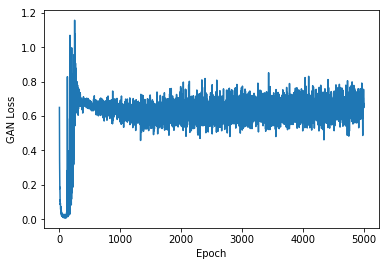

In [10]:
import matplotlib.pyplot as plt
plt.plot(gan.d_losses[:5000])
plt.ylabel('GAN Loss')
plt.xlabel('Epoch')
plt.show()

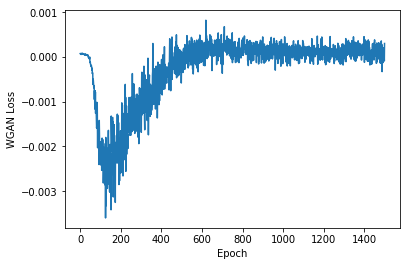

In [9]:
import matplotlib.pyplot as plt
plt.plot(wgan.d_losses[:1500])
plt.ylabel('WGAN Loss')
plt.xlabel('Epoch')
plt.show()

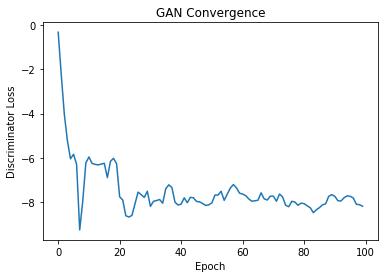

In [6]:
import numpy as np
losses = np.loadtxt('gan_discriminator_losses.csv',delimiter=',')

import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Discriminator Loss')
plt.xlabel('Epoch')
plt.title('GAN Convergence')
plt.show()


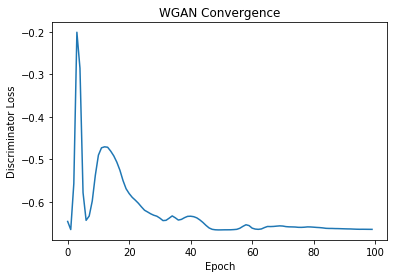

In [10]:
import numpy as np
losses = np.loadtxt('wgan_discriminator_losses.csv',delimiter=',')

import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Discriminator Loss')
plt.xlabel('Epoch')
plt.title('WGAN Convergence')
plt.show()


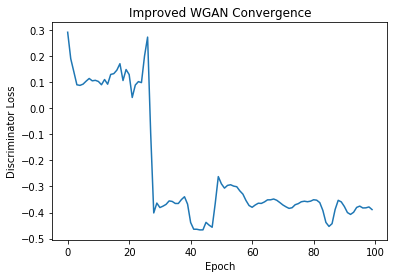

In [9]:
import numpy as np
losses = np.loadtxt('improved_wgan_discriminator_losses.csv',delimiter=',')

import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Discriminator Loss')
plt.xlabel('Epoch')
plt.title('Improved WGAN Convergence')
plt.show()
